In [1]:
import numpy as np
import itertools
import warnings
import matplotlib.pyplot as plt

In [2]:
import tenpy

from tenpy.networks.site import Site, SpinHalfFermionSite, SpinHalfSite, GroupedSite, SpinSite
from tenpy.tools.misc import to_iterable, to_iterable_of_len, inverse_permutation
from tenpy.networks.mps import MPS  # only to check boundary conditions

from tenpy.models.lattice import Lattice, _parse_sites
from tenpy.models.model import CouplingMPOModel, NearestNeighborModel
from tenpy.tools.params import get_parameter

from tenpy.algorithms import dmrg

In [3]:
__all__ = ['KitaevLadder', 'KitaevLadderModel']

In [4]:
class KitaevLadder(Lattice):    
    """ A ladder coupling two chains of the Kitaev form
    .. image :: /images/lattices/Ladder.*
    Parameters
    ----------
    L : int
        The length of each chain, we have 2*L sites in total.
    sites : (list of) :class:`~tenpy.networks.site.Site`
        The two local lattice sites making the `unit_cell` of the :class:`Lattice`.
        If only a single :class:`~tenpy.networks.site.Site` is given, it is used for both chains.
    **kwargs :
        Additional keyword arguments given to the :class:`Lattice`.
        `basis`, `pos` and `pairs` are set accordingly.
    """
    dim = 1

    def __init__(self, L, sites, **kwargs):
        sites = _parse_sites(sites, 4)
        basis = np.array([[2., 0.]])
        pos = np.array([[0., 0.], [0., 1.], [1., 0.], [1., 1.]])
        kwargs.setdefault('basis', basis)
        kwargs.setdefault('positions', pos)
        kwargs.setdefault('bc', 'periodic')
        kwargs.setdefault('bc_MPS', 'infinite')
        NNz = [(0, 1, np.array([0])), (2, 3, np.array([0]))]
        NNx = [(1, 3, np.array([0])), (2, 0, np.array([1]))]
        NNy = [(0, 2, np.array([0])), (3, 1, np.array([1]))]
        kwargs.setdefault('pairs', {})
        kwargs['pairs'].setdefault('nearest_neighbors_x', NNx)
        kwargs['pairs'].setdefault('nearest_neighbors_y', NNy)
        kwargs['pairs'].setdefault('nearest_neighbors_z', NNz)
        Lattice.__init__(self, [L], sites, **kwargs)
        
        
class KitaevLadderModel(CouplingMPOModel):
    def __init__(self, model_params):
        CouplingMPOModel.__init__(self, model_params)

    def init_sites(self, model_params):
        conserve = get_parameter(model_params, 'conserve', None, self.name)
        fs = SpinHalfSite(conserve=conserve)
        return [fs, fs, fs, fs]

    def init_lattice(self, model_params):
        L = get_parameter(model_params, 'L', 3, self.name)
        gs = self.init_sites(model_params)
        model_params.pop("L")
        lat = KitaevLadder(L, gs)
        return lat

    def init_terms(self, model_params):
        Jx = get_parameter(model_params, 'Jx', 1., self.name, True)
        Jy = get_parameter(model_params, 'Jy', 1., self.name, True)
        Jz = get_parameter(model_params, 'Jz', 1., self.name, True)

        for u1, u2, dx in self.lat.pairs['nearest_neighbors_z']:
            self.add_coupling(-Jz, u1, 'Sx', u2, 'Sx', dx)
        for u1, u2, dx in self.lat.pairs['nearest_neighbors_x']:
            self.add_coupling(-Jx, u1, 'Sz', u2, 'Sz', dx)
        for u1, u2, dx in self.lat.pairs['nearest_neighbors_y']:
            self.add_coupling(-Jy, u1, 'Sy', u2, 'Sy', dx)
         
        
def plot_lattice():
    fig, ax = plt.subplots()
    lat = KitaevLadder(5, None, bc='periodic')
    links_name = 'nearest_neighbors_z'
    lat.plot_coupling(ax, lat.pairs[links_name], linewidth=5.)
    # print(lat.pairs['nearest_neighbors'])
    print(lat.unit_cell)
    lat.plot_order(ax=ax, linestyle='--')
    lat.plot_sites(ax)
    # lat.plot_basis(ax, color='g', linewidth=3.)
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')
    # plt.title(links_name)
    plt.show()


In [5]:
def run(calc_correlation=True):

    model_params = dict(conserve=None, Jx=0.001, Jy=1.001, Jz=0.999, L=1, verbose=1)
    prod_state = ["up", "down"] * (2 * model_params['L'])
    M = KitaevLadderModel(model_params)
    psi = MPS.from_product_state(
        M.lat.mps_sites(), 
        prod_state, 
        bc=M.lat.bc_MPS,
    )

    dmrg_params = {
        'start_env': 10,
#         'mixer': False,  # setting this to True helps to escape local minima
        'mixer': True,
        'mixer_params': {
            'amplitude': 1.e-5,
            'decay': 1.2,
            'disable_after': 30
        },
        'trunc_params': {
            'chi_max': 4,
            'svd_min': 1.e-12, # reduce this when the bond dimension is increased
        },
        'max_E_err': 1.e-10,
        'max_S_err': 1.e-5,
        'max_sweeps': 5000,
        'verbose': 1.,
    }
    
    
#     eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
    
    data = dict(
        chi_list=[],
        energy_list=[], 
        entropy_list=[], 
        correlation_list=[],
    )
    
#     chi_list = np.arange(4, 129)
    chi_list = np.arange(16, 64, 1)
    data['chi_list'] = chi_list
    for chi in chi_list:
        
        print("\n")
        print("=" * 80)
        print("="*30 + "START" + "="*30)
        print("=" * 80)
        print("Chi = ", chi, '\n')
        
        eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
        eng.reset_stats()
        eng.trunc_params['chi_max'] = chi
        info = eng.run()
#         print("INFO: \n", info)

        print("Before the canonicalization:")
        print("Bond dim = ", psi.chi)
        
        print("Canonicalizing...")
        psi_before = psi.copy()
        psi.canonical_form()
        ov = psi.overlap(psi_before, charge_sector=0)
        print("The norm is: ",psi.norm)
        print("The overlap is: ", ov)
        print("After the canonicalization:")
        print("Bond dim = ", psi.chi)
        
        print("Computing properties")
        
        energy=info[0]
        data['energy_list'].append(energy)
        
        entropy = np.mean(psi.entanglement_entropy())
        data['entropy_list'].append(entropy)
        
        if calc_correlation:
            correlation = psi.correlation_length()
            data['correlation_list'].append(correlation)
        
        print("Optimizing")
        tenpy.tools.optimization.optimize(3)
        print("Loop for chi=%d done." % chi)
        print("=" * 80)
        print("="*30 + " END " + "="*30)
        print("=" * 80)
        pass
        
    return data


In [6]:
def plot_results(data):

    chi_list = data['chi_list']
    energy_list = data['energy_list']
    entropy_list = data['entropy_list']
    correlation_list = data['correlation_list']
    
    plt.plot(chi_list, energy_list, '-o')
    plt.xlabel(r"Bond dimension $\chi$")
    plt.ylabel(r"Ground Energy $E$")
    plt.show()
    
    plt.plot(chi_list, entropy_list, '-o')
    plt.xlabel(r"Bond dimension $\chi$")
    plt.ylabel(r"Entanglement Entropy $S$")
    plt.show()
    
    plt.plot(chi_list, correlation_list, '-o')
    plt.xlabel(r"Bond dimension $\chi$")
    plt.ylabel(r"Correlation Length $\xi$")
    plt.show()
    
    plt.plot(np.log(correlation_list), entropy_list, '-o')
    plt.xlabel(r"log Correlation Length $\xi$")
    plt.ylabel(r"Entanglement Entropy $S$")
    plt.show()
    

In [7]:
data = run()

parameter 'verbose'=1 for KitaevLadderModel
parameter 'L'=1 for KitaevLadderModel
parameter 'conserve'=None for KitaevLadderModel
parameter 'Jx'=0.001 for KitaevLadderModel
parameter 'Jy'=1.001 for KitaevLadderModel
parameter 'Jz'=0.999 for KitaevLadderModel


==============================START==============================
Chi =  16 

parameter 'verbose'=1.0 for Sweep
parameter 'trunc_params'={'chi_max': 4, 'svd_min': 1e-12} for Sweep
Initial sweeps...
parameter 'start_env'=10 for Sweep
Updating environment
..........
parameter 'max_sweeps'=5000 for DMRG
parameter 'max_E_err'=1e-10 for DMRG
parameter 'max_S_err'=1e-05 for DMRG
parameter 'mixer'=True for Sweep
parameter 'mixer_params'={'amplitude': 1e-05, 'decay': 1.2, 'disable_after': 30} for Sweep
Updating environment
.....
sweep 10, age = 204
Energy = -0.1591754583923062, S = nan, norm_err = 1.5e-03
Current memory usage 124.2 MB, time elapsed: 3.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.9522e-05, max_E_t

..........
Updating environment
.....
sweep 10, age = 204
Energy = -0.1591799126237574, S = nan, norm_err = 4.9e-04
Current memory usage 127.2 MB, time elapsed: 2.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.2131e-08, max_E_trunc = 3.9968e-08
MPS bond dimensions: [18, 18, 18, 18]
Updating environment
.....
sweep 20, age = 324
Energy = -0.1591807181608331, S = nan, norm_err = 5.7e-04
Current memory usage 127.2 MB, time elapsed: 4.6 s
Delta E = -8.0554e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.5492e-07, max_E_trunc = 2.2728e-07
MPS bond dimensions: [18, 18, 18, 18]
disable mixer after 30 sweeps, final amplitude 4.21e-08
Updating environment
.....
sweep 30, age = 444
Energy = -0.1591809551588916, S = 0.8990935951482170, norm_err = 4.1e-04
Current memory usage 127.2 MB, time elapsed: 6.7 s
Delta E = -2.3700e-08, Delta S = nan (per sweep)
max_trunc_err = 5.3456e-07, max_E_trunc = 3.4090e-07
MPS bond dimensions: [18, 18, 18, 18]
Updating environment
...

Updating environment
.....
sweep 220, age = 2724
Energy = -0.1591811491684325, S = 0.9677732599648160, norm_err = 2.9e-05
Current memory usage 127.7 MB, time elapsed: 30.1 s
Delta E = 1.8697e-11, Delta S = -3.4594e-05 (per sweep)
max_trunc_err = 6.1316e-07, max_E_trunc = 7.6977e-07
MPS bond dimensions: [18, 18, 18, 18]
Updating environment
.....
sweep 230, age = 2844
Energy = -0.1591811492162165, S = 0.9682733031125658, norm_err = 8.7e-06
Current memory usage 127.7 MB, time elapsed: 31.3 s
Delta E = -4.7784e-12, Delta S = 5.0004e-05 (per sweep)
max_trunc_err = 6.1419e-07, max_E_trunc = 7.7104e-07
MPS bond dimensions: [18, 18, 18, 18]
Updating environment
.....
sweep 240, age = 2964
Energy = -0.1591811491584565, S = 0.9684969303365887, norm_err = 9.0e-06
Current memory usage 128.0 MB, time elapsed: 32.5 s
Delta E = 5.7760e-12, Delta S = 2.2363e-05 (per sweep)
max_trunc_err = 6.1511e-07, max_E_trunc = 7.7217e-07
MPS bond dimensions: [18, 18, 18, 18]
Updating environment
.....
sweep 250, 

Updating environment
.....
sweep 150, age = 1884
Energy = -0.1591812195420772, S = 0.9771921345276740, norm_err = 1.0e-05
Current memory usage 128.4 MB, time elapsed: 21.7 s
Delta E = 1.1126e-11, Delta S = 3.4748e-05 (per sweep)
max_trunc_err = 4.9408e-07, max_E_trunc = 7.0884e-07
MPS bond dimensions: [19, 19, 19, 19]
Updating environment
.....
sweep 160, age = 2004
Energy = -0.1591812194472837, S = 0.9775069362241158, norm_err = 1.0e-05
Current memory usage 128.4 MB, time elapsed: 22.9 s
Delta E = 9.4794e-12, Delta S = 3.1480e-05 (per sweep)
max_trunc_err = 4.9537e-07, max_E_trunc = 7.1065e-07
MPS bond dimensions: [19, 19, 19, 19]
Updating environment
.....
sweep 170, age = 2124
Energy = -0.1591812193639157, S = 0.9777493902568936, norm_err = 8.6e-06
Current memory usage 128.4 MB, time elapsed: 24.0 s
Delta E = 8.3368e-12, Delta S = 2.4245e-05 (per sweep)
max_trunc_err = 4.9644e-07, max_E_trunc = 7.1216e-07
MPS bond dimensions: [19, 19, 19, 19]
Updating environment
.....
sweep 180, ag

Updating environment
.....
sweep 100, age = 1284
Energy = -0.1591814580518403, S = 1.0102841077241069, norm_err = 5.6e-05
Current memory usage 129.5 MB, time elapsed: 13.8 s
Delta E = -1.4245e-10, Delta S = 1.2485e-04 (per sweep)
max_trunc_err = 2.0200e-07, max_E_trunc = 2.5914e-07
MPS bond dimensions: [20, 20, 20, 20]
Updating environment
.....
sweep 110, age = 1404
Energy = -0.1591814583671045, S = 1.0125466830444276, norm_err = 7.5e-05
Current memory usage 129.5 MB, time elapsed: 14.9 s
Delta E = -3.1526e-11, Delta S = 2.2626e-04 (per sweep)
max_trunc_err = 2.0576e-07, max_E_trunc = 2.6391e-07
MPS bond dimensions: [20, 20, 20, 20]
Updating environment
.....
sweep 120, age = 1524
Energy = -0.1591814584882840, S = 1.0146049762669287, norm_err = 9.5e-05
Current memory usage 129.5 MB, time elapsed: 16.0 s
Delta E = -1.2118e-11, Delta S = 2.0583e-04 (per sweep)
max_trunc_err = 2.0929e-07, max_E_trunc = 2.6838e-07
MPS bond dimensions: [20, 20, 20, 20]
Updating environment
.....
sweep 130,

Updating environment
.....
sweep 310, age = 3804
Energy = -0.1591814578791571, S = 1.0270659081983957, norm_err = 1.0e-04
Current memory usage 130.6 MB, time elapsed: 38.1 s
Delta E = 4.2442e-11, Delta S = 5.8338e-05 (per sweep)
max_trunc_err = 2.3396e-07, max_E_trunc = 2.9962e-07
MPS bond dimensions: [20, 20, 20, 20]
Updating environment
.....
sweep 320, age = 3924
Energy = -0.1591814584468096, S = 1.0264025582097385, norm_err = 5.3e-05
Current memory usage 130.9 MB, time elapsed: 39.4 s
Delta E = -5.6765e-11, Delta S = -6.6335e-05 (per sweep)
max_trunc_err = 2.3474e-07, max_E_trunc = 3.0052e-07
MPS bond dimensions: [20, 20, 20, 20]
Updating environment
.....
sweep 330, age = 4044
Energy = -0.1591814581886695, S = 1.0269519113511687, norm_err = 6.8e-05
Current memory usage 130.9 MB, time elapsed: 40.5 s
Delta E = 2.5814e-11, Delta S = 5.4935e-05 (per sweep)
max_trunc_err = 2.3451e-07, max_E_trunc = 3.0032e-07
MPS bond dimensions: [20, 20, 20, 20]
Updating environment
.....
sweep 340, 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


.
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 1.02e-05
Call psi.canonical_form()
DMRG finished after 360 sweeps.
total size = 4604, maximum chi = 20
Before the canonicalization:
Bond dim =  [20, 20, 20, 20]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.000000000000004+2.0469737016526324e-16j)
After the canonicalization:
Bond dim =  [20, 20, 20, 20]
Computing properties
Optimizing
Loop for chi=20 done.
============================== END ==============================


==============================START==============================
Chi =  21 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 204
Energy = -0.1591804497642597, S = nan, norm_err = 1.0e-03
Current memory usage 131.7 MB, time elapsed: 3.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0049e-06, max_E_tru

Updating environment
.....
sweep 190, age = 2364
Energy = -0.1591814762424448, S = 1.0257198852082676, norm_err = 4.5e-05
Current memory usage 132.2 MB, time elapsed: 27.4 s
Delta E = 9.1376e-13, Delta S = 1.1187e-04 (per sweep)
max_trunc_err = 1.9275e-07, max_E_trunc = 2.6632e-07
MPS bond dimensions: [21, 21, 21, 21]
Updating environment
.....
sweep 200, age = 2484
Energy = -0.1591814761636172, S = 1.0267827348942196, norm_err = 6.4e-05
Current memory usage 132.2 MB, time elapsed: 28.5 s
Delta E = 7.8828e-12, Delta S = 1.0628e-04 (per sweep)
max_trunc_err = 1.9425e-07, max_E_trunc = 2.6838e-07
MPS bond dimensions: [21, 21, 21, 21]
Updating environment
.....
sweep 210, age = 2604
Energy = -0.1591814759607999, S = 1.0278339426291820, norm_err = 9.1e-05
Current memory usage 132.2 MB, time elapsed: 29.7 s
Delta E = 2.0282e-11, Delta S = 1.0512e-04 (per sweep)
max_trunc_err = 1.9560e-07, max_E_trunc = 2.7023e-07
MPS bond dimensions: [21, 21, 21, 21]
Updating environment
.....
sweep 220, ag

Updating environment
.....
sweep 400, age = 4884
Energy = -0.1591814757601924, S = 1.0327083416454848, norm_err = 1.7e-05
Current memory usage 132.4 MB, time elapsed: 52.2 s
Delta E = -5.9600e-12, Delta S = 9.6550e-06 (per sweep)
max_trunc_err = 2.0579e-07, max_E_trunc = 2.8419e-07
MPS bond dimensions: [21, 21, 21, 21]
norm_tol=1.00e-05 not reached, norm_err=1.70e-05
Updating environment
....

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


.
Updating environment
.....
DMRG finished after 400 sweeps.
total size = 4964, maximum chi = 21
Before the canonicalization:
Bond dim =  [21, 21, 21, 21]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999973756433+3.0010716134398763e-16j)
After the canonicalization:
Bond dim =  [21, 21, 21, 21]
Computing properties
Optimizing
Loop for chi=21 done.
============================== END ==============================


==============================START==============================
Chi =  22 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 204
Energy = -0.1591804315261056, S = nan, norm_err = 9.1e-04
Current memory usage 132.5 MB, time elapsed: 3.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.8459e-07, max_E_trunc = 5.5278e-07
MPS bond dimensions: [22, 22, 22, 22]
Updating environment
.....
sweep 20, age = 324
Energy = -0.1591805083561875, S = nan, norm_err = 3.4e-03
Current memory usage 132.5 MB, time elap

Updating environment
.....
sweep 190, age = 2364
Energy = -0.1591815142402595, S = 1.0384423198270387, norm_err = 3.2e-05
Current memory usage 132.5 MB, time elapsed: 26.5 s
Delta E = -3.8859e-11, Delta S = 1.6648e-04 (per sweep)
max_trunc_err = 1.6047e-07, max_E_trunc = 2.0684e-07
MPS bond dimensions: [22, 22, 22, 22]
Updating environment
.....
sweep 200, age = 2484
Energy = -0.1591815142972877, S = 1.0394627566252221, norm_err = 3.8e-06
Current memory usage 132.5 MB, time elapsed: 27.7 s
Delta E = -5.7028e-12, Delta S = 1.0204e-04 (per sweep)
max_trunc_err = 1.6196e-07, max_E_trunc = 2.0877e-07
MPS bond dimensions: [22, 22, 22, 22]
Updating environment
.....
sweep 210, age = 2604
Energy = -0.1591815143310171, S = 1.0403069526348063, norm_err = 1.6e-05
Current memory usage 132.5 MB, time elapsed: 28.9 s
Delta E = -3.3729e-12, Delta S = 8.4420e-05 (per sweep)
max_trunc_err = 1.6332e-07, max_E_trunc = 2.1052e-07
MPS bond dimensions: [22, 22, 22, 22]
Updating environment
.....
sweep 220,

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


.
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 4.22e-05
Call psi.canonical_form()
DMRG finished after 350 sweeps.
total size = 4484, maximum chi = 22
Before the canonicalization:
Bond dim =  [22, 22, 22, 22]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999984+1.214306433183765e-17j)
After the canonicalization:
Bond dim =  [22, 22, 22, 22]
Computing properties
Optimizing
Loop for chi=22 done.
============================== END ==============================


==============================START==============================
Chi =  23 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 204
Energy = -0.1591802577207049, S = nan, norm_err = 8.8e-04
Current memory usage 132.5 MB, time elapsed: 3.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.7366e-07, max_E_tru

Updating environment
.....
sweep 190, age = 2364
Energy = -0.1591815269579087, S = 1.0402341022806729, norm_err = 4.3e-05
Current memory usage 133.0 MB, time elapsed: 28.1 s
Delta E = -9.8417e-11, Delta S = 2.3435e-04 (per sweep)
max_trunc_err = 1.5061e-07, max_E_trunc = 1.9709e-07
MPS bond dimensions: [23, 23, 23, 23]
Updating environment
.....
sweep 200, age = 2484
Energy = -0.1591815270706149, S = 1.0417190291496934, norm_err = 2.0e-05
Current memory usage 133.0 MB, time elapsed: 29.3 s
Delta E = -1.1271e-11, Delta S = 1.4849e-04 (per sweep)
max_trunc_err = 1.5220e-07, max_E_trunc = 1.9929e-07
MPS bond dimensions: [23, 23, 23, 23]
Updating environment
.....
sweep 210, age = 2604
Energy = -0.1591815271613086, S = 1.0429325762367920, norm_err = 4.6e-05
Current memory usage 133.0 MB, time elapsed: 30.5 s
Delta E = -9.0694e-12, Delta S = 1.2135e-04 (per sweep)
max_trunc_err = 1.5503e-07, max_E_trunc = 2.0302e-07
MPS bond dimensions: [23, 23, 23, 23]
Updating environment
.....
sweep 220,

Updating environment
.....
sweep 130, age = 1644
Energy = -0.1591815415186204, S = 1.0271909860795323, norm_err = 1.1e-04
Current memory usage 133.9 MB, time elapsed: 20.1 s
Delta E = -2.1218e-10, Delta S = 4.1563e-04 (per sweep)
max_trunc_err = 1.2319e-07, max_E_trunc = 1.6230e-07
MPS bond dimensions: [24, 24, 24, 24]
Updating environment
.....
sweep 140, age = 1764
Energy = -0.1591815430578620, S = 1.0305172807319418, norm_err = 7.4e-05
Current memory usage 133.9 MB, time elapsed: 21.4 s
Delta E = -1.5392e-10, Delta S = 3.3263e-04 (per sweep)
max_trunc_err = 1.2725e-07, max_E_trunc = 1.6740e-07
MPS bond dimensions: [24, 24, 24, 24]
Updating environment
.....
sweep 150, age = 1884
Energy = -0.1591815442480993, S = 1.0334229671957440, norm_err = 5.1e-05
Current memory usage 133.9 MB, time elapsed: 22.6 s
Delta E = -1.1902e-10, Delta S = 2.9057e-04 (per sweep)
max_trunc_err = 1.3094e-07, max_E_trunc = 1.7201e-07
MPS bond dimensions: [24, 24, 24, 24]
Updating environment
.....
sweep 160,

Updating environment
.....
sweep 340, age = 4164
Energy = -0.1591815491935478, S = 1.0573353397817489, norm_err = 1.3e-05
Current memory usage 134.7 MB, time elapsed: 46.8 s
Delta E = -6.0481e-12, Delta S = 5.6473e-05 (per sweep)
max_trunc_err = 1.5997e-07, max_E_trunc = 2.0746e-07
MPS bond dimensions: [24, 24, 24, 24]
Updating environment
.....
sweep 350, age = 4284
Energy = -0.1591815491920272, S = 1.0577160008898829, norm_err = 1.5e-05
Current memory usage 134.7 MB, time elapsed: 48.1 s
Delta E = 1.5206e-13, Delta S = 3.8066e-05 (per sweep)
max_trunc_err = 1.6073e-07, max_E_trunc = 2.0841e-07
MPS bond dimensions: [24, 24, 24, 24]
Updating environment
.....
sweep 360, age = 4404
Energy = -0.1591815492206905, S = 1.0581075526476691, norm_err = 1.7e-05
Current memory usage 134.7 MB, time elapsed: 49.4 s
Delta E = -2.8663e-12, Delta S = 3.9155e-05 (per sweep)
max_trunc_err = 1.6100e-07, max_E_trunc = 2.0869e-07
MPS bond dimensions: [24, 24, 24, 24]
Updating environment
.....
sweep 370, 

norm_tol=1.00e-05 not reached, norm_err=3.55e-05
Updating environment
....

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


.
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 2.23e-05
Call psi.canonical_form()
DMRG finished after 540 sweeps.
total size = 6764, maximum chi = 24
Before the canonicalization:
Bond dim =  [24, 24, 24, 24]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000009-3.108949729602184e-17j)
After the canonicalization:
Bond dim =  [24, 24, 24, 24]
Computing properties
Optimizing
Loop for chi=24 done.
============================== END ==============================


==============================START==============================
Chi =  25 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 204
Energy = -0.1591791069789465, S = nan, norm_err = 4.0e-02
Current memory usage 135.4 MB, time elapsed: 5.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.5031e-07, max_E_tru

Updating environment
.....
sweep 190, age = 2364
Energy = -0.1591815554497487, S = 1.1664743723744406, norm_err = 8.4e-05
Current memory usage 135.4 MB, time elapsed: 37.4 s
Delta E = -7.0771e-11, Delta S = -2.1524e-04 (per sweep)
max_trunc_err = 1.7519e-07, max_E_trunc = 2.2531e-07
MPS bond dimensions: [25, 25, 25, 25]
Updating environment
.....
sweep 200, age = 2484
Energy = -0.1591815560435847, S = 1.1645735110038826, norm_err = 7.0e-05
Current memory usage 135.4 MB, time elapsed: 38.6 s
Delta E = -5.9384e-11, Delta S = -1.9009e-04 (per sweep)
max_trunc_err = 1.7244e-07, max_E_trunc = 2.2187e-07
MPS bond dimensions: [25, 25, 25, 25]
Updating environment
.....
sweep 210, age = 2604
Energy = -0.1591815565731807, S = 1.1625264045277974, norm_err = 7.3e-05
Current memory usage 135.4 MB, time elapsed: 39.8 s
Delta E = -5.2960e-11, Delta S = -2.0471e-04 (per sweep)
max_trunc_err = 1.7025e-07, max_E_trunc = 2.1915e-07
MPS bond dimensions: [25, 25, 25, 25]
Updating environment
.....
sweep 2

Updating environment
.....
sweep 400, age = 4884
Energy = -0.1591815625212263, S = 1.1312668881275598, norm_err = 6.0e-05
Current memory usage 135.4 MB, time elapsed: 62.6 s
Delta E = -2.3810e-11, Delta S = -1.4840e-04 (per sweep)
max_trunc_err = 1.6202e-07, max_E_trunc = 2.0758e-07
MPS bond dimensions: [25, 25, 25, 25]
Updating environment
.....
sweep 410, age = 5004
Energy = -0.1591815627559754, S = 1.1298120775825340, norm_err = 5.8e-05
Current memory usage 135.4 MB, time elapsed: 63.8 s
Delta E = -2.3475e-11, Delta S = -1.4548e-04 (per sweep)
max_trunc_err = 1.6186e-07, max_E_trunc = 2.0726e-07
MPS bond dimensions: [25, 25, 25, 25]
Updating environment
.....
sweep 420, age = 5124
Energy = -0.1591815629857365, S = 1.1283871823512723, norm_err = 5.7e-05
Current memory usage 135.4 MB, time elapsed: 65.0 s
Delta E = -2.2976e-11, Delta S = -1.4249e-04 (per sweep)
max_trunc_err = 1.6164e-07, max_E_trunc = 2.0688e-07
MPS bond dimensions: [25, 25, 25, 25]
Updating environment
.....
sweep 4

Updating environment
.....
sweep 610, age = 7404
Energy = -0.1591815656737765, S = 1.1079937915258680, norm_err = 3.3e-05
Current memory usage 135.9 MB, time elapsed: 88.6 s
Delta E = -7.7563e-12, Delta S = -7.7515e-05 (per sweep)
max_trunc_err = 1.5799e-07, max_E_trunc = 2.0183e-07
MPS bond dimensions: [25, 25, 25, 25]
Updating environment
.....
sweep 620, age = 7524
Energy = -0.1591815657449160, S = 1.1072468207964206, norm_err = 3.2e-05
Current memory usage 135.9 MB, time elapsed: 89.8 s
Delta E = -7.1140e-12, Delta S = -7.4697e-05 (per sweep)
max_trunc_err = 1.5763e-07, max_E_trunc = 2.0141e-07
MPS bond dimensions: [25, 25, 25, 25]
Updating environment
.....
sweep 630, age = 7644
Energy = -0.1591815658103428, S = 1.1065275206154150, norm_err = 3.1e-05
Current memory usage 136.1 MB, time elapsed: 91.1 s
Delta E = -6.5427e-12, Delta S = -7.1930e-05 (per sweep)
max_trunc_err = 1.5728e-07, max_E_trunc = 2.0101e-07
MPS bond dimensions: [25, 25, 25, 25]
Updating environment
.....
sweep 6

Updating environment
.....
sweep 820, age = 9924
Energy = -0.1591815662224860, S = 1.0969019083290794, norm_err = 2.2e-05
Current memory usage 138.1 MB, time elapsed: 114.9 s
Delta E = 7.8160e-13, Delta S = -3.6311e-05 (per sweep)
max_trunc_err = 1.5284e-07, max_E_trunc = 1.9699e-07
MPS bond dimensions: [25, 25, 25, 25]
Updating environment
.....
sweep 830, age = 10044
Energy = -0.1591815662121689, S = 1.0965495574193791, norm_err = 2.1e-05
Current memory usage 138.1 MB, time elapsed: 116.1 s
Delta E = 1.0317e-12, Delta S = -3.5235e-05 (per sweep)
max_trunc_err = 1.5272e-07, max_E_trunc = 1.9696e-07
MPS bond dimensions: [25, 25, 25, 25]
Updating environment
.....
sweep 840, age = 10164
Energy = -0.1591815661985265, S = 1.0962072329555186, norm_err = 2.1e-05
Current memory usage 138.1 MB, time elapsed: 117.4 s
Delta E = 1.3642e-12, Delta S = -3.4232e-05 (per sweep)
max_trunc_err = 1.5260e-07, max_E_trunc = 1.9694e-07
MPS bond dimensions: [25, 25, 25, 25]
Updating environment
.....
sweep

Updating environment
.....
sweep 1030, age = 12444
Energy = -0.1591815651294723, S = 1.0905157929407541, norm_err = 2.5e-05
Current memory usage 138.8 MB, time elapsed: 141.1 s
Delta E = 1.2136e-11, Delta S = -3.2195e-05 (per sweep)
max_trunc_err = 1.5257e-07, max_E_trunc = 2.0157e-07
MPS bond dimensions: [25, 25, 25, 25]
Updating environment
.....
sweep 1040, age = 12564
Energy = -0.1591815649973114, S = 1.0901815463655002, norm_err = 2.6e-05
Current memory usage 138.8 MB, time elapsed: 142.4 s
Delta E = 1.3216e-11, Delta S = -3.3425e-05 (per sweep)
max_trunc_err = 1.5273e-07, max_E_trunc = 2.0225e-07
MPS bond dimensions: [25, 25, 25, 25]
Updating environment
.....
sweep 1050, age = 12684
Energy = -0.1591815648577040, S = 1.0898335886159731, norm_err = 2.7e-05
Current memory usage 138.8 MB, time elapsed: 143.7 s
Delta E = 1.3961e-11, Delta S = -3.4796e-05 (per sweep)
max_trunc_err = 1.5290e-07, max_E_trunc = 2.0297e-07
MPS bond dimensions: [25, 25, 25, 25]
Updating environment
.....
s

Updating environment
.....
sweep 1240, age = 14964
Energy = -0.1591815632860403, S = 1.0823043513979675, norm_err = 2.7e-05
Current memory usage 139.8 MB, time elapsed: 167.8 s
Delta E = 2.1487e-12, Delta S = -3.3243e-05 (per sweep)
max_trunc_err = 1.5196e-07, max_E_trunc = 2.0760e-07
MPS bond dimensions: [25, 25, 25, 25]
Updating environment
.....
sweep 1250, age = 15084
Energy = -0.1591815632666567, S = 1.0819849356059854, norm_err = 2.7e-05
Current memory usage 139.8 MB, time elapsed: 169.1 s
Delta E = 1.9384e-12, Delta S = -3.1942e-05 (per sweep)
max_trunc_err = 1.5176e-07, max_E_trunc = 2.0744e-07
MPS bond dimensions: [25, 25, 25, 25]
Updating environment
.....
sweep 1260, age = 15204
Energy = -0.1591815632478983, S = 1.0816784733604083, norm_err = 2.6e-05
Current memory usage 139.8 MB, time elapsed: 170.3 s
Delta E = 1.8758e-12, Delta S = -3.0646e-05 (per sweep)
max_trunc_err = 1.5156e-07, max_E_trunc = 2.0727e-07
MPS bond dimensions: [25, 25, 25, 25]
Updating environment
.....
s

Updating environment
.....
sweep 1450, age = 17484
Energy = -0.1591815630824271, S = 1.0779240322269645, norm_err = 2.0e-05
Current memory usage 140.8 MB, time elapsed: 194.1 s
Delta E = 4.8885e-13, Delta S = -1.1992e-05 (per sweep)
max_trunc_err = 1.4885e-07, max_E_trunc = 2.0457e-07
MPS bond dimensions: [25, 25, 25, 25]
Updating environment
.....
sweep 1460, age = 17604
Energy = -0.1591815630785618, S = 1.0778104304109166, norm_err = 2.0e-05
Current memory usage 140.8 MB, time elapsed: 195.3 s
Delta E = 3.8654e-13, Delta S = -1.1360e-05 (per sweep)
max_trunc_err = 1.4876e-07, max_E_trunc = 2.0447e-07
MPS bond dimensions: [25, 25, 25, 25]
Updating environment
.....
sweep 1470, age = 17724
Energy = -0.1591815630750375, S = 1.0777028364273105, norm_err = 2.0e-05
Current memory usage 140.8 MB, time elapsed: 196.5 s
Delta E = 3.5243e-13, Delta S = -1.0759e-05 (per sweep)
max_trunc_err = 1.4868e-07, max_E_trunc = 2.0438e-07
MPS bond dimensions: [25, 25, 25, 25]
Updating environment
.....
s

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


.
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 1.29e-05
Call psi.canonical_form()
DMRG finished after 1490 sweeps.
total size = 18164, maximum chi = 25
Before the canonicalization:
Bond dim =  [25, 25, 25, 25]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999998-2.6150956400350367e-16j)
After the canonicalization:
Bond dim =  [25, 25, 25, 25]
Computing properties
Optimizing
Loop for chi=25 done.
============================== END ==============================


==============================START==============================
Chi =  26 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 204
Energy = -0.1591796907208822, S = nan, norm_err = 6.2e-03
Current memory usage 141.1 MB, time elapsed: 4.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.9764e-07, max_E_

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


.
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 2.54e-05
Call psi.canonical_form()
DMRG finished after 160 sweeps.
total size = 2204, maximum chi = 26
Before the canonicalization:
Bond dim =  [26, 26, 26, 26]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000002-1.3357370765021415e-16j)
After the canonicalization:
Bond dim =  [26, 26, 26, 26]
Computing properties
Optimizing
Loop for chi=26 done.
============================== END ==============================


==============================START==============================
Chi =  27 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 204
Energy = -0.1591805202966374, S = nan, norm_err = 7.5e-04
Current memory usage 142.5 MB, time elapsed: 3.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.9971e-07, max_E_tr

Updating environment
.....
sweep 190, age = 2364
Energy = -0.1591815930371681, S = 1.0555828964381679, norm_err = 1.2e-04
Current memory usage 142.5 MB, time elapsed: 29.6 s
Delta E = -1.5772e-10, Delta S = 3.6462e-04 (per sweep)
max_trunc_err = 7.3765e-08, max_E_trunc = 9.9465e-08
MPS bond dimensions: [27, 27, 27, 27]
Updating environment
.....
sweep 200, age = 2484
Energy = -0.1591815945010637, S = 1.0590335740224583, norm_err = 1.0e-04
Current memory usage 142.5 MB, time elapsed: 30.9 s
Delta E = -1.4639e-10, Delta S = 3.4507e-04 (per sweep)
max_trunc_err = 7.5775e-08, max_E_trunc = 1.0208e-07
MPS bond dimensions: [27, 27, 27, 27]
Updating environment
.....
sweep 210, age = 2604
Energy = -0.1591815956743687, S = 1.0621483414087514, norm_err = 9.7e-05
Current memory usage 142.5 MB, time elapsed: 32.5 s
Delta E = -1.1733e-10, Delta S = 3.1148e-04 (per sweep)
max_trunc_err = 7.7730e-08, max_E_trunc = 1.0462e-07
MPS bond dimensions: [27, 27, 27, 27]
Updating environment
.....
sweep 220,

Updating environment
.....
sweep 400, age = 4884
Energy = -0.1591816026038657, S = 1.0950122520329493, norm_err = 3.1e-05
Current memory usage 142.5 MB, time elapsed: 57.3 s
Delta E = -8.7795e-12, Delta S = 9.4968e-05 (per sweep)
max_trunc_err = 9.7535e-08, max_E_trunc = 1.3006e-07
MPS bond dimensions: [27, 27, 27, 27]
Updating environment
.....
sweep 410, age = 5004
Energy = -0.1591816026812580, S = 1.0959108549437506, norm_err = 2.9e-05
Current memory usage 142.5 MB, time elapsed: 58.7 s
Delta E = -7.7392e-12, Delta S = 8.9860e-05 (per sweep)
max_trunc_err = 9.8100e-08, max_E_trunc = 1.3079e-07
MPS bond dimensions: [27, 27, 27, 27]
Updating environment
.....
sweep 420, age = 5124
Energy = -0.1591816027496407, S = 1.0967615645268951, norm_err = 2.8e-05
Current memory usage 142.5 MB, time elapsed: 60.0 s
Delta E = -6.8383e-12, Delta S = 8.5071e-05 (per sweep)
max_trunc_err = 9.8636e-08, max_E_trunc = 1.3149e-07
MPS bond dimensions: [27, 27, 27, 27]
Updating environment
.....
sweep 430,

Updating environment
.....
sweep 610, age = 7404
Energy = -0.1591816032401709, S = 1.1067447963990960, norm_err = 1.1e-05
Current memory usage 142.5 MB, time elapsed: 84.4 s
Delta E = -7.9012e-13, Delta S = 3.2186e-05 (per sweep)
max_trunc_err = 1.0492e-07, max_E_trunc = 1.3958e-07
MPS bond dimensions: [27, 27, 27, 27]
Updating environment
.....
sweep 620, age = 7524
Energy = -0.1591816032459406, S = 1.1070513806831159, norm_err = 1.0e-05
Current memory usage 142.5 MB, time elapsed: 85.8 s
Delta E = -5.7696e-13, Delta S = 3.0658e-05 (per sweep)
max_trunc_err = 1.0511e-07, max_E_trunc = 1.3984e-07
MPS bond dimensions: [27, 27, 27, 27]
Updating environment
.....
sweep 630, age = 7644
Energy = -0.1591816032516817, S = 1.1073434634029109, norm_err = 9.8e-06
Current memory usage 142.5 MB, time elapsed: 87.2 s
Delta E = -5.7412e-13, Delta S = 2.9208e-05 (per sweep)
max_trunc_err = 1.0530e-07, max_E_trunc = 1.4007e-07
MPS bond dimensions: [27, 27, 27, 27]
Updating environment
.....
sweep 640,

Updating environment
.....
sweep 820, age = 9924
Energy = -0.1591816032825761, S = 1.1109106106072235, norm_err = 4.5e-06
Current memory usage 142.5 MB, time elapsed: 112.2 s
Delta E = 6.8212e-14, Delta S = 1.1917e-05 (per sweep)
max_trunc_err = 1.0754e-07, max_E_trunc = 1.4297e-07
MPS bond dimensions: [27, 27, 27, 27]
Updating environment
.....
sweep 830, age = 10044
Energy = -0.1591816032812403, S = 1.1110243907239665, norm_err = 4.4e-06
Current memory usage 142.5 MB, time elapsed: 113.5 s
Delta E = 1.3358e-13, Delta S = 1.1378e-05 (per sweep)
max_trunc_err = 1.0761e-07, max_E_trunc = 1.4305e-07
MPS bond dimensions: [27, 27, 27, 27]
Updating environment
.....
sweep 840, age = 10164
Energy = -0.1591816032824340, S = 1.1111330338387013, norm_err = 4.2e-06
Current memory usage 142.5 MB, time elapsed: 114.9 s
Delta E = -1.1937e-13, Delta S = 1.0864e-05 (per sweep)
max_trunc_err = 1.0768e-07, max_E_trunc = 1.4314e-07
MPS bond dimensions: [27, 27, 27, 27]
Updating environment
.....
sweep 8

Updating environment
.....
sweep 140, age = 1764
Energy = -0.1591816024072799, S = 1.0423099884529257, norm_err = 1.5e-04
Current memory usage 142.5 MB, time elapsed: 22.6 s
Delta E = -4.2752e-10, Delta S = 5.8911e-04 (per sweep)
max_trunc_err = 4.4580e-08, max_E_trunc = 5.5598e-08
MPS bond dimensions: [28, 28, 28, 28]
Updating environment
.....
sweep 150, age = 1884
Energy = -0.1591816058906588, S = 1.0476000382261659, norm_err = 1.5e-04
Current memory usage 142.5 MB, time elapsed: 23.8 s
Delta E = -3.4834e-10, Delta S = 5.2900e-04 (per sweep)
max_trunc_err = 4.7251e-08, max_E_trunc = 5.8892e-08
MPS bond dimensions: [28, 28, 28, 28]
Updating environment
.....
sweep 160, age = 2004
Energy = -0.1591816087697282, S = 1.0524703459437337, norm_err = 1.4e-04
Current memory usage 142.5 MB, time elapsed: 25.0 s
Delta E = -2.8791e-10, Delta S = 4.8703e-04 (per sweep)
max_trunc_err = 4.9719e-08, max_E_trunc = 6.1937e-08
MPS bond dimensions: [28, 28, 28, 28]
Updating environment
.....
sweep 170,

Updating environment
.....
sweep 350, age = 4284
Energy = -0.1591816246886992, S = 1.1006999565636486, norm_err = 4.0e-05
Current memory usage 142.5 MB, time elapsed: 48.1 s
Delta E = -2.0407e-11, Delta S = 1.3537e-04 (per sweep)
max_trunc_err = 7.5833e-08, max_E_trunc = 9.4171e-08
MPS bond dimensions: [28, 28, 28, 28]
Updating environment
.....
sweep 360, age = 4404
Energy = -0.1591816248725166, S = 1.1019804366277042, norm_err = 3.8e-05
Current memory usage 142.5 MB, time elapsed: 49.3 s
Delta E = -1.8382e-11, Delta S = 1.2805e-04 (per sweep)
max_trunc_err = 7.6549e-08, max_E_trunc = 9.5056e-08
MPS bond dimensions: [28, 28, 28, 28]
Updating environment
.....
sweep 370, age = 4524
Energy = -0.1591816250364104, S = 1.1031925162384473, norm_err = 3.5e-05
Current memory usage 142.6 MB, time elapsed: 50.5 s
Delta E = -1.6389e-11, Delta S = 1.2121e-04 (per sweep)
max_trunc_err = 7.7228e-08, max_E_trunc = 9.5895e-08
MPS bond dimensions: [28, 28, 28, 28]
Updating environment
.....
sweep 380,

Updating environment
.....
sweep 560, age = 6804
Energy = -0.1591816263764088, S = 1.1175431263883797, norm_err = 1.2e-05
Current memory usage 143.1 MB, time elapsed: 73.9 s
Delta E = -2.7057e-12, Delta S = 4.7228e-05 (per sweep)
max_trunc_err = 8.5306e-08, max_E_trunc = 1.0588e-07
MPS bond dimensions: [28, 28, 28, 28]
Updating environment
.....
sweep 570, age = 6924
Energy = -0.1591816264017325, S = 1.1179942299642005, norm_err = 1.1e-05
Current memory usage 143.1 MB, time elapsed: 75.2 s
Delta E = -2.5324e-12, Delta S = 4.5110e-05 (per sweep)
max_trunc_err = 8.5561e-08, max_E_trunc = 1.0619e-07
MPS bond dimensions: [28, 28, 28, 28]
Updating environment
.....
sweep 580, age = 7044
Energy = -0.1591816264241857, S = 1.1184252240057775, norm_err = 1.0e-05
Current memory usage 143.1 MB, time elapsed: 76.4 s
Delta E = -2.2453e-12, Delta S = 4.3099e-05 (per sweep)
max_trunc_err = 8.5805e-08, max_E_trunc = 1.0650e-07
MPS bond dimensions: [28, 28, 28, 28]
Updating environment
.....
sweep 590,

Updating environment
.....
sweep 770, age = 9324
Energy = -0.1591816266427770, S = 1.1238423450962700, norm_err = 3.5e-06
Current memory usage 143.1 MB, time elapsed: 99.7 s
Delta E = -5.3149e-13, Delta S = 1.8805e-05 (per sweep)
max_trunc_err = 8.8870e-08, max_E_trunc = 1.1029e-07
MPS bond dimensions: [28, 28, 28, 28]
Updating environment
.....
sweep 780, age = 9444
Energy = -0.1591816266477224, S = 1.1240226190911038, norm_err = 3.4e-06
Current memory usage 143.1 MB, time elapsed: 100.9 s
Delta E = -4.9454e-13, Delta S = 1.8027e-05 (per sweep)
max_trunc_err = 8.8972e-08, max_E_trunc = 1.1041e-07
MPS bond dimensions: [28, 28, 28, 28]
Updating environment
.....
sweep 790, age = 9564
Energy = -0.1591816266525257, S = 1.1241954642008327, norm_err = 3.3e-06
Current memory usage 143.1 MB, time elapsed: 102.1 s
Delta E = -4.8033e-13, Delta S = 1.7285e-05 (per sweep)
max_trunc_err = 8.9070e-08, max_E_trunc = 1.1053e-07
MPS bond dimensions: [28, 28, 28, 28]
Updating environment
.....
sweep 80

Updating environment
.....
sweep 20, age = 324
Energy = -0.1591811207436624, S = nan, norm_err = 8.0e-04
Current memory usage 143.1 MB, time elapsed: 7.0 s
Delta E = -4.3373e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.1164e-08, max_E_trunc = 2.6036e-08
MPS bond dimensions: [29, 29, 29, 29]
disable mixer after 30 sweeps, final amplitude 4.21e-08
Updating environment
.....
sweep 30, age = 444
Energy = -0.1591813163231937, S = 0.9257606975110411, norm_err = 5.6e-04
Current memory usage 143.1 MB, time elapsed: 9.3 s
Delta E = -1.9558e-08, Delta S = nan (per sweep)
max_trunc_err = 1.1127e-08, max_E_trunc = 7.6277e-09
MPS bond dimensions: [29, 29, 29, 29]
Updating environment
.....
sweep 40, age = 564
Energy = -0.1591814147095629, S = 0.9456325463446761, norm_err = 4.9e-04
Current memory usage 143.1 MB, time elapsed: 10.8 s
Delta E = -9.8386e-09, Delta S = 1.9872e-03 (per sweep)
max_trunc_err = 7.6443e-09, max_E_trunc = 1.0585e-08
MPS bond dimensions: [29, 29, 29, 29]
Updating en

Updating environment
.....
sweep 230, age = 2844
Energy = -0.1591816259879408, S = 1.0824944181581562, norm_err = 9.1e-05
Current memory usage 143.1 MB, time elapsed: 36.6 s
Delta E = -9.8332e-11, Delta S = 3.0396e-04 (per sweep)
max_trunc_err = 5.5569e-08, max_E_trunc = 7.4879e-08
MPS bond dimensions: [29, 29, 29, 29]
Updating environment
.....
sweep 240, age = 2964
Energy = -0.1591816268442940, S = 1.0853413659855162, norm_err = 8.5e-05
Current memory usage 143.1 MB, time elapsed: 37.9 s
Delta E = -8.5635e-11, Delta S = 2.8469e-04 (per sweep)
max_trunc_err = 5.6952e-08, max_E_trunc = 7.6715e-08
MPS bond dimensions: [29, 29, 29, 29]
Updating environment
.....
sweep 250, age = 3084
Energy = -0.1591816275925311, S = 1.0880094484642686, norm_err = 8.0e-05
Current memory usage 143.1 MB, time elapsed: 39.1 s
Delta E = -7.4824e-11, Delta S = 2.6681e-04 (per sweep)
max_trunc_err = 5.8254e-08, max_E_trunc = 7.8442e-08
MPS bond dimensions: [29, 29, 29, 29]
Updating environment
.....
sweep 260,

Updating environment
.....
sweep 440, age = 5364
Energy = -0.1591816329174804, S = 1.1179848681262481, norm_err = 2.9e-05
Current memory usage 143.1 MB, time elapsed: 62.6 s
Delta E = -9.3848e-12, Delta S = 9.4923e-05 (per sweep)
max_trunc_err = 7.3254e-08, max_E_trunc = 9.8285e-08
MPS bond dimensions: [29, 29, 29, 29]
Updating environment
.....
sweep 450, age = 5484
Energy = -0.1591816330025040, S = 1.1188901208141289, norm_err = 2.8e-05
Current memory usage 143.1 MB, time elapsed: 63.8 s
Delta E = -8.5024e-12, Delta S = 9.0525e-05 (per sweep)
max_trunc_err = 7.3715e-08, max_E_trunc = 9.8890e-08
MPS bond dimensions: [29, 29, 29, 29]
Updating environment
.....
sweep 460, age = 5604
Energy = -0.1591816330804647, S = 1.1197538426235230, norm_err = 2.6e-05
Current memory usage 143.1 MB, time elapsed: 65.1 s
Delta E = -7.7961e-12, Delta S = 8.6372e-05 (per sweep)
max_trunc_err = 7.4156e-08, max_E_trunc = 9.9471e-08
MPS bond dimensions: [29, 29, 29, 29]
Updating environment
.....
sweep 470,

Updating environment
.....
sweep 650, age = 7884
Energy = -0.1591816337670480, S = 1.1305874379943450, norm_err = 1.0e-05
Current memory usage 144.1 MB, time elapsed: 88.7 s
Delta E = -1.6314e-12, Delta S = 3.7861e-05 (per sweep)
max_trunc_err = 7.9707e-08, max_E_trunc = 1.0678e-07
MPS bond dimensions: [29, 29, 29, 29]
Updating environment
.....
sweep 660, age = 8004
Energy = -0.1591816337810883, S = 1.1309509199731556, norm_err = 9.9e-06
Current memory usage 144.1 MB, time elapsed: 89.9 s
Delta E = -1.4040e-12, Delta S = 3.6348e-05 (per sweep)
max_trunc_err = 7.9894e-08, max_E_trunc = 1.0703e-07
MPS bond dimensions: [29, 29, 29, 29]
Updating environment
.....
sweep 670, age = 8124
Energy = -0.1591816337937928, S = 1.1312999461354780, norm_err = 9.5e-06
Current memory usage 144.1 MB, time elapsed: 91.2 s
Delta E = -1.2705e-12, Delta S = 3.4903e-05 (per sweep)
max_trunc_err = 8.0074e-08, max_E_trunc = 1.0726e-07
MPS bond dimensions: [29, 29, 29, 29]
Updating environment
.....
sweep 680,

Updating environment
.....
sweep 860, age = 10404
Energy = -0.1591816338826391, S = 1.1358699439930895, norm_err = 1.6e-05
Current memory usage 144.1 MB, time elapsed: 114.8 s
Delta E = 3.4674e-13, Delta S = 1.6590e-05 (per sweep)
max_trunc_err = 8.2437e-08, max_E_trunc = 1.1036e-07
MPS bond dimensions: [29, 29, 29, 29]
Updating environment
.....
sweep 870, age = 10524
Energy = -0.1591816338793421, S = 1.1360296329031603, norm_err = 1.7e-05
Current memory usage 144.1 MB, time elapsed: 116.0 s
Delta E = 3.2969e-13, Delta S = 1.5969e-05 (per sweep)
max_trunc_err = 8.2521e-08, max_E_trunc = 1.1047e-07
MPS bond dimensions: [29, 29, 29, 29]
Updating environment
.....
sweep 880, age = 10644
Energy = -0.1591816338737431, S = 1.1361833476571639, norm_err = 1.9e-05
Current memory usage 144.1 MB, time elapsed: 117.3 s
Delta E = 5.5991e-13, Delta S = 1.5371e-05 (per sweep)
max_trunc_err = 8.2601e-08, max_E_trunc = 1.1058e-07
MPS bond dimensions: [29, 29, 29, 29]
Updating environment
.....
sweep 8

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


.
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 2.60e-05
Call psi.canonical_form()
DMRG finished after 1000 sweeps.
total size = 12284, maximum chi = 29
Before the canonicalization:
Bond dim =  [29, 29, 29, 29]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000027+1.148712201748392e-16j)
After the canonicalization:
Bond dim =  [29, 29, 29, 29]
Computing properties
Optimizing
Loop for chi=29 done.
============================== END ==============================


==============================START==============================
Chi =  30 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 204
Energy = -0.1591807236039378, S = nan, norm_err = 9.5e-04
Current memory usage 144.1 MB, time elapsed: 3.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.2495e-08, max_E_t

Updating environment
.....
sweep 190, age = 2364
Energy = -0.1591816337901619, S = 1.0778811087067359, norm_err = 2.4e-04
Current memory usage 144.1 MB, time elapsed: 31.8 s
Delta E = -1.8731e-10, Delta S = 5.6320e-04 (per sweep)
max_trunc_err = 3.9033e-08, max_E_trunc = 5.0476e-08
MPS bond dimensions: [30, 30, 30, 30]
Updating environment
.....
sweep 200, age = 2484
Energy = -0.1591816356468456, S = 1.0822860446646909, norm_err = 1.9e-04
Current memory usage 144.1 MB, time elapsed: 33.5 s
Delta E = -1.8567e-10, Delta S = 4.4049e-04 (per sweep)
max_trunc_err = 4.0855e-08, max_E_trunc = 5.2790e-08
MPS bond dimensions: [30, 30, 30, 30]
Updating environment
.....
sweep 210, age = 2604
Energy = -0.1591816373418027, S = 1.0857442347752426, norm_err = 1.9e-04
Current memory usage 144.1 MB, time elapsed: 35.0 s
Delta E = -1.6950e-10, Delta S = 3.4582e-04 (per sweep)
max_trunc_err = 4.2612e-08, max_E_trunc = 5.5032e-08
MPS bond dimensions: [30, 30, 30, 30]
Updating environment
.....
sweep 220,

Updating environment
.....
sweep 400, age = 4884
Energy = -0.1591816478798762, S = 1.1318872329654437, norm_err = 1.9e-04
Current memory usage 144.1 MB, time elapsed: 62.3 s
Delta E = -5.2965e-11, Delta S = 3.9868e-04 (per sweep)
max_trunc_err = 6.1489e-08, max_E_trunc = 7.8868e-08
MPS bond dimensions: [30, 30, 30, 30]
Updating environment
.....
sweep 410, age = 5004
Energy = -0.1591816481480635, S = 1.1315608814810854, norm_err = 8.2e-05
Current memory usage 144.1 MB, time elapsed: 63.7 s
Delta E = -2.6819e-11, Delta S = -3.2635e-05 (per sweep)
max_trunc_err = 6.2370e-08, max_E_trunc = 7.9981e-08
MPS bond dimensions: [30, 30, 30, 30]
Updating environment
.....
sweep 420, age = 5124
Energy = -0.1591816483499571, S = 1.1351625829625065, norm_err = 9.5e-05
Current memory usage 144.1 MB, time elapsed: 65.2 s
Delta E = -2.0189e-11, Delta S = 3.6017e-04 (per sweep)
max_trunc_err = 6.3689e-08, max_E_trunc = 8.1670e-08
MPS bond dimensions: [30, 30, 30, 30]
Updating environment
.....
sweep 430

Updating environment
.....
sweep 610, age = 7404
Energy = -0.1591816494384375, S = 1.1513156973958116, norm_err = 2.1e-04
Current memory usage 144.1 MB, time elapsed: 92.9 s
Delta E = 3.2890e-11, Delta S = 9.3586e-05 (per sweep)
max_trunc_err = 7.0309e-08, max_E_trunc = 8.9973e-08
MPS bond dimensions: [30, 30, 30, 30]
Updating environment
.....
sweep 620, age = 7524
Energy = -0.1591816491456086, S = 1.1524952500738477, norm_err = 2.0e-04
Current memory usage 144.1 MB, time elapsed: 94.5 s
Delta E = 2.9283e-11, Delta S = 1.1796e-04 (per sweep)
max_trunc_err = 7.0990e-08, max_E_trunc = 9.0814e-08
MPS bond dimensions: [30, 30, 30, 30]
Updating environment
.....
sweep 630, age = 7644
Energy = -0.1591816497174534, S = 1.1529268171976748, norm_err = 6.5e-05
Current memory usage 144.1 MB, time elapsed: 96.1 s
Delta E = -5.7184e-11, Delta S = 4.3157e-05 (per sweep)
max_trunc_err = 7.1386e-08, max_E_trunc = 9.1312e-08
MPS bond dimensions: [30, 30, 30, 30]
Updating environment
.....
sweep 640, a

Updating environment
.....
sweep 820, age = 9924
Energy = -0.1591816493586009, S = 1.1592892920365985, norm_err = 1.2e-04
Current memory usage 145.3 MB, time elapsed: 125.1 s
Delta E = 2.0407e-11, Delta S = -9.7158e-05 (per sweep)
max_trunc_err = 7.4818e-08, max_E_trunc = 9.5635e-08
MPS bond dimensions: [30, 30, 30, 30]
Updating environment
.....
sweep 830, age = 10044
Energy = -0.1591816500009600, S = 1.1582372343316671, norm_err = 6.0e-05
Current memory usage 145.3 MB, time elapsed: 126.7 s
Delta E = -6.4236e-11, Delta S = -1.0521e-04 (per sweep)
max_trunc_err = 7.4475e-08, max_E_trunc = 9.5195e-08
MPS bond dimensions: [30, 30, 30, 30]
Updating environment
.....
sweep 840, age = 10164
Energy = -0.1591816500068433, S = 1.1602357127081002, norm_err = 1.6e-04
Current memory usage 145.3 MB, time elapsed: 128.1 s
Delta E = -5.8833e-13, Delta S = 1.9985e-04 (per sweep)
max_trunc_err = 7.4607e-08, max_E_trunc = 9.5368e-08
MPS bond dimensions: [30, 30, 30, 30]
Updating environment
.....
swee

Updating environment
.....
sweep 150, age = 1884
Energy = -0.1591816271528401, S = 1.0596036120450691, norm_err = 1.8e-04
Current memory usage 145.3 MB, time elapsed: 24.3 s
Delta E = -4.2264e-10, Delta S = 6.4133e-04 (per sweep)
max_trunc_err = 2.6613e-08, max_E_trunc = 3.6542e-08
MPS bond dimensions: [31, 31, 31, 31]
Updating environment
.....
sweep 160, age = 2004
Energy = -0.1591816306504086, S = 1.0654226628084531, norm_err = 1.8e-04
Current memory usage 145.3 MB, time elapsed: 25.6 s
Delta E = -3.4976e-10, Delta S = 5.8191e-04 (per sweep)
max_trunc_err = 2.8341e-08, max_E_trunc = 3.8917e-08
MPS bond dimensions: [31, 31, 31, 31]
Updating environment
.....
sweep 170, age = 2124
Energy = -0.1591816336240157, S = 1.0707992605706060, norm_err = 1.6e-04
Current memory usage 145.3 MB, time elapsed: 26.9 s
Delta E = -2.9736e-10, Delta S = 5.3766e-04 (per sweep)
max_trunc_err = 3.0004e-08, max_E_trunc = 4.1244e-08
MPS bond dimensions: [31, 31, 31, 31]
Updating environment
.....
sweep 180,

Updating environment
.....
sweep 360, age = 4404
Energy = -0.1591816527098757, S = 1.1315512199209299, norm_err = 6.6e-05
Current memory usage 145.3 MB, time elapsed: 51.1 s
Delta E = -3.0528e-11, Delta S = 1.9291e-04 (per sweep)
max_trunc_err = 5.0668e-08, max_E_trunc = 7.0435e-08
MPS bond dimensions: [31, 31, 31, 31]
Updating environment
.....
sweep 370, age = 4524
Energy = -0.1591816529824257, S = 1.1333973938448156, norm_err = 6.4e-05
Current memory usage 145.3 MB, time elapsed: 52.4 s
Delta E = -2.7255e-11, Delta S = 1.8462e-04 (per sweep)
max_trunc_err = 5.1353e-08, max_E_trunc = 7.1383e-08
MPS bond dimensions: [31, 31, 31, 31]
Updating environment
.....
sweep 380, age = 4644
Energy = -0.1591816532227881, S = 1.1351614253763156, norm_err = 6.2e-05
Current memory usage 145.3 MB, time elapsed: 53.7 s
Delta E = -2.4036e-11, Delta S = 1.7640e-04 (per sweep)
max_trunc_err = 5.2010e-08, max_E_trunc = 7.2291e-08
MPS bond dimensions: [31, 31, 31, 31]
Updating environment
.....
sweep 390,

Updating environment
.....
sweep 570, age = 6924
Energy = -0.1591816555810226, S = 1.1575851542981919, norm_err = 1.8e-05
Current memory usage 145.3 MB, time elapsed: 78.9 s
Delta E = -6.2499e-12, Delta S = 1.8542e-05 (per sweep)
max_trunc_err = 6.0634e-08, max_E_trunc = 8.4209e-08
MPS bond dimensions: [31, 31, 31, 31]
Updating environment
.....
sweep 580, age = 7044
Energy = -0.1591816556441188, S = 1.1590872621492498, norm_err = 3.9e-05
Current memory usage 145.3 MB, time elapsed: 80.2 s
Delta E = -6.3096e-12, Delta S = 1.5021e-04 (per sweep)
max_trunc_err = 6.1058e-08, max_E_trunc = 8.4801e-08
MPS bond dimensions: [31, 31, 31, 31]
Updating environment
.....
sweep 590, age = 7164
Energy = -0.1591816556915262, S = 1.1592502400371998, norm_err = 2.5e-05
Current memory usage 145.3 MB, time elapsed: 81.5 s
Delta E = -4.7407e-12, Delta S = 1.6298e-05 (per sweep)
max_trunc_err = 6.1242e-08, max_E_trunc = 8.5055e-08
MPS bond dimensions: [31, 31, 31, 31]
Updating environment
.....
sweep 600,

Updating environment
.....
sweep 780, age = 9444
Energy = -0.1591816561137591, S = 1.1698573905976715, norm_err = 1.6e-05
Current memory usage 145.3 MB, time elapsed: 106.6 s
Delta E = 1.9895e-13, Delta S = -7.9315e-06 (per sweep)
max_trunc_err = 6.5410e-08, max_E_trunc = 9.0817e-08
MPS bond dimensions: [31, 31, 31, 31]
norm_tol=1.00e-05 not reached, norm_err=1.58e-05
Updating environment
....

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


.
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 1.50e-05
Call psi.canonical_form()
DMRG finished after 780 sweeps.
total size = 9644, maximum chi = 31
Before the canonicalization:
Bond dim =  [31, 31, 31, 31]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999893+4.90059381963448e-17j)
After the canonicalization:
Bond dim =  [31, 31, 31, 31]
Computing properties
Optimizing
Loop for chi=31 done.
============================== END ==============================


==============================START==============================
Chi =  32 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 204
Energy = -0.1591808368620109, S = nan, norm_err = 7.6e-04
Current memory usage 146.1 MB, time elapsed: 3.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0490e-08, max_E_trun

Updating environment
.....
sweep 190, age = 2364
Energy = -0.1591816465910938, S = 1.0868329039430973, norm_err = 1.6e-04
Current memory usage 146.1 MB, time elapsed: 31.6 s
Delta E = -2.5367e-10, Delta S = 5.3265e-04 (per sweep)
max_trunc_err = 2.4126e-08, max_E_trunc = 3.2095e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 200, age = 2484
Energy = -0.1591816488203648, S = 1.0918928084580333, norm_err = 1.5e-04
Current memory usage 146.1 MB, time elapsed: 32.9 s
Delta E = -2.2293e-10, Delta S = 5.0599e-04 (per sweep)
max_trunc_err = 2.5260e-08, max_E_trunc = 3.3592e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 210, age = 2604
Energy = -0.1591816507889519, S = 1.0966800928791602, norm_err = 1.5e-04
Current memory usage 146.1 MB, time elapsed: 34.2 s
Delta E = -1.9686e-10, Delta S = 4.7873e-04 (per sweep)
max_trunc_err = 2.6356e-08, max_E_trunc = 3.5038e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 220,

Updating environment
.....
sweep 400, age = 4884
Energy = -0.1591816661896530, S = 1.1560216364463127, norm_err = 8.1e-05
Current memory usage 146.4 MB, time elapsed: 60.3 s
Delta E = -2.8324e-11, Delta S = 1.7530e-04 (per sweep)
max_trunc_err = 4.1407e-08, max_E_trunc = 5.4907e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 410, age = 5004
Energy = -0.1591816664731169, S = 1.1577787270996196, norm_err = 2.2e-05
Current memory usage 146.4 MB, time elapsed: 61.7 s
Delta E = -2.8346e-11, Delta S = 1.7571e-04 (per sweep)
max_trunc_err = 4.2084e-08, max_E_trunc = 5.5798e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 420, age = 5124
Energy = -0.1591816667094719, S = 1.1612513133383746, norm_err = 1.6e-04
Current memory usage 146.4 MB, time elapsed: 63.0 s
Delta E = -2.3635e-11, Delta S = 3.4726e-04 (per sweep)
max_trunc_err = 4.2588e-08, max_E_trunc = 5.6466e-08
MPS bond dimensions: [32, 32, 32, 32]
Updating environment
.....
sweep 430,

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


.
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 4.05e-05
Call psi.canonical_form()
DMRG finished after 590 sweeps.
total size = 7364, maximum chi = 32
Before the canonicalization:
Bond dim =  [32, 32, 32, 32]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.00000000000001+3.725318664660193e-16j)
After the canonicalization:
Bond dim =  [32, 32, 32, 32]
Computing properties
Optimizing
Loop for chi=32 done.
============================== END ==============================


==============================START==============================
Chi =  33 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 204
Energy = -0.1591808408530584, S = nan, norm_err = 7.5e-04
Current memory usage 146.8 MB, time elapsed: 3.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.4660e-08, max_E_trunc

Updating environment
.....
sweep 190, age = 2364
Energy = -0.1591816491404288, S = 1.0889086273517790, norm_err = 1.6e-04
Current memory usage 146.8 MB, time elapsed: 32.1 s
Delta E = -2.5669e-10, Delta S = 5.4105e-04 (per sweep)
max_trunc_err = 2.1577e-08, max_E_trunc = 3.0447e-08
MPS bond dimensions: [33, 33, 33, 33]
Updating environment
.....
sweep 200, age = 2484
Energy = -0.1591816514142366, S = 1.0940198672521748, norm_err = 1.6e-04
Current memory usage 146.8 MB, time elapsed: 33.5 s
Delta E = -2.2738e-10, Delta S = 5.1112e-04 (per sweep)
max_trunc_err = 2.2571e-08, max_E_trunc = 3.1835e-08
MPS bond dimensions: [33, 33, 33, 33]
Updating environment
.....
sweep 210, age = 2604
Energy = -0.1591816534019728, S = 1.0989012086369470, norm_err = 1.5e-04
Current memory usage 146.8 MB, time elapsed: 34.8 s
Delta E = -1.9877e-10, Delta S = 4.8813e-04 (per sweep)
max_trunc_err = 2.3617e-08, max_E_trunc = 3.3294e-08
MPS bond dimensions: [33, 33, 33, 33]
Updating environment
.....
sweep 220,

Updating environment
.....
sweep 400, age = 4884
Energy = -0.1591816692930621, S = 1.1600749979339673, norm_err = 9.9e-05
Current memory usage 146.8 MB, time elapsed: 60.3 s
Delta E = -2.8983e-11, Delta S = 2.7072e-04 (per sweep)
max_trunc_err = 3.7988e-08, max_E_trunc = 5.3226e-08
MPS bond dimensions: [33, 33, 33, 33]
Updating environment
.....
sweep 410, age = 5004
Energy = -0.1591816695585351, S = 1.1625596222867147, norm_err = 1.9e-04
Current memory usage 146.8 MB, time elapsed: 61.8 s
Delta E = -2.6547e-11, Delta S = 2.4846e-04 (per sweep)
max_trunc_err = 3.8609e-08, max_E_trunc = 5.4083e-08
MPS bond dimensions: [33, 33, 33, 33]
Updating environment
.....
sweep 420, age = 5124
Energy = -0.1591816698039281, S = 1.1629020776586125, norm_err = 9.3e-06
Current memory usage 146.8 MB, time elapsed: 63.1 s
Delta E = -2.4539e-11, Delta S = 3.4246e-05 (per sweep)
max_trunc_err = 3.9009e-08, max_E_trunc = 5.4635e-08
MPS bond dimensions: [33, 33, 33, 33]
Updating environment
.....
sweep 430,

Updating environment
.....
sweep 610, age = 7404
Energy = -0.1591816732296252, S = 1.1929851475829343, norm_err = 4.6e-05
Current memory usage 146.8 MB, time elapsed: 90.5 s
Delta E = -3.6533e-11, Delta S = 3.5485e-05 (per sweep)
max_trunc_err = 4.6769e-08, max_E_trunc = 6.5334e-08
MPS bond dimensions: [33, 33, 33, 33]
Updating environment
.....
sweep 620, age = 7524
Energy = -0.1591816733033227, S = 1.1932565876140411, norm_err = 3.0e-05
Current memory usage 146.8 MB, time elapsed: 91.8 s
Delta E = -7.3697e-12, Delta S = 2.7144e-05 (per sweep)
max_trunc_err = 4.6506e-08, max_E_trunc = 6.4817e-08
MPS bond dimensions: [33, 33, 33, 33]
Updating environment
.....
sweep 630, age = 7644
Energy = -0.1591816733616156, S = 1.1953053681243002, norm_err = 8.5e-05
Current memory usage 146.8 MB, time elapsed: 93.2 s
Delta E = -5.8293e-12, Delta S = 2.0488e-04 (per sweep)
max_trunc_err = 4.7274e-08, max_E_trunc = 6.6034e-08
MPS bond dimensions: [33, 33, 33, 33]
Updating environment
.....
sweep 640,

Updating environment
.....
sweep 820, age = 9924
Energy = -0.1591816742678702, S = 1.2114300713998511, norm_err = 1.2e-04
Current memory usage 148.1 MB, time elapsed: 121.8 s
Delta E = 2.0748e-12, Delta S = 1.8457e-04 (per sweep)
max_trunc_err = 5.1754e-08, max_E_trunc = 7.2187e-08
MPS bond dimensions: [33, 33, 33, 33]
Updating environment
.....
sweep 830, age = 10044
Energy = -0.1591816741857599, S = 1.2102026726901620, norm_err = 7.2e-05
Current memory usage 148.1 MB, time elapsed: 123.2 s
Delta E = 8.2110e-12, Delta S = -1.2274e-04 (per sweep)
max_trunc_err = 5.1893e-08, max_E_trunc = 7.2373e-08
MPS bond dimensions: [33, 33, 33, 33]
Updating environment
.....
sweep 840, age = 10164
Energy = -0.1591816737109184, S = 1.2104415007069880, norm_err = 1.7e-04
Current memory usage 148.1 MB, time elapsed: 124.9 s
Delta E = 4.7484e-11, Delta S = 2.3883e-05 (per sweep)
max_trunc_err = 5.2364e-08, max_E_trunc = 7.3019e-08
MPS bond dimensions: [33, 33, 33, 33]
Updating environment
.....
sweep 8

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


.
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 1.82e-05
Call psi.canonical_form()
DMRG finished after 910 sweeps.
total size = 11204, maximum chi = 33
Before the canonicalization:
Bond dim =  [33, 33, 33, 33]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999976-1.687018580387445e-16j)
After the canonicalization:
Bond dim =  [33, 33, 33, 33]
Computing properties
Optimizing
Loop for chi=33 done.
============================== END ==============================


==============================START==============================
Chi =  34 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 204
Energy = -0.1591808445488256, S = nan, norm_err = 9.5e-04
Current memory usage 148.5 MB, time elapsed: 4.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.2201e-08, max_E_tr

Updating environment
.....
sweep 190, age = 2364
Energy = -0.1591816542387861, S = 1.0926485385839557, norm_err = 1.7e-04
Current memory usage 148.5 MB, time elapsed: 33.1 s
Delta E = -2.6782e-10, Delta S = 5.6817e-04 (per sweep)
max_trunc_err = 1.8067e-08, max_E_trunc = 2.4024e-08
MPS bond dimensions: [34, 34, 34, 34]
Updating environment
.....
sweep 200, age = 2484
Energy = -0.1591816566066839, S = 1.0979982492399412, norm_err = 1.7e-04
Current memory usage 148.5 MB, time elapsed: 34.4 s
Delta E = -2.3679e-10, Delta S = 5.3497e-04 (per sweep)
max_trunc_err = 1.9005e-08, max_E_trunc = 2.5266e-08
MPS bond dimensions: [34, 34, 34, 34]
Updating environment
.....
sweep 210, age = 2604
Energy = -0.1591816587122139, S = 1.1029911000207626, norm_err = 1.6e-04
Current memory usage 148.5 MB, time elapsed: 35.8 s
Delta E = -2.1055e-10, Delta S = 4.9929e-04 (per sweep)
max_trunc_err = 1.9925e-08, max_E_trunc = 2.6483e-08
MPS bond dimensions: [34, 34, 34, 34]
Updating environment
.....
sweep 220,

Updating environment
.....
sweep 400, age = 4884
Energy = -0.1591816759521976, S = 1.1678767400305765, norm_err = 1.4e-04
Current memory usage 148.5 MB, time elapsed: 61.2 s
Delta E = -3.6539e-11, Delta S = 3.4035e-04 (per sweep)
max_trunc_err = 3.3361e-08, max_E_trunc = 4.4260e-08
MPS bond dimensions: [34, 34, 34, 34]
Updating environment
.....
sweep 410, age = 5004
Energy = -0.1591816761194025, S = 1.1686461902163463, norm_err = 2.0e-05
Current memory usage 148.5 MB, time elapsed: 62.9 s
Delta E = -1.6720e-11, Delta S = 7.6945e-05 (per sweep)
max_trunc_err = 3.4143e-08, max_E_trunc = 4.5269e-08
MPS bond dimensions: [34, 34, 34, 34]
Updating environment
.....
sweep 420, age = 5124
Energy = -0.1591816767300713, S = 1.1714157491728767, norm_err = 8.4e-05
Current memory usage 148.5 MB, time elapsed: 64.4 s
Delta E = -6.1067e-11, Delta S = 2.7696e-04 (per sweep)
max_trunc_err = 3.4351e-08, max_E_trunc = 4.5568e-08
MPS bond dimensions: [34, 34, 34, 34]
Updating environment
.....
sweep 430,

..........
Updating environment
.....
sweep 10, age = 204
Energy = -0.1591808169366096, S = nan, norm_err = 1.1e-03
Current memory usage 148.5 MB, time elapsed: 3.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.3980e-08, max_E_trunc = 1.6840e-08
MPS bond dimensions: [35, 35, 35, 35]
Updating environment
.....
sweep 20, age = 324
Energy = -0.1591811928607019, S = nan, norm_err = 7.6e-04
Current memory usage 148.5 MB, time elapsed: 6.8 s
Delta E = -3.7592e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.1038e-08, max_E_trunc = 2.1780e-08
MPS bond dimensions: [35, 35, 35, 35]
disable mixer after 30 sweeps, final amplitude 4.21e-08
Updating environment
.....
sweep 30, age = 444
Energy = -0.1591813588853519, S = 0.9350496866244731, norm_err = 5.4e-04
Current memory usage 148.5 MB, time elapsed: 8.9 s
Delta E = -1.6602e-08, Delta S = nan (per sweep)
max_trunc_err = 2.8545e-08, max_E_trunc = 1.9288e-08
MPS bond dimensions: [35, 35, 35, 35]
Updating environment
...

Updating environment
.....
sweep 220, age = 2724
Energy = -0.1591816626914166, S = 1.1099754174189433, norm_err = 1.6e-04
Current memory usage 148.5 MB, time elapsed: 38.2 s
Delta E = -1.9036e-10, Delta S = 4.9623e-04 (per sweep)
max_trunc_err = 2.0320e-08, max_E_trunc = 2.6688e-08
MPS bond dimensions: [35, 35, 35, 35]
Updating environment
.....
sweep 230, age = 2844
Energy = -0.1591816643985595, S = 1.1145749352420591, norm_err = 1.5e-04
Current memory usage 148.5 MB, time elapsed: 39.7 s
Delta E = -1.7071e-10, Delta S = 4.5995e-04 (per sweep)
max_trunc_err = 2.1139e-08, max_E_trunc = 2.7778e-08
MPS bond dimensions: [35, 35, 35, 35]
Updating environment
.....
sweep 240, age = 2964
Energy = -0.1591816659315910, S = 1.1191012832309482, norm_err = 1.5e-04
Current memory usage 148.5 MB, time elapsed: 41.1 s
Delta E = -1.5330e-10, Delta S = 4.5263e-04 (per sweep)
max_trunc_err = 2.1942e-08, max_E_trunc = 2.8850e-08
MPS bond dimensions: [35, 35, 35, 35]
Updating environment
.....
sweep 250,

Updating environment
.....
sweep 430, age = 5244
Energy = -0.1591816795748286, S = 1.1775365282997239, norm_err = 9.2e-05
Current memory usage 150.3 MB, time elapsed: 71.2 s
Delta E = -2.4212e-11, Delta S = 2.0914e-04 (per sweep)
max_trunc_err = 3.3198e-08, max_E_trunc = 4.4299e-08
MPS bond dimensions: [35, 35, 35, 35]
Updating environment
.....
sweep 440, age = 5364
Energy = -0.1591816799863750, S = 1.1795326000152193, norm_err = 5.8e-05
Current memory usage 150.3 MB, time elapsed: 72.7 s
Delta E = -4.1155e-11, Delta S = 1.9961e-04 (per sweep)
max_trunc_err = 3.3669e-08, max_E_trunc = 4.4941e-08
MPS bond dimensions: [35, 35, 35, 35]
Updating environment
.....
sweep 450, age = 5484
Energy = -0.1591816801737735, S = 1.1817099669656903, norm_err = 7.8e-05
Current memory usage 150.3 MB, time elapsed: 74.0 s
Delta E = -1.8740e-11, Delta S = 2.1774e-04 (per sweep)
max_trunc_err = 3.4111e-08, max_E_trunc = 4.5541e-08
MPS bond dimensions: [35, 35, 35, 35]
Updating environment
.....
sweep 460,

norm_tol=1.00e-05 not reached, norm_err=2.55e-05
Updating environment
....

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


.
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 2.34e-05
Call psi.canonical_form()
DMRG finished after 630 sweeps.
total size = 7844, maximum chi = 35
Before the canonicalization:
Bond dim =  [35, 35, 35, 35]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000022+1.8474805019152996e-16j)
After the canonicalization:
Bond dim =  [35, 35, 35, 35]
Computing properties
Optimizing
Loop for chi=35 done.
============================== END ==============================


==============================START==============================
Chi =  36 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 204
Energy = -0.1591808498418779, S = nan, norm_err = 7.7e-04
Current memory usage 150.3 MB, time elapsed: 4.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.6717e-08, max_E_tr

Updating environment
.....
sweep 190, age = 2364
Energy = -0.1591816598110256, S = 1.0984271598653341, norm_err = 1.8e-04
Current memory usage 150.3 MB, time elapsed: 35.6 s
Delta E = -2.6408e-10, Delta S = 5.7039e-04 (per sweep)
max_trunc_err = 1.7105e-08, max_E_trunc = 2.2970e-08
MPS bond dimensions: [36, 36, 36, 36]
Updating environment
.....
sweep 200, age = 2484
Energy = -0.1591816621558451, S = 1.1038800385505558, norm_err = 1.7e-04
Current memory usage 150.3 MB, time elapsed: 37.0 s
Delta E = -2.3448e-10, Delta S = 5.4529e-04 (per sweep)
max_trunc_err = 1.8012e-08, max_E_trunc = 2.4135e-08
MPS bond dimensions: [36, 36, 36, 36]
Updating environment
.....
sweep 210, age = 2604
Energy = -0.1591816642477397, S = 1.1090303418035394, norm_err = 1.7e-04
Current memory usage 150.3 MB, time elapsed: 38.5 s
Delta E = -2.0919e-10, Delta S = 5.1503e-04 (per sweep)
max_trunc_err = 1.8892e-08, max_E_trunc = 2.5259e-08
MPS bond dimensions: [36, 36, 36, 36]
Updating environment
.....
sweep 220,

Updating environment
.....
sweep 400, age = 4884
Energy = -0.1591816829654960, S = 1.1753772422068980, norm_err = 5.8e-05
Current memory usage 150.3 MB, time elapsed: 65.2 s
Delta E = -5.1874e-11, Delta S = 1.4340e-04 (per sweep)
max_trunc_err = 2.9199e-08, max_E_trunc = 3.6575e-08
MPS bond dimensions: [36, 36, 36, 36]
Updating environment
.....
sweep 410, age = 5004
Energy = -0.1591816834311146, S = 1.1789669832757668, norm_err = 1.6e-04
Current memory usage 150.3 MB, time elapsed: 67.1 s
Delta E = -4.6562e-11, Delta S = 3.5897e-04 (per sweep)
max_trunc_err = 2.9878e-08, max_E_trunc = 3.7363e-08
MPS bond dimensions: [36, 36, 36, 36]
Updating environment
.....
sweep 420, age = 5124
Energy = -0.1591816837672155, S = 1.1814673678510392, norm_err = 2.5e-04
Current memory usage 150.3 MB, time elapsed: 68.5 s
Delta E = -3.3610e-11, Delta S = 2.5004e-04 (per sweep)
max_trunc_err = 2.9795e-08, max_E_trunc = 3.7225e-08
MPS bond dimensions: [36, 36, 36, 36]
Updating environment
.....
sweep 430,

Updating environment
.....
sweep 610, age = 7404
Energy = -0.1591816893895839, S = 1.2155783968741167, norm_err = 2.0e-05
Current memory usage 150.3 MB, time elapsed: 100.5 s
Delta E = -1.7548e-11, Delta S = 1.4899e-04 (per sweep)
max_trunc_err = 3.2728e-08, max_E_trunc = 4.1984e-08
MPS bond dimensions: [36, 36, 36, 36]
Updating environment
.....
sweep 620, age = 7524
Energy = -0.1591816895500529, S = 1.2171149999863526, norm_err = 5.8e-05
Current memory usage 150.3 MB, time elapsed: 102.0 s
Delta E = -1.6047e-11, Delta S = 1.5366e-04 (per sweep)
max_trunc_err = 3.2973e-08, max_E_trunc = 4.2303e-08
MPS bond dimensions: [36, 36, 36, 36]
Updating environment
.....
sweep 630, age = 7644
Energy = -0.1591816897020522, S = 1.2184488950511039, norm_err = 8.6e-05
Current memory usage 150.3 MB, time elapsed: 103.5 s
Delta E = -1.5200e-11, Delta S = 1.3339e-04 (per sweep)
max_trunc_err = 3.3233e-08, max_E_trunc = 4.2639e-08
MPS bond dimensions: [36, 36, 36, 36]
Updating environment
.....
sweep 6

Updating environment
.....
sweep 820, age = 9924
Energy = -0.1591816917999722, S = 1.2389642956414981, norm_err = 5.0e-05
Current memory usage 150.8 MB, time elapsed: 132.4 s
Delta E = -7.7392e-12, Delta S = 8.2731e-05 (per sweep)
max_trunc_err = 3.7124e-08, max_E_trunc = 4.7696e-08
MPS bond dimensions: [36, 36, 36, 36]
Updating environment
.....
sweep 830, age = 10044
Energy = -0.1591816918730729, S = 1.2398791922319012, norm_err = 5.1e-05
Current memory usage 150.8 MB, time elapsed: 133.8 s
Delta E = -7.3101e-12, Delta S = 9.1490e-05 (per sweep)
max_trunc_err = 3.7295e-08, max_E_trunc = 4.7914e-08
MPS bond dimensions: [36, 36, 36, 36]
Updating environment
.....
sweep 840, age = 10164
Energy = -0.1591816919447240, S = 1.2406645177479583, norm_err = 4.8e-05
Current memory usage 150.8 MB, time elapsed: 135.2 s
Delta E = -7.1651e-12, Delta S = 7.8533e-05 (per sweep)
max_trunc_err = 3.7456e-08, max_E_trunc = 4.8121e-08
MPS bond dimensions: [36, 36, 36, 36]
Updating environment
.....
sweep

Updating environment
.....
sweep 1030, age = 12444
Energy = -0.1591816929791321, S = 1.2537981360775863, norm_err = 3.4e-05
Current memory usage 151.6 MB, time elapsed: 162.0 s
Delta E = -7.5090e-12, Delta S = 5.4552e-05 (per sweep)
max_trunc_err = 4.0036e-08, max_E_trunc = 5.1476e-08
MPS bond dimensions: [36, 36, 36, 36]
Updating environment
.....
sweep 1040, age = 12564
Energy = -0.1591816930228447, S = 1.2543920839555489, norm_err = 4.2e-05
Current memory usage 151.6 MB, time elapsed: 163.4 s
Delta E = -4.3713e-12, Delta S = 5.9395e-05 (per sweep)
max_trunc_err = 4.0129e-08, max_E_trunc = 5.1603e-08
MPS bond dimensions: [36, 36, 36, 36]
Updating environment
.....
sweep 1050, age = 12684
Energy = -0.1591816930626067, S = 1.2549166403318672, norm_err = 3.6e-05
Current memory usage 151.6 MB, time elapsed: 164.8 s
Delta E = -3.9762e-12, Delta S = 5.2456e-05 (per sweep)
max_trunc_err = 4.0237e-08, max_E_trunc = 5.1740e-08
MPS bond dimensions: [36, 36, 36, 36]
Updating environment
.....
s

Updating environment
.....
sweep 1240, age = 14964
Energy = -0.1591816936259534, S = 1.2639664536910069, norm_err = 3.2e-05
Current memory usage 151.8 MB, time elapsed: 191.6 s
Delta E = 1.7621e-13, Delta S = 4.0967e-05 (per sweep)
max_trunc_err = 4.2058e-08, max_E_trunc = 5.4111e-08
MPS bond dimensions: [36, 36, 36, 36]
Updating environment
.....
sweep 1250, age = 15084
Energy = -0.1591816936735313, S = 1.2643539963959494, norm_err = 2.9e-05
Current memory usage 151.8 MB, time elapsed: 193.1 s
Delta E = -4.7578e-12, Delta S = 3.8754e-05 (per sweep)
max_trunc_err = 4.2198e-08, max_E_trunc = 5.4285e-08
MPS bond dimensions: [36, 36, 36, 36]
Updating environment
.....
sweep 1260, age = 15204
Energy = -0.1591816937039994, S = 1.2647796769205728, norm_err = 3.1e-05
Current memory usage 151.8 MB, time elapsed: 194.5 s
Delta E = -3.0468e-12, Delta S = 4.2568e-05 (per sweep)
max_trunc_err = 4.2187e-08, max_E_trunc = 5.4275e-08
MPS bond dimensions: [36, 36, 36, 36]
Updating environment
.....
sw

Updating environment
.....
sweep 1450, age = 17484
Energy = -0.1591816940679109, S = 1.2711636921777876, norm_err = 2.6e-05
Current memory usage 152.6 MB, time elapsed: 221.8 s
Delta E = -2.5977e-12, Delta S = 2.2702e-05 (per sweep)
max_trunc_err = 4.3490e-08, max_E_trunc = 5.5984e-08
MPS bond dimensions: [36, 36, 36, 36]
Updating environment
.....
sweep 1460, age = 17604
Energy = -0.1591816940954232, S = 1.2715032114462512, norm_err = 2.5e-05
Current memory usage 152.6 MB, time elapsed: 223.3 s
Delta E = -2.7512e-12, Delta S = 3.3952e-05 (per sweep)
max_trunc_err = 4.3524e-08, max_E_trunc = 5.6024e-08
MPS bond dimensions: [36, 36, 36, 36]
Updating environment
.....
sweep 1470, age = 17724
Energy = -0.1591816941119646, S = 1.2717941225079750, norm_err = 2.6e-05
Current memory usage 152.6 MB, time elapsed: 224.7 s
Delta E = -1.6541e-12, Delta S = 2.9091e-05 (per sweep)
max_trunc_err = 4.3587e-08, max_E_trunc = 5.6103e-08
MPS bond dimensions: [36, 36, 36, 36]
Updating environment
.....
s

Updating environment
.....
sweep 1660, age = 20004
Energy = -0.1591816943202389, S = 1.2766120328982007, norm_err = 2.7e-05
Current memory usage 153.6 MB, time elapsed: 251.7 s
Delta E = 2.3931e-12, Delta S = 2.3764e-05 (per sweep)
max_trunc_err = 4.4581e-08, max_E_trunc = 5.7399e-08
MPS bond dimensions: [36, 36, 36, 36]
Updating environment
.....
sweep 1670, age = 20124
Energy = -0.1591816943587787, S = 1.2768278778657167, norm_err = 2.2e-05
Current memory usage 153.6 MB, time elapsed: 253.2 s
Delta E = -3.8540e-12, Delta S = 2.1584e-05 (per sweep)
max_trunc_err = 4.4614e-08, max_E_trunc = 5.7438e-08
MPS bond dimensions: [36, 36, 36, 36]
Updating environment
.....
sweep 1680, age = 20244
Energy = -0.1591816943795834, S = 1.2770188361344303, norm_err = 2.0e-05
Current memory usage 153.6 MB, time elapsed: 254.7 s
Delta E = -2.0805e-12, Delta S = 1.9096e-05 (per sweep)
max_trunc_err = 4.4677e-08, max_E_trunc = 5.7521e-08
MPS bond dimensions: [36, 36, 36, 36]
Updating environment
.....
sw

Updating environment
.....
sweep 1870, age = 22524
Energy = -0.1591816945400524, S = 1.2806437109223126, norm_err = 2.1e-05
Current memory usage 155.0 MB, time elapsed: 281.7 s
Delta E = -6.7359e-12, Delta S = 9.8610e-06 (per sweep)
max_trunc_err = 4.5402e-08, max_E_trunc = 5.8473e-08
MPS bond dimensions: [36, 36, 36, 36]
norm_tol=1.00e-05 not reached, norm_err=2.13e-05
Updating environment
...

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


..
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 2.23e-05
Call psi.canonical_form()
DMRG finished after 1870 sweeps.
total size = 22724, maximum chi = 36
Before the canonicalization:
Bond dim =  [36, 36, 36, 36]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000013+2.1597307275911248e-16j)
After the canonicalization:
Bond dim =  [36, 36, 36, 36]
Computing properties
Optimizing
Loop for chi=36 done.
============================== END ==============================


==============================START==============================
Chi =  37 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 204
Energy = -0.1591809521758223, S = nan, norm_err = 1.2e-03
Current memory usage 155.4 MB, time elapsed: 5.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1648e-07, max_E

Updating environment
.....
sweep 190, age = 2364
Energy = -0.1591816627076312, S = 1.1029153260954274, norm_err = 1.8e-04
Current memory usage 155.9 MB, time elapsed: 36.7 s
Delta E = -2.5026e-10, Delta S = 5.6017e-04 (per sweep)
max_trunc_err = 1.5989e-08, max_E_trunc = 2.2401e-08
MPS bond dimensions: [37, 37, 37, 37]
Updating environment
.....
sweep 200, age = 2484
Energy = -0.1591816649381599, S = 1.1082770654277267, norm_err = 1.7e-04
Current memory usage 155.9 MB, time elapsed: 38.1 s
Delta E = -2.2305e-10, Delta S = 5.3617e-04 (per sweep)
max_trunc_err = 1.6815e-08, max_E_trunc = 2.3511e-08
MPS bond dimensions: [37, 37, 37, 37]
Updating environment
.....
sweep 210, age = 2604
Energy = -0.1591816669345860, S = 1.1134033375033812, norm_err = 1.7e-04
Current memory usage 155.9 MB, time elapsed: 39.5 s
Delta E = -1.9964e-10, Delta S = 5.1263e-04 (per sweep)
max_trunc_err = 1.7620e-08, max_E_trunc = 2.4588e-08
MPS bond dimensions: [37, 37, 37, 37]
Updating environment
.....
sweep 220,

Updating environment
.....
sweep 400, age = 4884
Energy = -0.1591816849264518, S = 1.1797522568297834, norm_err = 8.8e-05
Current memory usage 155.9 MB, time elapsed: 67.7 s
Delta E = -4.7844e-11, Delta S = 2.2360e-04 (per sweep)
max_trunc_err = 2.8090e-08, max_E_trunc = 3.7015e-08
MPS bond dimensions: [37, 37, 37, 37]
Updating environment
.....
sweep 410, age = 5004
Energy = -0.1591816853768933, S = 1.1825512789125390, norm_err = 1.2e-04
Current memory usage 155.9 MB, time elapsed: 69.0 s
Delta E = -4.5044e-11, Delta S = 2.7990e-04 (per sweep)
max_trunc_err = 2.8430e-08, max_E_trunc = 3.7383e-08
MPS bond dimensions: [37, 37, 37, 37]
Updating environment
.....
sweep 420, age = 5124
Energy = -0.1591816858107791, S = 1.1843634404243470, norm_err = 7.3e-05
Current memory usage 155.9 MB, time elapsed: 70.4 s
Delta E = -4.3389e-11, Delta S = 1.8122e-04 (per sweep)
max_trunc_err = 2.8505e-08, max_E_trunc = 3.7364e-08
MPS bond dimensions: [37, 37, 37, 37]
Updating environment
.....
sweep 430,

Updating environment
.....
sweep 610, age = 7404
Energy = -0.1591816915619972, S = 1.2196211809560078, norm_err = 7.1e-05
Current memory usage 155.9 MB, time elapsed: 98.1 s
Delta E = -2.1564e-11, Delta S = 1.4969e-04 (per sweep)
max_trunc_err = 3.1187e-08, max_E_trunc = 4.1282e-08
MPS bond dimensions: [37, 37, 37, 37]
Updating environment
.....
sweep 620, age = 7524
Energy = -0.1591816917205335, S = 1.2211235387324533, norm_err = 6.9e-05
Current memory usage 155.9 MB, time elapsed: 99.6 s
Delta E = -1.5854e-11, Delta S = 1.5024e-04 (per sweep)
max_trunc_err = 3.1441e-08, max_E_trunc = 4.1632e-08
MPS bond dimensions: [37, 37, 37, 37]
Updating environment
.....
sweep 630, age = 7644
Energy = -0.1591816918971176, S = 1.2225007928362885, norm_err = 7.4e-05
Current memory usage 155.9 MB, time elapsed: 101.1 s
Delta E = -1.7658e-11, Delta S = 1.3773e-04 (per sweep)
max_trunc_err = 3.1662e-08, max_E_trunc = 4.1941e-08
MPS bond dimensions: [37, 37, 37, 37]
Updating environment
.....
sweep 640

Updating environment
.....
sweep 820, age = 9924
Energy = -0.1591816941458717, S = 1.2428784522557692, norm_err = 1.0e-04
Current memory usage 155.9 MB, time elapsed: 128.7 s
Delta E = -6.6606e-10, Delta S = 3.8553e-04 (per sweep)
max_trunc_err = 3.5095e-08, max_E_trunc = 4.6700e-08
MPS bond dimensions: [37, 37, 37, 37]
Updating environment
.....
sweep 830, age = 10044
Energy = -0.1591816916765936, S = 1.2448700275753131, norm_err = 2.2e-04
Current memory usage 155.9 MB, time elapsed: 130.7 s
Delta E = 2.4693e-10, Delta S = 1.9916e-04 (per sweep)
max_trunc_err = 3.5669e-08, max_E_trunc = 4.7366e-08
MPS bond dimensions: [37, 37, 37, 37]
Updating environment
.....
sweep 840, age = 10164
Energy = -0.1591816942970183, S = 1.2449329582048252, norm_err = 7.5e-05
Current memory usage 155.9 MB, time elapsed: 132.2 s
Delta E = -2.6204e-10, Delta S = 6.2931e-06 (per sweep)
max_trunc_err = 3.5437e-08, max_E_trunc = 4.7177e-08
MPS bond dimensions: [37, 37, 37, 37]
Updating environment
.....
sweep 

Updating environment
.....
sweep 1030, age = 12444
Energy = -0.1591816953818750, S = 1.2586371534762215, norm_err = 3.7e-05
Current memory usage 155.9 MB, time elapsed: 161.2 s
Delta E = -6.9036e-12, Delta S = 5.5597e-05 (per sweep)
max_trunc_err = 3.7774e-08, max_E_trunc = 5.0427e-08
MPS bond dimensions: [37, 37, 37, 37]
Updating environment
.....
sweep 1040, age = 12564
Energy = -0.1591816954126557, S = 1.2593594856589365, norm_err = 4.7e-05
Current memory usage 155.9 MB, time elapsed: 162.6 s
Delta E = -3.0781e-12, Delta S = 7.2233e-05 (per sweep)
max_trunc_err = 3.7913e-08, max_E_trunc = 5.0617e-08
MPS bond dimensions: [37, 37, 37, 37]
Updating environment
.....
sweep 1050, age = 12684
Energy = -0.1591816954484386, S = 1.2596602245686821, norm_err = 6.4e-05
Current memory usage 155.9 MB, time elapsed: 164.1 s
Delta E = -3.5783e-12, Delta S = 3.0074e-05 (per sweep)
max_trunc_err = 3.8091e-08, max_E_trunc = 5.0865e-08
MPS bond dimensions: [37, 37, 37, 37]
Updating environment
.....
s

Updating environment
.....
sweep 1240, age = 14964
Energy = -0.1591816960767574, S = 1.2686622545440449, norm_err = 3.4e-05
Current memory usage 156.5 MB, time elapsed: 192.4 s
Delta E = -8.7539e-12, Delta S = 4.4202e-05 (per sweep)
max_trunc_err = 3.9591e-08, max_E_trunc = 5.2946e-08
MPS bond dimensions: [37, 37, 37, 37]
Updating environment
.....
sweep 1250, age = 15084
Energy = -0.1591816960437882, S = 1.2690470874671758, norm_err = 3.3e-05
Current memory usage 156.5 MB, time elapsed: 193.9 s
Delta E = 3.2969e-12, Delta S = 3.8483e-05 (per sweep)
max_trunc_err = 3.9687e-08, max_E_trunc = 5.3090e-08
MPS bond dimensions: [37, 37, 37, 37]
Updating environment
.....
sweep 1260, age = 15204
Energy = -0.1591816960566916, S = 1.2693101542158400, norm_err = 3.4e-05
Current memory usage 156.5 MB, time elapsed: 195.4 s
Delta E = -1.2903e-12, Delta S = 2.6307e-05 (per sweep)
max_trunc_err = 3.9725e-08, max_E_trunc = 5.3129e-08
MPS bond dimensions: [37, 37, 37, 37]
Updating environment
.....
sw

Updating environment
.....
sweep 1450, age = 17484
Energy = -0.1591816964460691, S = 1.2755466974560514, norm_err = 3.3e-05
Current memory usage 156.5 MB, time elapsed: 223.6 s
Delta E = 9.7202e-13, Delta S = 3.0369e-05 (per sweep)
max_trunc_err = 4.0842e-08, max_E_trunc = 5.4641e-08
MPS bond dimensions: [37, 37, 37, 37]
Updating environment
.....
sweep 1460, age = 17604
Energy = -0.1591816964909185, S = 1.2757970680100565, norm_err = 2.4e-05
Current memory usage 156.5 MB, time elapsed: 225.1 s
Delta E = -4.4849e-12, Delta S = 2.5037e-05 (per sweep)
max_trunc_err = 4.0919e-08, max_E_trunc = 5.4754e-08
MPS bond dimensions: [37, 37, 37, 37]
Updating environment
.....
sweep 1470, age = 17724
Energy = -0.1591816965010366, S = 1.2760678603545907, norm_err = 2.9e-05
Current memory usage 156.5 MB, time elapsed: 226.6 s
Delta E = -1.0118e-12, Delta S = 2.7079e-05 (per sweep)
max_trunc_err = 4.0933e-08, max_E_trunc = 5.4766e-08
MPS bond dimensions: [37, 37, 37, 37]
Updating environment
.....
sw

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


..
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 2.75e-05
Call psi.canonical_form()
DMRG finished after 1610 sweeps.
total size = 19604, maximum chi = 37
Before the canonicalization:
Bond dim =  [37, 37, 37, 37]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1+2.671474153004283e-16j)
After the canonicalization:
Bond dim =  [37, 37, 37, 37]
Computing properties
Optimizing
Loop for chi=37 done.
============================== END ==============================


==============================START==============================
Chi =  38 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 204
Energy = -0.1591805356318865, S = nan, norm_err = 8.3e-03
Current memory usage 156.5 MB, time elapsed: 5.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.3226e-08, max_E_trunc = 5.9614e-0

Updating environment
.....
sweep 190, age = 2364
Energy = -0.1591816641985275, S = 1.1065459476397763, norm_err = 1.8e-04
Current memory usage 156.5 MB, time elapsed: 40.1 s
Delta E = -2.3295e-10, Delta S = 5.9590e-04 (per sweep)
max_trunc_err = 1.7765e-08, max_E_trunc = 2.3924e-08
MPS bond dimensions: [38, 38, 38, 38]
Updating environment
.....
sweep 200, age = 2484
Energy = -0.1591816683948082, S = 1.1113491987142317, norm_err = 1.5e-04
Current memory usage 156.5 MB, time elapsed: 41.8 s
Delta E = -4.1963e-10, Delta S = 4.8033e-04 (per sweep)
max_trunc_err = 1.3737e-08, max_E_trunc = 1.8049e-08
MPS bond dimensions: [38, 38, 38, 38]
Updating environment
.....
sweep 210, age = 2604
Energy = -0.1591816705444344, S = 1.1173997288758297, norm_err = 1.9e-04
Current memory usage 156.5 MB, time elapsed: 43.4 s
Delta E = -2.1496e-10, Delta S = 6.0505e-04 (per sweep)
max_trunc_err = 1.4618e-08, max_E_trunc = 1.9107e-08
MPS bond dimensions: [38, 38, 38, 38]
Updating environment
.....
sweep 220,

Updating environment
.....
sweep 400, age = 4884
Energy = -0.1591816886482036, S = 1.1848480572068552, norm_err = 6.5e-05
Current memory usage 156.5 MB, time elapsed: 72.4 s
Delta E = -4.3929e-11, Delta S = 2.4755e-04 (per sweep)
max_trunc_err = 2.5750e-08, max_E_trunc = 3.3423e-08
MPS bond dimensions: [38, 38, 38, 38]
Updating environment
.....
sweep 410, age = 5004
Energy = -0.1591816890885269, S = 1.1873686996731017, norm_err = 7.1e-05
Current memory usage 156.5 MB, time elapsed: 73.9 s
Delta E = -4.4032e-11, Delta S = 2.5206e-04 (per sweep)
max_trunc_err = 2.6193e-08, max_E_trunc = 3.3995e-08
MPS bond dimensions: [38, 38, 38, 38]
Updating environment
.....
sweep 420, age = 5124
Energy = -0.1591816894757443, S = 1.1898161349782428, norm_err = 1.0e-04
Current memory usage 156.5 MB, time elapsed: 75.3 s
Delta E = -3.8722e-11, Delta S = 2.4474e-04 (per sweep)
max_trunc_err = 2.6583e-08, max_E_trunc = 3.4497e-08
MPS bond dimensions: [38, 38, 38, 38]
Updating environment
.....
sweep 430,

Updating environment
.....
sweep 610, age = 7404
Energy = -0.1591816940293143, S = 1.2228326823171249, norm_err = 6.5e-05
Current memory usage 156.5 MB, time elapsed: 103.1 s
Delta E = -1.5177e-11, Delta S = 1.3202e-04 (per sweep)
max_trunc_err = 3.2844e-08, max_E_trunc = 4.2564e-08
MPS bond dimensions: [38, 38, 38, 38]
Updating environment
.....
sweep 620, age = 7524
Energy = -0.1591816941663353, S = 1.2241320786224963, norm_err = 6.3e-05
Current memory usage 156.5 MB, time elapsed: 104.5 s
Delta E = -1.3702e-11, Delta S = 1.2994e-04 (per sweep)
max_trunc_err = 3.3076e-08, max_E_trunc = 4.2867e-08
MPS bond dimensions: [38, 38, 38, 38]
Updating environment
.....
sweep 630, age = 7644
Energy = -0.1591816943065396, S = 1.2253813570596293, norm_err = 6.4e-05
Current memory usage 156.5 MB, time elapsed: 106.0 s
Delta E = -1.4020e-11, Delta S = 1.2493e-04 (per sweep)
max_trunc_err = 3.3342e-08, max_E_trunc = 4.3207e-08
MPS bond dimensions: [38, 38, 38, 38]
Updating environment
.....
sweep 6

Updating environment
.....
sweep 820, age = 9924
Energy = -0.1591816960448398, S = 1.2441824989637573, norm_err = 5.9e-05
Current memory usage 158.7 MB, time elapsed: 133.9 s
Delta E = -3.7488e-12, Delta S = 7.8285e-05 (per sweep)
max_trunc_err = 3.7048e-08, max_E_trunc = 4.7980e-08
MPS bond dimensions: [38, 38, 38, 38]
Updating environment
.....
sweep 830, age = 10044
Energy = -0.1591816961323218, S = 1.2449371959284523, norm_err = 4.1e-05
Current memory usage 158.7 MB, time elapsed: 135.4 s
Delta E = -8.7482e-12, Delta S = 7.5470e-05 (per sweep)
max_trunc_err = 3.7252e-08, max_E_trunc = 4.8244e-08
MPS bond dimensions: [38, 38, 38, 38]
Updating environment
.....
sweep 840, age = 10164
Energy = -0.1591816962005907, S = 1.2457134824695155, norm_err = 4.6e-05
Current memory usage 158.7 MB, time elapsed: 136.9 s
Delta E = -6.8269e-12, Delta S = 7.7629e-05 (per sweep)
max_trunc_err = 3.7356e-08, max_E_trunc = 4.8382e-08
MPS bond dimensions: [38, 38, 38, 38]
Updating environment
.....
sweep

Updating environment
.....
sweep 1030, age = 12444
Energy = -0.1591816970544642, S = 1.2575441567252224, norm_err = 3.7e-05
Current memory usage 158.7 MB, time elapsed: 164.7 s
Delta E = -2.7768e-12, Delta S = 5.0336e-05 (per sweep)
max_trunc_err = 3.9780e-08, max_E_trunc = 5.1510e-08
MPS bond dimensions: [38, 38, 38, 38]
Updating environment
.....
sweep 1040, age = 12564
Energy = -0.1591816970541515, S = 1.2580802317631417, norm_err = 3.7e-05
Current memory usage 158.7 MB, time elapsed: 166.1 s
Delta E = 3.1264e-14, Delta S = 5.3608e-05 (per sweep)
max_trunc_err = 3.9889e-08, max_E_trunc = 5.1644e-08
MPS bond dimensions: [38, 38, 38, 38]
Updating environment
.....
sweep 1050, age = 12684
Energy = -0.1591816971174751, S = 1.2585773965945701, norm_err = 3.4e-05
Current memory usage 158.7 MB, time elapsed: 167.6 s
Delta E = -6.3324e-12, Delta S = 4.9716e-05 (per sweep)
max_trunc_err = 4.0038e-08, max_E_trunc = 5.1839e-08
MPS bond dimensions: [38, 38, 38, 38]
Updating environment
.....
sw

Updating environment
.....
sweep 1240, age = 14964
Energy = -0.1591816975261509, S = 1.2665797756605277, norm_err = 3.5e-05
Current memory usage 158.7 MB, time elapsed: 196.4 s
Delta E = -3.5811e-13, Delta S = 3.1850e-05 (per sweep)
max_trunc_err = 4.1675e-08, max_E_trunc = 5.3952e-08
MPS bond dimensions: [38, 38, 38, 38]
Updating environment
.....
sweep 1250, age = 15084
Energy = -0.1591816975580400, S = 1.2668646221391389, norm_err = 3.0e-05
Current memory usage 158.7 MB, time elapsed: 198.1 s
Delta E = -3.1889e-12, Delta S = 2.8485e-05 (per sweep)
max_trunc_err = 4.1825e-08, max_E_trunc = 5.4120e-08
MPS bond dimensions: [38, 38, 38, 38]
Updating environment
.....
sweep 1260, age = 15204
Energy = -0.1591816976363134, S = 1.2671878690625800, norm_err = 3.1e-05
Current memory usage 158.7 MB, time elapsed: 199.5 s
Delta E = -7.8273e-12, Delta S = 3.2325e-05 (per sweep)
max_trunc_err = 4.1776e-08, max_E_trunc = 5.4077e-08
MPS bond dimensions: [38, 38, 38, 38]
Updating environment
.....
s

Updating environment
.....
sweep 1450, age = 17484
Energy = -0.1591816978956899, S = 1.2729611774960337, norm_err = 2.8e-05
Current memory usage 158.7 MB, time elapsed: 228.0 s
Delta E = 5.4570e-13, Delta S = 3.1885e-05 (per sweep)
max_trunc_err = 4.3029e-08, max_E_trunc = 5.5690e-08
MPS bond dimensions: [38, 38, 38, 38]
Updating environment
.....
sweep 1460, age = 17604
Energy = -0.1591816978773863, S = 1.2732127275388674, norm_err = 3.6e-05
Current memory usage 158.7 MB, time elapsed: 229.5 s
Delta E = 1.8304e-12, Delta S = 2.5155e-05 (per sweep)
max_trunc_err = 4.3050e-08, max_E_trunc = 5.5715e-08
MPS bond dimensions: [38, 38, 38, 38]
Updating environment
.....
sweep 1470, age = 17724
Energy = -0.1591816978964289, S = 1.2735374922507234, norm_err = 3.0e-05
Current memory usage 158.7 MB, time elapsed: 230.9 s
Delta E = -1.9043e-12, Delta S = 3.2476e-05 (per sweep)
max_trunc_err = 4.3147e-08, max_E_trunc = 5.5840e-08
MPS bond dimensions: [38, 38, 38, 38]
Updating environment
.....
swe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


.
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 2.22e-05
Call psi.canonical_form()
DMRG finished after 1630 sweeps.
total size = 19844, maximum chi = 38
Before the canonicalization:
Bond dim =  [38, 38, 38, 38]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.000000000000001+4.683753385137379e-17j)
After the canonicalization:
Bond dim =  [38, 38, 38, 38]
Computing properties
Optimizing
Loop for chi=38 done.
============================== END ==============================


==============================START==============================
Chi =  39 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 204
Energy = -0.1591807827632667, S = nan, norm_err = 5.1e-03
Current memory usage 158.7 MB, time elapsed: 5.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.1324e-08, max_E_tr

Updating environment
.....
sweep 190, age = 2364
Energy = -0.1591816710210310, S = 1.1171299495204590, norm_err = 2.5e-04
Current memory usage 158.7 MB, time elapsed: 44.3 s
Delta E = -2.4088e-10, Delta S = 6.8827e-04 (per sweep)
max_trunc_err = 1.4095e-08, max_E_trunc = 1.9021e-08
MPS bond dimensions: [39, 39, 39, 39]
Updating environment
.....
sweep 200, age = 2484
Energy = -0.1591816723501225, S = 1.1235429820642557, norm_err = 3.4e-04
Current memory usage 158.7 MB, time elapsed: 46.1 s
Delta E = -1.3291e-10, Delta S = 6.4130e-04 (per sweep)
max_trunc_err = 1.4825e-08, max_E_trunc = 1.9992e-08
MPS bond dimensions: [39, 39, 39, 39]
Updating environment
.....
sweep 210, age = 2604
Energy = -0.1591816738465113, S = 1.1249705719017835, norm_err = 4.7e-05
Current memory usage 158.7 MB, time elapsed: 48.0 s
Delta E = -1.4964e-10, Delta S = 1.4276e-04 (per sweep)
max_trunc_err = 1.5618e-08, max_E_trunc = 2.1076e-08
MPS bond dimensions: [39, 39, 39, 39]
Updating environment
.....
sweep 220,

Updating environment
.....
sweep 400, age = 4884
Energy = -0.1591816910510033, S = 1.1928969821573157, norm_err = 2.0e-04
Current memory usage 158.7 MB, time elapsed: 75.8 s
Delta E = -3.4180e-11, Delta S = 3.4126e-04 (per sweep)
max_trunc_err = 2.3499e-08, max_E_trunc = 3.2136e-08
MPS bond dimensions: [39, 39, 39, 39]
Updating environment
.....
sweep 410, age = 5004
Energy = -0.1591816909374586, S = 1.1937987668148387, norm_err = 5.7e-05
Current memory usage 158.7 MB, time elapsed: 77.7 s
Delta E = 1.1354e-11, Delta S = 9.0178e-05 (per sweep)
max_trunc_err = 2.4324e-08, max_E_trunc = 3.3189e-08
MPS bond dimensions: [39, 39, 39, 39]
Updating environment
.....
sweep 420, age = 5124
Energy = -0.1591816919460030, S = 1.1965952025095552, norm_err = 3.4e-05
Current memory usage 158.7 MB, time elapsed: 79.2 s
Delta E = -1.0085e-10, Delta S = 2.7964e-04 (per sweep)
max_trunc_err = 2.4687e-08, max_E_trunc = 3.3661e-08
MPS bond dimensions: [39, 39, 39, 39]
Updating environment
.....
sweep 430, 

Updating environment
.....
sweep 610, age = 7404
Energy = -0.1591816964828467, S = 1.2296829630359751, norm_err = 9.4e-06
Current memory usage 158.7 MB, time elapsed: 107.1 s
Delta E = -1.7826e-11, Delta S = 1.7785e-04 (per sweep)
max_trunc_err = 2.9840e-08, max_E_trunc = 4.0841e-08
MPS bond dimensions: [39, 39, 39, 39]
Updating environment
.....
sweep 620, age = 7524
Energy = -0.1591816966123361, S = 1.2309102622467847, norm_err = 1.0e-04
Current memory usage 158.7 MB, time elapsed: 108.5 s
Delta E = -1.2949e-11, Delta S = 1.2273e-04 (per sweep)
max_trunc_err = 2.9950e-08, max_E_trunc = 4.0978e-08
MPS bond dimensions: [39, 39, 39, 39]
Updating environment
.....
sweep 630, age = 7644
Energy = -0.1591816967409727, S = 1.2321390523381492, norm_err = 4.1e-05
Current memory usage 158.7 MB, time elapsed: 109.9 s
Delta E = -1.2864e-11, Delta S = 1.2288e-04 (per sweep)
max_trunc_err = 3.0191e-08, max_E_trunc = 4.1308e-08
MPS bond dimensions: [39, 39, 39, 39]
Updating environment
.....
sweep 6

Updating environment
.....
sweep 820, age = 9924
Energy = -0.1591816985275329, S = 1.2505764927166447, norm_err = 4.8e-05
Current memory usage 158.7 MB, time elapsed: 138.3 s
Delta E = -6.4688e-12, Delta S = 8.4057e-05 (per sweep)
max_trunc_err = 3.3522e-08, max_E_trunc = 4.5848e-08
MPS bond dimensions: [39, 39, 39, 39]
Updating environment
.....
sweep 830, age = 10044
Energy = -0.1591816985487640, S = 1.2513020498949321, norm_err = 6.2e-05
Current memory usage 158.7 MB, time elapsed: 139.7 s
Delta E = -2.1231e-12, Delta S = 7.2556e-05 (per sweep)
max_trunc_err = 3.3675e-08, max_E_trunc = 4.6063e-08
MPS bond dimensions: [39, 39, 39, 39]
Updating environment
.....
sweep 840, age = 10164
Energy = -0.1591816986368713, S = 1.2520900378966062, norm_err = 4.3e-05
Current memory usage 158.7 MB, time elapsed: 141.3 s
Delta E = -8.8107e-12, Delta S = 7.8799e-05 (per sweep)
max_trunc_err = 3.3827e-08, max_E_trunc = 4.6261e-08
MPS bond dimensions: [39, 39, 39, 39]
Updating environment
.....
sweep

Updating environment
.....
sweep 1030, age = 12444
Energy = -0.1591816994980491, S = 1.2635503718388135, norm_err = 4.3e-05
Current memory usage 158.7 MB, time elapsed: 170.1 s
Delta E = -5.5110e-12, Delta S = 4.8041e-05 (per sweep)
max_trunc_err = 3.6040e-08, max_E_trunc = 4.9254e-08
MPS bond dimensions: [39, 39, 39, 39]
Updating environment
.....
sweep 1040, age = 12564
Energy = -0.1591816994988449, S = 1.2639846279757796, norm_err = 4.2e-05
Current memory usage 158.7 MB, time elapsed: 171.6 s
Delta E = -7.9581e-14, Delta S = 4.3426e-05 (per sweep)
max_trunc_err = 3.6045e-08, max_E_trunc = 4.9263e-08
MPS bond dimensions: [39, 39, 39, 39]
Updating environment
.....
sweep 1050, age = 12684
Energy = -0.1591816995815805, S = 1.2643743583145111, norm_err = 2.0e-05
Current memory usage 158.7 MB, time elapsed: 173.3 s
Delta E = -8.2736e-12, Delta S = 3.8973e-05 (per sweep)
max_trunc_err = 3.6232e-08, max_E_trunc = 4.9524e-08
MPS bond dimensions: [39, 39, 39, 39]
Updating environment
.....
s

Updating environment
.....
sweep 1240, age = 14964
Energy = -0.1591817000322635, S = 1.2720917267172220, norm_err = 2.8e-05
Current memory usage 158.7 MB, time elapsed: 201.8 s
Delta E = -3.6380e-13, Delta S = 4.0462e-05 (per sweep)
max_trunc_err = 3.7625e-08, max_E_trunc = 5.1378e-08
MPS bond dimensions: [39, 39, 39, 39]
Updating environment
.....
sweep 1250, age = 15084
Energy = -0.1591817000659148, S = 1.2723717859865453, norm_err = 4.4e-05
Current memory usage 158.7 MB, time elapsed: 203.3 s
Delta E = -3.3651e-12, Delta S = 2.8006e-05 (per sweep)
max_trunc_err = 3.7709e-08, max_E_trunc = 5.1495e-08
MPS bond dimensions: [39, 39, 39, 39]
Updating environment
.....
sweep 1260, age = 15204
Energy = -0.1591817000539777, S = 1.2727443614594194, norm_err = 2.3e-05
Current memory usage 158.7 MB, time elapsed: 204.8 s
Delta E = 1.1937e-12, Delta S = 3.7258e-05 (per sweep)
max_trunc_err = 3.7762e-08, max_E_trunc = 5.1563e-08
MPS bond dimensions: [39, 39, 39, 39]
Updating environment
.....
sw

Updating environment
.....
sweep 1450, age = 17484
Energy = -0.1591817003613869, S = 1.2779357304229029, norm_err = 4.8e-05
Current memory usage 158.7 MB, time elapsed: 233.6 s
Delta E = -1.2164e-12, Delta S = 2.0356e-05 (per sweep)
max_trunc_err = 3.8806e-08, max_E_trunc = 5.2943e-08
MPS bond dimensions: [39, 39, 39, 39]
Updating environment
.....
sweep 1460, age = 17604
Energy = -0.1591817003039182, S = 1.2782692133754905, norm_err = 2.6e-05
Current memory usage 158.7 MB, time elapsed: 235.0 s
Delta E = 5.7469e-12, Delta S = 3.3348e-05 (per sweep)
max_trunc_err = 3.8911e-08, max_E_trunc = 5.3093e-08
MPS bond dimensions: [39, 39, 39, 39]
Updating environment
.....
sweep 1470, age = 17724
Energy = -0.1591817003904907, S = 1.2783771785723932, norm_err = 4.7e-05
Current memory usage 158.7 MB, time elapsed: 236.6 s
Delta E = -8.6573e-12, Delta S = 1.0797e-05 (per sweep)
max_trunc_err = 3.8896e-08, max_E_trunc = 5.3069e-08
MPS bond dimensions: [39, 39, 39, 39]
Updating environment
.....
sw

Updating environment
.....
sweep 1660, age = 20004
Energy = -0.1591817005244707, S = 1.2821707424511568, norm_err = 2.8e-05
Current memory usage 158.7 MB, time elapsed: 265.2 s
Delta E = 8.9813e-13, Delta S = 1.4800e-05 (per sweep)
max_trunc_err = 3.9668e-08, max_E_trunc = 5.4082e-08
MPS bond dimensions: [39, 39, 39, 39]
Updating environment
.....
sweep 1670, age = 20124
Energy = -0.1591817005611347, S = 1.2823863936099347, norm_err = 6.9e-06
Current memory usage 158.7 MB, time elapsed: 266.7 s
Delta E = -3.6664e-12, Delta S = 2.1565e-05 (per sweep)
max_trunc_err = 3.9777e-08, max_E_trunc = 5.4223e-08
MPS bond dimensions: [39, 39, 39, 39]
Updating environment
.....
sweep 1680, age = 20244
Energy = -0.1591817005395910, S = 1.2825106208058832, norm_err = 3.2e-05
Current memory usage 158.7 MB, time elapsed: 268.2 s
Delta E = 2.1544e-12, Delta S = 1.2423e-05 (per sweep)
max_trunc_err = 3.9739e-08, max_E_trunc = 5.4175e-08
MPS bond dimensions: [39, 39, 39, 39]
Updating environment
.....
swe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


.
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 2.56e-05
Call psi.canonical_form()
DMRG finished after 1740 sweeps.
total size = 21164, maximum chi = 39
Before the canonicalization:
Bond dim =  [39, 39, 39, 39]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.999999999999996+3.7990444123892075e-16j)
After the canonicalization:
Bond dim =  [39, 39, 39, 39]
Computing properties
Optimizing
Loop for chi=39 done.
============================== END ==============================


==============================START==============================
Chi =  40 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 204
Energy = -0.1591808043307630, S = nan, norm_err = 4.8e-03
Current memory usage 158.7 MB, time elapsed: 5.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.3653e-08, max_E_t

Updating environment
.....
sweep 190, age = 2364
Energy = -0.1591816708645624, S = 1.1174718740789888, norm_err = 1.8e-04
Current memory usage 158.7 MB, time elapsed: 41.6 s
Delta E = 7.6428e-11, Delta S = 3.4874e-04 (per sweep)
max_trunc_err = 1.2723e-08, max_E_trunc = 1.6597e-08
MPS bond dimensions: [40, 40, 40, 40]
Updating environment
.....
sweep 200, age = 2484
Energy = -0.1591816757252928, S = 1.1251128780956812, norm_err = 2.2e-04
Current memory usage 158.7 MB, time elapsed: 43.4 s
Delta E = -4.8607e-10, Delta S = 7.6410e-04 (per sweep)
max_trunc_err = 1.3204e-08, max_E_trunc = 1.7228e-08
MPS bond dimensions: [40, 40, 40, 40]
Updating environment
.....
sweep 210, age = 2604
Energy = -0.1591816774302117, S = 1.1303062251377216, norm_err = 2.6e-04
Current memory usage 158.7 MB, time elapsed: 44.9 s
Delta E = -1.7049e-10, Delta S = 5.1933e-04 (per sweep)
max_trunc_err = 1.3841e-08, max_E_trunc = 1.8052e-08
MPS bond dimensions: [40, 40, 40, 40]
Updating environment
.....
sweep 220, 

Updating environment
.....
sweep 400, age = 4884
Energy = -0.1591816933440384, S = 1.1946522187226893, norm_err = 9.9e-05
Current memory usage 158.7 MB, time elapsed: 74.5 s
Delta E = -4.2778e-11, Delta S = 2.3587e-04 (per sweep)
max_trunc_err = 2.4159e-08, max_E_trunc = 3.1391e-08
MPS bond dimensions: [40, 40, 40, 40]
Updating environment
.....
sweep 410, age = 5004
Energy = -0.1591816936777377, S = 1.1970259380786492, norm_err = 1.0e-04
Current memory usage 158.7 MB, time elapsed: 75.9 s
Delta E = -3.3370e-11, Delta S = 2.3737e-04 (per sweep)
max_trunc_err = 2.4564e-08, max_E_trunc = 3.1914e-08
MPS bond dimensions: [40, 40, 40, 40]
Updating environment
.....
sweep 420, age = 5124
Energy = -0.1591816940555475, S = 1.1992335183382441, norm_err = 1.0e-04
Current memory usage 158.7 MB, time elapsed: 77.5 s
Delta E = -3.7781e-11, Delta S = 2.2076e-04 (per sweep)
max_trunc_err = 2.4971e-08, max_E_trunc = 3.2440e-08
MPS bond dimensions: [40, 40, 40, 40]
Updating environment
.....
sweep 430,

Updating environment
.....
sweep 610, age = 7404
Energy = -0.1591816982913201, S = 1.2307870066238151, norm_err = 6.4e-05
Current memory usage 158.7 MB, time elapsed: 107.5 s
Delta E = -2.1177e-11, Delta S = 1.2984e-04 (per sweep)
max_trunc_err = 3.0885e-08, max_E_trunc = 4.0112e-08
MPS bond dimensions: [40, 40, 40, 40]
Updating environment
.....
sweep 620, age = 7524
Energy = -0.1591816984259253, S = 1.2321020841282670, norm_err = 7.0e-05
Current memory usage 158.7 MB, time elapsed: 108.9 s
Delta E = -1.3461e-11, Delta S = 1.3151e-04 (per sweep)
max_trunc_err = 3.1116e-08, max_E_trunc = 4.0409e-08
MPS bond dimensions: [40, 40, 40, 40]
Updating environment
.....
sweep 630, age = 7644
Energy = -0.1591816985490482, S = 1.2332477458200448, norm_err = 6.5e-05
Current memory usage 158.7 MB, time elapsed: 110.4 s
Delta E = -1.2312e-11, Delta S = 1.1457e-04 (per sweep)
max_trunc_err = 3.1348e-08, max_E_trunc = 4.0712e-08
MPS bond dimensions: [40, 40, 40, 40]
Updating environment
.....
sweep 6

Updating environment
.....
sweep 820, age = 9924
Energy = -0.1591817002053517, S = 1.2511963305815823, norm_err = 5.4e-05
Current memory usage 160.8 MB, time elapsed: 140.2 s
Delta E = -5.9970e-12, Delta S = 7.2692e-05 (per sweep)
max_trunc_err = 3.4862e-08, max_E_trunc = 4.5277e-08
MPS bond dimensions: [40, 40, 40, 40]
Updating environment
.....
sweep 830, age = 10044
Energy = -0.1591817002819766, S = 1.2519643345152878, norm_err = 4.7e-05
Current memory usage 160.8 MB, time elapsed: 141.8 s
Delta E = -7.6625e-12, Delta S = 7.6800e-05 (per sweep)
max_trunc_err = 3.5064e-08, max_E_trunc = 4.5538e-08
MPS bond dimensions: [40, 40, 40, 40]
Updating environment
.....
sweep 840, age = 10164
Energy = -0.1591817002848472, S = 1.2527462304912349, norm_err = 4.7e-05
Current memory usage 160.8 MB, time elapsed: 143.4 s
Delta E = -2.8706e-13, Delta S = 7.8190e-05 (per sweep)
max_trunc_err = 3.5220e-08, max_E_trunc = 4.5746e-08
MPS bond dimensions: [40, 40, 40, 40]
Updating environment
.....
sweep

Updating environment
.....
sweep 1030, age = 12444
Energy = -0.1591817012223373, S = 1.2642066038579438, norm_err = 3.9e-05
Current memory usage 160.8 MB, time elapsed: 173.9 s
Delta E = -4.5020e-12, Delta S = 5.6630e-05 (per sweep)
max_trunc_err = 3.7499e-08, max_E_trunc = 4.8721e-08
MPS bond dimensions: [40, 40, 40, 40]
Updating environment
.....
sweep 1040, age = 12564
Energy = -0.1591817011826606, S = 1.2647397825863989, norm_err = 4.2e-05
Current memory usage 160.8 MB, time elapsed: 175.4 s
Delta E = 3.9677e-12, Delta S = 5.3318e-05 (per sweep)
max_trunc_err = 3.7629e-08, max_E_trunc = 4.8875e-08
MPS bond dimensions: [40, 40, 40, 40]
Updating environment
.....
sweep 1050, age = 12684
Energy = -0.1591817012447621, S = 1.2652025103038149, norm_err = 5.2e-05
Current memory usage 160.8 MB, time elapsed: 177.0 s
Delta E = -6.2101e-12, Delta S = 4.6273e-05 (per sweep)
max_trunc_err = 3.7707e-08, max_E_trunc = 4.8990e-08
MPS bond dimensions: [40, 40, 40, 40]
Updating environment
.....
sw

Updating environment
.....
sweep 1240, age = 14964
Energy = -0.1591817018011739, S = 1.2730546276062196, norm_err = 3.1e-05
Current memory usage 160.8 MB, time elapsed: 207.7 s
Delta E = -4.7805e-12, Delta S = 3.6909e-05 (per sweep)
max_trunc_err = 3.9278e-08, max_E_trunc = 5.1054e-08
MPS bond dimensions: [40, 40, 40, 40]
Updating environment
.....
sweep 1250, age = 15084
Energy = -0.1591817018052666, S = 1.2735483662760463, norm_err = 3.4e-05
Current memory usage 160.8 MB, time elapsed: 209.2 s
Delta E = -4.0927e-13, Delta S = 4.9374e-05 (per sweep)
max_trunc_err = 3.9468e-08, max_E_trunc = 5.1285e-08
MPS bond dimensions: [40, 40, 40, 40]
Updating environment
.....
sweep 1260, age = 15204
Energy = -0.1591817018197617, S = 1.2736220162663385, norm_err = 3.2e-05
Current memory usage 160.8 MB, time elapsed: 211.0 s
Delta E = -1.4495e-12, Delta S = 7.3650e-06 (per sweep)
max_trunc_err = 3.9569e-08, max_E_trunc = 5.1412e-08
MPS bond dimensions: [40, 40, 40, 40]
norm_tol=1.00e-05 not reache

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


.
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 2.77e-05
Call psi.canonical_form()
DMRG finished after 1260 sweeps.
total size = 15404, maximum chi = 40
Before the canonicalization:
Bond dim =  [40, 40, 40, 40]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999968-7.768175227467305e-17j)
After the canonicalization:
Bond dim =  [40, 40, 40, 40]
Computing properties
Optimizing
Loop for chi=40 done.
============================== END ==============================


==============================START==============================
Chi =  41 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 204
Energy = -0.1591805019940997, S = nan, norm_err = 6.5e-03
Current memory usage 160.8 MB, time elapsed: 5.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.6305e-07, max_E_t

Updating environment
.....
sweep 190, age = 2364
Energy = -0.1591816786609215, S = 1.1363923579368147, norm_err = 3.6e-04
Current memory usage 160.8 MB, time elapsed: 43.4 s
Delta E = -2.4871e-10, Delta S = 7.6400e-04 (per sweep)
max_trunc_err = 1.3802e-08, max_E_trunc = 1.8989e-08
MPS bond dimensions: [41, 41, 41, 41]
Updating environment
.....
sweep 200, age = 2484
Energy = -0.1591816810520541, S = 1.1410486587171047, norm_err = 2.5e-04
Current memory usage 160.8 MB, time elapsed: 45.4 s
Delta E = -2.3911e-10, Delta S = 4.6563e-04 (per sweep)
max_trunc_err = 1.3932e-08, max_E_trunc = 1.9267e-08
MPS bond dimensions: [41, 41, 41, 41]
Updating environment
.....
sweep 210, age = 2604
Energy = -0.1591816827415258, S = 1.1450021430628878, norm_err = 2.0e-04
Current memory usage 160.8 MB, time elapsed: 47.0 s
Delta E = -1.6895e-10, Delta S = 3.9535e-04 (per sweep)
max_trunc_err = 1.4236e-08, max_E_trunc = 1.9701e-08
MPS bond dimensions: [41, 41, 41, 41]
Updating environment
.....
sweep 220,

Updating environment
.....
sweep 400, age = 4884
Energy = -0.1591816963337891, S = 1.2037049801403477, norm_err = 5.0e-05
Current memory usage 160.8 MB, time elapsed: 83.0 s
Delta E = -6.8070e-10, Delta S = -9.2346e-05 (per sweep)
max_trunc_err = 2.2167e-08, max_E_trunc = 3.0639e-08
MPS bond dimensions: [41, 41, 41, 41]
Updating environment
.....
sweep 410, age = 5004
Energy = -0.1591816968197008, S = 1.2066348878384145, norm_err = 1.6e-04
Current memory usage 160.8 MB, time elapsed: 84.7 s
Delta E = -4.8591e-11, Delta S = 2.9299e-04 (per sweep)
max_trunc_err = 2.2402e-08, max_E_trunc = 3.1045e-08
MPS bond dimensions: [41, 41, 41, 41]
Updating environment
.....
sweep 420, age = 5124
Energy = -0.1591816970718014, S = 1.2089229810321660, norm_err = 2.4e-05
Current memory usage 160.8 MB, time elapsed: 86.2 s
Delta E = -2.5210e-11, Delta S = 2.2881e-04 (per sweep)
max_trunc_err = 2.2827e-08, max_E_trunc = 3.1709e-08
MPS bond dimensions: [41, 41, 41, 41]
Updating environment
.....
sweep 430

Updating environment
.....
sweep 610, age = 7404
Energy = -0.1591817010414047, S = 1.2390052563301233, norm_err = 6.2e-05
Current memory usage 161.3 MB, time elapsed: 117.1 s
Delta E = -4.3809e-11, Delta S = 6.4130e-05 (per sweep)
max_trunc_err = 2.7755e-08, max_E_trunc = 3.8511e-08
MPS bond dimensions: [41, 41, 41, 41]
Updating environment
.....
sweep 620, age = 7524
Energy = -0.1591817011908461, S = 1.2403681247945413, norm_err = 1.6e-05
Current memory usage 161.3 MB, time elapsed: 118.7 s
Delta E = -1.4944e-11, Delta S = 1.3629e-04 (per sweep)
max_trunc_err = 2.8088e-08, max_E_trunc = 3.8984e-08
MPS bond dimensions: [41, 41, 41, 41]
Updating environment
.....
sweep 630, age = 7644
Energy = -0.1591817012370882, S = 1.2413630438478676, norm_err = 1.2e-04
Current memory usage 161.3 MB, time elapsed: 120.3 s
Delta E = -4.6242e-12, Delta S = 9.9492e-05 (per sweep)
max_trunc_err = 2.8083e-08, max_E_trunc = 3.8978e-08
MPS bond dimensions: [41, 41, 41, 41]
Updating environment
.....
sweep 6

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


..
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 4.16e-05
Call psi.canonical_form()
DMRG finished after 740 sweeps.
total size = 9164, maximum chi = 41
Before the canonicalization:
Bond dim =  [41, 41, 41, 41]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000053+1.1737978472509037e-16j)
After the canonicalization:
Bond dim =  [41, 41, 41, 41]
Computing properties
Optimizing
Loop for chi=41 done.
============================== END ==============================


==============================START==============================
Chi =  42 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 204
Energy = -0.1591805465140905, S = nan, norm_err = 2.7e-03
Current memory usage 161.3 MB, time elapsed: 5.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.5676e-08, max_E_t

Updating environment
.....
sweep 190, age = 2364
Energy = -0.1591816787634599, S = 1.1289017936334091, norm_err = 2.2e-04
Current memory usage 161.3 MB, time elapsed: 47.4 s
Delta E = -2.2351e-10, Delta S = 6.4528e-04 (per sweep)
max_trunc_err = 9.7424e-09, max_E_trunc = 1.2794e-08
MPS bond dimensions: [42, 42, 42, 42]
Updating environment
.....
sweep 200, age = 2484
Energy = -0.1591816807110717, S = 1.1339345394401750, norm_err = 2.0e-04
Current memory usage 161.3 MB, time elapsed: 49.2 s
Delta E = -1.9476e-10, Delta S = 5.0327e-04 (per sweep)
max_trunc_err = 1.0162e-08, max_E_trunc = 1.3358e-08
MPS bond dimensions: [42, 42, 42, 42]
Updating environment
.....
sweep 210, age = 2604
Energy = -0.1591816826747916, S = 1.1388897996278122, norm_err = 1.8e-04
Current memory usage 161.3 MB, time elapsed: 50.9 s
Delta E = -1.9637e-10, Delta S = 4.9553e-04 (per sweep)
max_trunc_err = 1.0408e-08, max_E_trunc = 1.3697e-08
MPS bond dimensions: [42, 42, 42, 42]
Updating environment
.....
sweep 220,

Updating environment
.....
sweep 400, age = 4884
Energy = -0.1591816996512705, S = 1.2077889244572781, norm_err = 1.1e-04
Current memory usage 161.3 MB, time elapsed: 80.5 s
Delta E = -4.4965e-11, Delta S = 2.6304e-04 (per sweep)
max_trunc_err = 1.7902e-08, max_E_trunc = 2.3508e-08
MPS bond dimensions: [42, 42, 42, 42]
Updating environment
.....
sweep 410, age = 5004
Energy = -0.1591817000988556, S = 1.2102405953191528, norm_err = 1.1e-04
Current memory usage 161.3 MB, time elapsed: 82.1 s
Delta E = -4.4759e-11, Delta S = 2.4517e-04 (per sweep)
max_trunc_err = 1.8240e-08, max_E_trunc = 2.3950e-08
MPS bond dimensions: [42, 42, 42, 42]
Updating environment
.....
sweep 420, age = 5124
Energy = -0.1591817005099756, S = 1.2127077847216914, norm_err = 1.1e-04
Current memory usage 161.3 MB, time elapsed: 83.6 s
Delta E = -4.1112e-11, Delta S = 2.4672e-04 (per sweep)
max_trunc_err = 1.8549e-08, max_E_trunc = 2.4355e-08
MPS bond dimensions: [42, 42, 42, 42]
Updating environment
.....
sweep 430,

Updating environment
.....
sweep 610, age = 7404
Energy = -0.1591817053540296, S = 1.2466456813044990, norm_err = 7.7e-05
Current memory usage 161.3 MB, time elapsed: 113.5 s
Delta E = -1.7795e-11, Delta S = 1.2969e-04 (per sweep)
max_trunc_err = 2.3622e-08, max_E_trunc = 3.0997e-08
MPS bond dimensions: [42, 42, 42, 42]
Updating environment
.....
sweep 620, age = 7524
Energy = -0.1591817055119975, S = 1.2480131306272182, norm_err = 7.7e-05
Current memory usage 161.3 MB, time elapsed: 115.1 s
Delta E = -1.5797e-11, Delta S = 1.3674e-04 (per sweep)
max_trunc_err = 2.3667e-08, max_E_trunc = 3.1032e-08
MPS bond dimensions: [42, 42, 42, 42]
Updating environment
.....
sweep 630, age = 7644
Energy = -0.1591817029674019, S = 1.2503989632975494, norm_err = 8.3e-05
Current memory usage 161.3 MB, time elapsed: 116.9 s
Delta E = 2.5446e-10, Delta S = 2.3858e-04 (per sweep)
max_trunc_err = 2.4205e-08, max_E_trunc = 3.1775e-08
MPS bond dimensions: [42, 42, 42, 42]
Updating environment
.....
sweep 64

Updating environment
.....
sweep 820, age = 9924
Energy = -0.1591817075374422, S = 1.2675057266746530, norm_err = 6.1e-05
Current memory usage 161.3 MB, time elapsed: 147.2 s
Delta E = -1.2051e-11, Delta S = 7.2845e-05 (per sweep)
max_trunc_err = 2.7033e-08, max_E_trunc = 3.5456e-08
MPS bond dimensions: [42, 42, 42, 42]
Updating environment
.....
sweep 830, age = 10044
Energy = -0.1591817076393056, S = 1.2682555498151742, norm_err = 5.3e-05
Current memory usage 161.3 MB, time elapsed: 148.9 s
Delta E = -1.0186e-11, Delta S = 7.4982e-05 (per sweep)
max_trunc_err = 2.7135e-08, max_E_trunc = 3.5589e-08
MPS bond dimensions: [42, 42, 42, 42]
Updating environment
.....
sweep 840, age = 10164
Energy = -0.1591817077056987, S = 1.2690386596605396, norm_err = 5.1e-05
Current memory usage 161.3 MB, time elapsed: 150.5 s
Delta E = -6.6393e-12, Delta S = 7.8311e-05 (per sweep)
max_trunc_err = 2.7286e-08, max_E_trunc = 3.5786e-08
MPS bond dimensions: [42, 42, 42, 42]
Updating environment
.....
sweep

Updating environment
.....
sweep 1030, age = 12444
Energy = -0.1591817085945308, S = 1.2794115391319201, norm_err = 3.6e-05
Current memory usage 161.5 MB, time elapsed: 181.7 s
Delta E = -9.5611e-12, Delta S = 3.4054e-05 (per sweep)
max_trunc_err = 2.9151e-08, max_E_trunc = 3.8221e-08
MPS bond dimensions: [42, 42, 42, 42]
Updating environment
.....
sweep 1040, age = 12564
Energy = -0.1591817085527509, S = 1.2799156367452071, norm_err = 5.2e-05
Current memory usage 161.5 MB, time elapsed: 183.2 s
Delta E = 4.1780e-12, Delta S = 5.0410e-05 (per sweep)
max_trunc_err = 2.9225e-08, max_E_trunc = 3.8319e-08
MPS bond dimensions: [42, 42, 42, 42]
Updating environment
.....
sweep 1050, age = 12684
Energy = -0.1591817085949288, S = 1.2803211480506083, norm_err = 4.9e-05
Current memory usage 161.5 MB, time elapsed: 184.9 s
Delta E = -4.2178e-12, Delta S = 4.0551e-05 (per sweep)
max_trunc_err = 2.9327e-08, max_E_trunc = 3.8446e-08
MPS bond dimensions: [42, 42, 42, 42]
Updating environment
.....
sw

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


..
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 3.39e-05
Call psi.canonical_form()
DMRG finished after 1090 sweeps.
total size = 13364, maximum chi = 42
Before the canonicalization:
Bond dim =  [42, 42, 42, 42]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999991-4.79217360238593e-16j)
After the canonicalization:
Bond dim =  [42, 42, 42, 42]
Computing properties
Optimizing
Loop for chi=42 done.
============================== END ==============================


==============================START==============================
Chi =  43 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 204
Energy = -0.1591805153463208, S = nan, norm_err = 3.6e-03
Current memory usage 161.6 MB, time elapsed: 5.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.8563e-08, max_E_t

Updating environment
.....
sweep 190, age = 2364
Energy = -0.1591816806489703, S = 1.1327872767545943, norm_err = 1.9e-04
Current memory usage 161.6 MB, time elapsed: 48.0 s
Delta E = -2.2861e-10, Delta S = 5.4773e-04 (per sweep)
max_trunc_err = 9.5453e-09, max_E_trunc = 1.3114e-08
MPS bond dimensions: [43, 43, 43, 43]
Updating environment
.....
sweep 200, age = 2484
Energy = -0.1591816826423553, S = 1.1384737521359483, norm_err = 2.1e-04
Current memory usage 161.6 MB, time elapsed: 49.5 s
Delta E = -1.9934e-10, Delta S = 5.6865e-04 (per sweep)
max_trunc_err = 9.7898e-09, max_E_trunc = 1.3445e-08
MPS bond dimensions: [43, 43, 43, 43]
Updating environment
.....
sweep 210, age = 2604
Energy = -0.1591816844228617, S = 1.1430340586796497, norm_err = 1.6e-04
Current memory usage 161.6 MB, time elapsed: 51.0 s
Delta E = -1.7805e-10, Delta S = 4.5603e-04 (per sweep)
max_trunc_err = 1.0074e-08, max_E_trunc = 1.3821e-08
MPS bond dimensions: [43, 43, 43, 43]
Updating environment
.....
sweep 220,

Updating environment
.....
sweep 400, age = 4884
Energy = -0.1591817016579000, S = 1.2129540890849140, norm_err = 1.1e-04
Current memory usage 161.6 MB, time elapsed: 81.7 s
Delta E = -4.6511e-11, Delta S = 2.8630e-04 (per sweep)
max_trunc_err = 1.6219e-08, max_E_trunc = 2.2199e-08
MPS bond dimensions: [43, 43, 43, 43]
Updating environment
.....
sweep 410, age = 5004
Energy = -0.1591817021414954, S = 1.2152475578503212, norm_err = 1.2e-04
Current memory usage 161.6 MB, time elapsed: 83.3 s
Delta E = -4.8360e-11, Delta S = 2.2935e-04 (per sweep)
max_trunc_err = 1.6473e-08, max_E_trunc = 2.2556e-08
MPS bond dimensions: [43, 43, 43, 43]
Updating environment
.....
sweep 420, age = 5124
Energy = -0.1591817025142319, S = 1.2178338256297316, norm_err = 1.1e-04
Current memory usage 161.6 MB, time elapsed: 84.8 s
Delta E = -3.7274e-11, Delta S = 2.5863e-04 (per sweep)
max_trunc_err = 1.6748e-08, max_E_trunc = 2.2946e-08
MPS bond dimensions: [43, 43, 43, 43]
Updating environment
.....
sweep 430,

Updating environment
.....
sweep 610, age = 7404
Energy = -0.1591817077427038, S = 1.2525671612165765, norm_err = 2.0e-05
Current memory usage 161.6 MB, time elapsed: 117.0 s
Delta E = -1.3731e-11, Delta S = 6.3569e-05 (per sweep)
max_trunc_err = 2.0850e-08, max_E_trunc = 2.8780e-08
MPS bond dimensions: [43, 43, 43, 43]
Updating environment
.....
sweep 620, age = 7524
Energy = -0.1591817078915483, S = 1.2545677586812785, norm_err = 5.8e-05
Current memory usage 161.6 MB, time elapsed: 118.6 s
Delta E = -1.4884e-11, Delta S = 2.0006e-04 (per sweep)
max_trunc_err = 2.1242e-08, max_E_trunc = 2.9163e-08
MPS bond dimensions: [43, 43, 43, 43]
Updating environment
.....
sweep 630, age = 7644
Energy = -0.1591817080297915, S = 1.2561633744571687, norm_err = 1.4e-04
Current memory usage 161.6 MB, time elapsed: 120.4 s
Delta E = -1.3824e-11, Delta S = 1.5956e-04 (per sweep)
max_trunc_err = 2.1173e-08, max_E_trunc = 2.9262e-08
MPS bond dimensions: [43, 43, 43, 43]
Updating environment
.....
sweep 6

Updating environment
.....
sweep 820, age = 9924
Energy = -0.1591817099347850, S = 1.2733980842279773, norm_err = 8.6e-05
Current memory usage 162.9 MB, time elapsed: 154.8 s
Delta E = -1.0314e-11, Delta S = -1.0951e-04 (per sweep)
max_trunc_err = 2.3816e-08, max_E_trunc = 3.2897e-08
MPS bond dimensions: [43, 43, 43, 43]
Updating environment
.....
sweep 830, age = 10044
Energy = -0.1591817100496655, S = 1.2760090640323409, norm_err = 1.9e-04
Current memory usage 162.9 MB, time elapsed: 157.0 s
Delta E = -1.1488e-11, Delta S = 2.6110e-04 (per sweep)
max_trunc_err = 2.4053e-08, max_E_trunc = 3.3205e-08
MPS bond dimensions: [43, 43, 43, 43]
Updating environment
.....
sweep 840, age = 10164
Energy = -0.1591817101518984, S = 1.2748990587558504, norm_err = 6.9e-05
Current memory usage 162.9 MB, time elapsed: 159.0 s
Delta E = -1.0223e-11, Delta S = -1.1100e-04 (per sweep)
max_trunc_err = 2.3754e-08, max_E_trunc = 3.2986e-08
MPS bond dimensions: [43, 43, 43, 43]
Updating environment
.....
swe

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


..
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 1.78e-04
Call psi.canonical_form()
DMRG finished after 880 sweeps.
total size = 10844, maximum chi = 43
Before the canonicalization:
Bond dim =  [43, 43, 43, 43]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.000000000000007-8.153200337090993e-16j)
After the canonicalization:
Bond dim =  [43, 43, 43, 43]
Computing properties
Optimizing
Loop for chi=43 done.
============================== END ==============================


==============================START==============================
Chi =  44 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 204
Energy = -0.1591805193955995, S = nan, norm_err = 2.1e-03
Current memory usage 166.2 MB, time elapsed: 5.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0953e-07, max_E_tr

Updating environment
.....
sweep 190, age = 2364
Energy = -0.1591816852376695, S = 1.2630392987394199, norm_err = 9.3e-04
Current memory usage 166.2 MB, time elapsed: 47.6 s
Delta E = -2.5661e-10, Delta S = 9.9246e-04 (per sweep)
max_trunc_err = 3.9912e-08, max_E_trunc = 4.8275e-08
MPS bond dimensions: [44, 44, 44, 44]
Updating environment
.....
sweep 200, age = 2484
Energy = -0.1591816929109200, S = 1.2507030162124746, norm_err = 1.0e-04
Current memory usage 166.2 MB, time elapsed: 49.7 s
Delta E = -7.6733e-10, Delta S = -1.2336e-03 (per sweep)
max_trunc_err = 3.5898e-08, max_E_trunc = 4.3240e-08
MPS bond dimensions: [44, 44, 44, 44]
Updating environment
.....
sweep 210, age = 2604
Energy = -0.1591816974830778, S = 1.2542898542422929, norm_err = 1.1e-04
Current memory usage 166.2 MB, time elapsed: 51.9 s
Delta E = -4.5722e-10, Delta S = 3.5868e-04 (per sweep)
max_trunc_err = 3.2938e-08, max_E_trunc = 3.9667e-08
MPS bond dimensions: [44, 44, 44, 44]
Updating environment
.....
sweep 220

Updating environment
.....
sweep 400, age = 4884
Energy = -0.1591817132113817, S = 1.2710916674073098, norm_err = 3.3e-05
Current memory usage 166.2 MB, time elapsed: 81.1 s
Delta E = -2.0643e-11, Delta S = 8.9283e-05 (per sweep)
max_trunc_err = 1.6128e-08, max_E_trunc = 2.0799e-08
MPS bond dimensions: [44, 44, 44, 44]
Updating environment
.....
sweep 410, age = 5004
Energy = -0.1591817134053315, S = 1.2726109910940013, norm_err = 1.5e-04
Current memory usage 166.2 MB, time elapsed: 82.6 s
Delta E = -1.9395e-11, Delta S = 1.5193e-04 (per sweep)
max_trunc_err = 1.6126e-08, max_E_trunc = 2.0807e-08
MPS bond dimensions: [44, 44, 44, 44]
Updating environment
.....
sweep 420, age = 5124
Energy = -0.1591817135902716, S = 1.2734687451037681, norm_err = 2.7e-05
Current memory usage 166.2 MB, time elapsed: 84.1 s
Delta E = -1.8494e-11, Delta S = 8.5775e-05 (per sweep)
max_trunc_err = 1.6159e-08, max_E_trunc = 2.0859e-08
MPS bond dimensions: [44, 44, 44, 44]
Updating environment
.....
sweep 430,

Updating environment
.....
sweep 610, age = 7404
Energy = -0.1591817160524442, S = 1.2912582369164944, norm_err = 7.6e-05
Current memory usage 166.2 MB, time elapsed: 112.4 s
Delta E = -1.0417e-11, Delta S = 6.4754e-05 (per sweep)
max_trunc_err = 1.7141e-08, max_E_trunc = 2.2137e-08
MPS bond dimensions: [44, 44, 44, 44]
Updating environment
.....
sweep 620, age = 7524
Energy = -0.1591817161408073, S = 1.2919027238482208, norm_err = 6.0e-05
Current memory usage 166.2 MB, time elapsed: 113.9 s
Delta E = -8.8363e-12, Delta S = 6.4449e-05 (per sweep)
max_trunc_err = 1.7197e-08, max_E_trunc = 2.2208e-08
MPS bond dimensions: [44, 44, 44, 44]
Updating environment
.....
sweep 630, age = 7644
Energy = -0.1591817162233724, S = 1.2926138393844746, norm_err = 7.4e-05
Current memory usage 166.2 MB, time elapsed: 115.4 s
Delta E = -8.2565e-12, Delta S = 7.1112e-05 (per sweep)
max_trunc_err = 1.7246e-08, max_E_trunc = 2.2271e-08
MPS bond dimensions: [44, 44, 44, 44]
Updating environment
.....
sweep 6

Updating environment
.....
sweep 820, age = 9924
Energy = -0.1591817173378161, S = 1.3020802657182586, norm_err = 5.9e-05
Current memory usage 166.2 MB, time elapsed: 143.8 s
Delta E = -3.8256e-12, Delta S = 3.6959e-05 (per sweep)
max_trunc_err = 1.7932e-08, max_E_trunc = 2.3153e-08
MPS bond dimensions: [44, 44, 44, 44]
Updating environment
.....
sweep 830, age = 10044
Energy = -0.1591817173739685, S = 1.3024410424274093, norm_err = 6.0e-05
Current memory usage 166.2 MB, time elapsed: 145.3 s
Delta E = -3.6152e-12, Delta S = 3.6078e-05 (per sweep)
max_trunc_err = 1.7960e-08, max_E_trunc = 2.3187e-08
MPS bond dimensions: [44, 44, 44, 44]
Updating environment
.....
sweep 840, age = 10164
Energy = -0.1591817174322614, S = 1.3029883102658668, norm_err = 4.7e-05
Current memory usage 166.2 MB, time elapsed: 146.9 s
Delta E = -5.8293e-12, Delta S = 5.4727e-05 (per sweep)
max_trunc_err = 1.7989e-08, max_E_trunc = 2.3226e-08
MPS bond dimensions: [44, 44, 44, 44]
Updating environment
.....
sweep

norm_tol=1.00e-05 not reached, norm_err=4.17e-05
Updating environment
...

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


..
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 3.56e-05
Call psi.canonical_form()
DMRG finished after 1020 sweeps.
total size = 12524, maximum chi = 44
Before the canonicalization:
Bond dim =  [44, 44, 44, 44]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000013-2.220446049250313e-16j)
After the canonicalization:
Bond dim =  [44, 44, 44, 44]
Computing properties
Optimizing
Loop for chi=44 done.
============================== END ==============================


==============================START==============================
Chi =  45 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 204
Energy = -0.1591805519113230, S = nan, norm_err = 9.0e-03
Current memory usage 166.2 MB, time elapsed: 5.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.6675e-07, max_E_

Updating environment
.....
sweep 190, age = 2364
Energy = -0.1591816675959592, S = 1.3713936197766101, norm_err = 1.6e-03
Current memory usage 167.4 MB, time elapsed: 52.8 s
Delta E = -6.6599e-10, Delta S = -2.9908e-03 (per sweep)
max_trunc_err = 5.8652e-08, max_E_trunc = 7.8529e-08
MPS bond dimensions: [45, 45, 45, 45]
Updating environment
.....
sweep 200, age = 2484
Energy = -0.1591815823153269, S = 1.3525953430675559, norm_err = 4.7e-03
Current memory usage 167.4 MB, time elapsed: 55.2 s
Delta E = 8.5281e-09, Delta S = -1.8798e-03 (per sweep)
max_trunc_err = 5.5049e-08, max_E_trunc = 7.3408e-08
MPS bond dimensions: [45, 45, 45, 45]
Updating environment
.....
sweep 210, age = 2604
Energy = -0.1591816858717721, S = 1.3674165686946751, norm_err = 1.2e-03
Current memory usage 167.4 MB, time elapsed: 57.6 s
Delta E = -1.0356e-08, Delta S = 1.4821e-03 (per sweep)
max_trunc_err = 4.9381e-08, max_E_trunc = 6.5656e-08
MPS bond dimensions: [45, 45, 45, 45]
Updating environment
.....
sweep 220

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


..
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 2.35e-04
Call psi.canonical_form()
DMRG finished after 380 sweeps.
total size = 4844, maximum chi = 45
Before the canonicalization:
Bond dim =  [45, 45, 45, 45]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999984-1.3010426069826053e-17j)
After the canonicalization:
Bond dim =  [45, 45, 45, 45]
Computing properties
Optimizing
Loop for chi=45 done.
============================== END ==============================


==============================START==============================
Chi =  46 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 204
Energy = -0.1591804328837694, S = nan, norm_err = 5.7e-03
Current memory usage 167.4 MB, time elapsed: 5.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.4442e-08, max_E_t

Updating environment
.....
sweep 190, age = 2364
Energy = -0.1591816927496836, S = 1.2047945829796280, norm_err = 1.8e-04
Current memory usage 167.4 MB, time elapsed: 52.6 s
Delta E = -4.7183e-10, Delta S = 4.5531e-04 (per sweep)
max_trunc_err = 1.8137e-08, max_E_trunc = 2.3493e-08
MPS bond dimensions: [46, 46, 46, 46]
Updating environment
.....
sweep 200, age = 2484
Energy = -0.1591816959459891, S = 1.2075334591789850, norm_err = 1.3e-04
Current memory usage 167.4 MB, time elapsed: 54.8 s
Delta E = -3.1963e-10, Delta S = 2.7389e-04 (per sweep)
max_trunc_err = 1.6692e-08, max_E_trunc = 2.1667e-08
MPS bond dimensions: [46, 46, 46, 46]
Updating environment
.....
sweep 210, age = 2604
Energy = -0.1591816987842378, S = 1.2133630698695694, norm_err = 2.7e-04
Current memory usage 167.4 MB, time elapsed: 56.9 s
Delta E = -2.8382e-10, Delta S = 5.8296e-04 (per sweep)
max_trunc_err = 1.5246e-08, max_E_trunc = 1.9838e-08
MPS bond dimensions: [46, 46, 46, 46]
Updating environment
.....
sweep 220,

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


..
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 6.75e-05
Call psi.canonical_form()
DMRG finished after 270 sweeps.
total size = 3524, maximum chi = 46
Before the canonicalization:
Bond dim =  [46, 46, 46, 46]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999971-5.429684479807406e-16j)
After the canonicalization:
Bond dim =  [46, 46, 46, 46]
Computing properties
Optimizing
Loop for chi=46 done.
============================== END ==============================


==============================START==============================
Chi =  47 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 204
Energy = -0.1591800116240103, S = nan, norm_err = 2.8e-02
Current memory usage 167.7 MB, time elapsed: 5.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.7048e-08, max_E_tr

Updating environment
.....
sweep 190, age = 2364
Energy = -0.1591816796345995, S = 1.3292473052559310, norm_err = 1.1e-03
Current memory usage 167.7 MB, time elapsed: 62.9 s
Delta E = -7.8235e-10, Delta S = 1.6062e-03 (per sweep)
max_trunc_err = 4.0024e-08, max_E_trunc = 5.4695e-08
MPS bond dimensions: [47, 47, 47, 47]
Updating environment
.....
sweep 200, age = 2484
Energy = -0.1591816579358962, S = 1.2908875884351900, norm_err = 2.5e-03
Current memory usage 167.7 MB, time elapsed: 65.1 s
Delta E = 2.1699e-09, Delta S = -3.8360e-03 (per sweep)
max_trunc_err = 3.6592e-08, max_E_trunc = 5.0133e-08
MPS bond dimensions: [47, 47, 47, 47]
Updating environment
.....
sweep 210, age = 2604
Energy = -0.1591816742546115, S = 1.3083785344604251, norm_err = 8.1e-04
Current memory usage 167.7 MB, time elapsed: 67.9 s
Delta E = -1.6319e-09, Delta S = 1.7491e-03 (per sweep)
max_trunc_err = 3.2950e-08, max_E_trunc = 4.5141e-08
MPS bond dimensions: [47, 47, 47, 47]
Updating environment
.....
sweep 220,

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


..
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 1.30e-05
Call psi.canonical_form()
DMRG finished after 380 sweeps.
total size = 4844, maximum chi = 47
Before the canonicalization:
Bond dim =  [47, 47, 47, 47]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999993-9.93129189996722e-17j)
After the canonicalization:
Bond dim =  [47, 47, 47, 47]
Computing properties
Optimizing
Loop for chi=47 done.
============================== END ==============================


==============================START==============================
Chi =  48 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 204
Energy = -0.1591801933190711, S = nan, norm_err = 4.1e-02
Current memory usage 167.7 MB, time elapsed: 5.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.9364e-08, max_E_tru

Updating environment
.....
sweep 190, age = 2364
Energy = -0.1591816804637318, S = 1.4489122773147551, norm_err = 4.1e-04
Current memory usage 167.7 MB, time elapsed: 69.5 s
Delta E = -7.6335e-10, Delta S = -1.4851e-03 (per sweep)
max_trunc_err = 4.6969e-08, max_E_trunc = 6.0952e-08
MPS bond dimensions: [48, 48, 48, 48]
Updating environment
.....
sweep 200, age = 2484
Energy = -0.1591816487363999, S = 1.4241379021621430, norm_err = 4.5e-03
Current memory usage 167.7 MB, time elapsed: 71.5 s
Delta E = 3.1727e-09, Delta S = -2.4774e-03 (per sweep)
max_trunc_err = 4.4510e-08, max_E_trunc = 5.7784e-08
MPS bond dimensions: [48, 48, 48, 48]
Updating environment
.....
sweep 210, age = 2604
Energy = -0.1591816724804431, S = 1.4157050314016053, norm_err = 3.2e-03
Current memory usage 167.7 MB, time elapsed: 74.8 s
Delta E = -2.3744e-09, Delta S = -8.4329e-04 (per sweep)
max_trunc_err = 4.1058e-08, max_E_trunc = 5.3444e-08
MPS bond dimensions: [48, 48, 48, 48]
Updating environment
.....
sweep 22

Updating environment
.....
sweep 400, age = 4884
Energy = -0.1591817242718889, S = 1.3279022868157622, norm_err = 1.4e-04
Current memory usage 167.7 MB, time elapsed: 117.8 s
Delta E = 1.0971e-12, Delta S = -1.2698e-04 (per sweep)
max_trunc_err = 1.1977e-08, max_E_trunc = 1.6004e-08
MPS bond dimensions: [48, 48, 48, 48]
Updating environment
.....
sweep 410, age = 5004
Energy = -0.1591817234332922, S = 1.3274811856662256, norm_err = 4.3e-04
Current memory usage 167.7 MB, time elapsed: 120.3 s
Delta E = 8.3860e-11, Delta S = -4.2110e-05 (per sweep)
max_trunc_err = 1.1731e-08, max_E_trunc = 1.5688e-08
MPS bond dimensions: [48, 48, 48, 48]
Updating environment
.....
sweep 420, age = 5124
Energy = -0.1591817241604758, S = 1.3258795985749958, norm_err = 2.9e-04
Current memory usage 167.7 MB, time elapsed: 122.4 s
Delta E = -7.2718e-11, Delta S = -1.6016e-04 (per sweep)
max_trunc_err = 1.1310e-08, max_E_trunc = 1.5131e-08
MPS bond dimensions: [48, 48, 48, 48]
Updating environment
.....
sweep 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


..
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 1.83e-05
Call psi.canonical_form()
DMRG finished after 580 sweeps.
total size = 7244, maximum chi = 48
Before the canonicalization:
Bond dim =  [48, 48, 48, 48]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999986+1.5743038011445344e-16j)
After the canonicalization:
Bond dim =  [48, 48, 48, 48]
Computing properties
Optimizing
Loop for chi=48 done.
============================== END ==============================


==============================START==============================
Chi =  49 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 204
Energy = -0.1591804350175612, S = nan, norm_err = 3.2e-03
Current memory usage 167.7 MB, time elapsed: 3.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3990e-08, max_E_t

Updating environment
.....
sweep 190, age = 2364
Energy = -0.1591816448949714, S = 1.4558678219484540, norm_err = 3.4e-03
Current memory usage 167.7 MB, time elapsed: 53.8 s
Delta E = -1.6232e-09, Delta S = -2.6365e-03 (per sweep)
max_trunc_err = 5.4363e-08, max_E_trunc = 7.1914e-08
MPS bond dimensions: [49, 49, 49, 49]
Updating environment
.....
sweep 200, age = 2484
Energy = -0.1591816701653457, S = 1.4566583019913928, norm_err = 8.4e-04
Current memory usage 167.9 MB, time elapsed: 56.6 s
Delta E = -2.5270e-09, Delta S = 7.9048e-05 (per sweep)
max_trunc_err = 5.1433e-08, max_E_trunc = 6.8006e-08
MPS bond dimensions: [49, 49, 49, 49]
Updating environment
.....
sweep 210, age = 2604
Energy = -0.1591816752582531, S = 1.4492040255152545, norm_err = 6.7e-04
Current memory usage 167.9 MB, time elapsed: 58.2 s
Delta E = -5.0929e-10, Delta S = -7.4543e-04 (per sweep)
max_trunc_err = 4.8673e-08, max_E_trunc = 6.4422e-08
MPS bond dimensions: [49, 49, 49, 49]
Updating environment
.....
sweep 22

Updating environment
.....
sweep 400, age = 4884
Energy = -0.1591817239303452, S = 1.3272927195582116, norm_err = 3.6e-05
Current memory usage 169.6 MB, time elapsed: 97.7 s
Delta E = -3.4962e-11, Delta S = -1.5678e-04 (per sweep)
max_trunc_err = 1.2062e-08, max_E_trunc = 1.6431e-08
MPS bond dimensions: [49, 49, 49, 49]
Updating environment
.....
sweep 410, age = 5004
Energy = -0.1591817241965998, S = 1.3259741657599666, norm_err = 6.9e-05
Current memory usage 169.6 MB, time elapsed: 99.2 s
Delta E = -2.6625e-11, Delta S = -1.3186e-04 (per sweep)
max_trunc_err = 1.1640e-08, max_E_trunc = 1.5869e-08
MPS bond dimensions: [49, 49, 49, 49]
Updating environment
.....
sweep 420, age = 5124
Energy = -0.1591817243857037, S = 1.3250477013934756, norm_err = 8.5e-05
Current memory usage 169.6 MB, time elapsed: 100.8 s
Delta E = -1.8910e-11, Delta S = -9.2646e-05 (per sweep)
max_trunc_err = 1.1284e-08, max_E_trunc = 1.5394e-08
MPS bond dimensions: [49, 49, 49, 49]
Updating environment
.....
sweep 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


..
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 3.80e-04
Call psi.canonical_form()
DMRG finished after 550 sweeps.
total size = 6884, maximum chi = 49
Before the canonicalization:
Bond dim =  [49, 49, 49, 49]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000047+4.3866866153194967e-17j)
After the canonicalization:
Bond dim =  [49, 49, 49, 49]
Computing properties
Optimizing
Loop for chi=49 done.
============================== END ==============================


==============================START==============================
Chi =  50 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 204
Energy = -0.1591801925133347, S = nan, norm_err = 1.9e-02
Current memory usage 172.2 MB, time elapsed: 5.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.4006e-09, max_E_t

Updating environment
.....
sweep 190, age = 2364
Energy = -0.1591816808105406, S = 1.1420521778631461, norm_err = 2.6e-04
Current memory usage 172.2 MB, time elapsed: 59.4 s
Delta E = -7.0242e-10, Delta S = 1.5881e-04 (per sweep)
max_trunc_err = 9.4835e-09, max_E_trunc = 1.1435e-08
MPS bond dimensions: [50, 50, 50, 50]
Updating environment
.....
sweep 200, age = 2484
Energy = -0.1591816848628653, S = 1.1484474869891697, norm_err = 2.8e-04
Current memory usage 172.2 MB, time elapsed: 61.4 s
Delta E = -4.0523e-10, Delta S = 6.3953e-04 (per sweep)
max_trunc_err = 8.1057e-09, max_E_trunc = 9.8124e-09
MPS bond dimensions: [50, 50, 50, 50]
Updating environment
.....
sweep 210, age = 2604
Energy = -0.1591816883335753, S = 1.1541382206610948, norm_err = 2.5e-04
Current memory usage 172.2 MB, time elapsed: 63.1 s
Delta E = -3.4707e-10, Delta S = 5.6907e-04 (per sweep)
max_trunc_err = 5.9542e-09, max_E_trunc = 7.7321e-09
MPS bond dimensions: [50, 50, 50, 50]
Updating environment
.....
sweep 220,

Updating environment
.....
sweep 400, age = 4884
Energy = -0.1591817125723907, S = 1.2363508278772208, norm_err = 2.8e-04
Current memory usage 172.2 MB, time elapsed: 102.6 s
Delta E = -7.0723e-11, Delta S = 5.1878e-04 (per sweep)
max_trunc_err = 5.2226e-09, max_E_trunc = 6.9443e-09
MPS bond dimensions: [50, 50, 50, 50]
Updating environment
.....
sweep 410, age = 5004
Energy = -0.1591817130741902, S = 1.2397117631398842, norm_err = 3.0e-04
Current memory usage 172.2 MB, time elapsed: 105.0 s
Delta E = -5.0180e-11, Delta S = 3.3609e-04 (per sweep)
max_trunc_err = 5.3225e-09, max_E_trunc = 7.0760e-09
MPS bond dimensions: [50, 50, 50, 50]
Updating environment
.....
sweep 420, age = 5124
Energy = -0.1591817123793930, S = 1.2386427508644655, norm_err = 2.6e-04
Current memory usage 172.2 MB, time elapsed: 107.4 s
Delta E = 6.9480e-11, Delta S = -1.0690e-04 (per sweep)
max_trunc_err = 5.4506e-09, max_E_trunc = 7.2486e-09
MPS bond dimensions: [50, 50, 50, 50]
Updating environment
.....
sweep 4

Updating environment
.....
sweep 610, age = 7404
Energy = -0.1591817208712314, S = 1.2817657575447798, norm_err = 8.2e-05
Current memory usage 172.2 MB, time elapsed: 144.2 s
Delta E = -2.3795e-11, Delta S = 1.6033e-04 (per sweep)
max_trunc_err = 6.8079e-09, max_E_trunc = 9.0727e-09
MPS bond dimensions: [50, 50, 50, 50]
Updating environment
.....
sweep 620, age = 7524
Energy = -0.1591817210795341, S = 1.2829927077674523, norm_err = 1.1e-04
Current memory usage 172.2 MB, time elapsed: 145.7 s
Delta E = -2.0830e-11, Delta S = 1.2270e-04 (per sweep)
max_trunc_err = 6.8562e-09, max_E_trunc = 9.1361e-09
MPS bond dimensions: [50, 50, 50, 50]
Updating environment
.....
sweep 630, age = 7644
Energy = -0.1591817213189017, S = 1.2849571832607567, norm_err = 1.0e-04
Current memory usage 172.2 MB, time elapsed: 147.4 s
Delta E = -2.3937e-11, Delta S = 1.9645e-04 (per sweep)
max_trunc_err = 6.9417e-09, max_E_trunc = 9.2471e-09
MPS bond dimensions: [50, 50, 50, 50]
Updating environment
.....
sweep 6

Updating environment
.....
sweep 820, age = 9924
Energy = -0.1591817240572482, S = 1.3037346054479768, norm_err = 8.8e-05
Current memory usage 172.2 MB, time elapsed: 177.2 s
Delta E = -1.2017e-11, Delta S = 1.0956e-04 (per sweep)
max_trunc_err = 7.7314e-09, max_E_trunc = 1.0310e-08
MPS bond dimensions: [50, 50, 50, 50]
Updating environment
.....
sweep 830, age = 10044
Energy = -0.1591817240711180, S = 1.3036797425025539, norm_err = 4.0e-05
Current memory usage 172.2 MB, time elapsed: 178.7 s
Delta E = -1.3870e-12, Delta S = -5.4863e-06 (per sweep)
max_trunc_err = 7.7384e-09, max_E_trunc = 1.0324e-08
MPS bond dimensions: [50, 50, 50, 50]
norm_tol=1.00e-05 not reached, norm_err=3.97e-05
Updating environment
...

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


..
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 3.85e-05
Call psi.canonical_form()
DMRG finished after 830 sweeps.
total size = 10244, maximum chi = 50
Before the canonicalization:
Bond dim =  [50, 50, 50, 50]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999962-2.1318722453551342e-16j)
After the canonicalization:
Bond dim =  [50, 50, 50, 50]
Computing properties
Optimizing
Loop for chi=50 done.
============================== END ==============================


==============================START==============================
Chi =  51 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 204
Energy = -0.1591803670161251, S = nan, norm_err = 2.1e-03
Current memory usage 174.5 MB, time elapsed: 5.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.1483e-09, max_E_

Updating environment
.....
sweep 190, age = 2364
Energy = -0.1591816785334217, S = 1.1206217325926933, norm_err = 2.3e-04
Current memory usage 177.1 MB, time elapsed: 53.8 s
Delta E = -3.8660e-10, Delta S = 7.0362e-04 (per sweep)
max_trunc_err = 3.7729e-09, max_E_trunc = 5.1630e-09
MPS bond dimensions: [51, 51, 51, 51]
Updating environment
.....
sweep 200, age = 2484
Energy = -0.1591816817072313, S = 1.1275343380296845, norm_err = 2.2e-04
Current memory usage 177.1 MB, time elapsed: 56.0 s
Delta E = -3.1738e-10, Delta S = 6.9126e-04 (per sweep)
max_trunc_err = 2.9643e-09, max_E_trunc = 3.9317e-09
MPS bond dimensions: [51, 51, 51, 51]
Updating environment
.....
sweep 210, age = 2604
Energy = -0.1591816846827356, S = 1.1349685988667237, norm_err = 2.8e-04
Current memory usage 177.1 MB, time elapsed: 57.9 s
Delta E = -2.9755e-10, Delta S = 7.4343e-04 (per sweep)
max_trunc_err = 2.6663e-09, max_E_trunc = 3.5535e-09
MPS bond dimensions: [51, 51, 51, 51]
Updating environment
.....
sweep 220,

Updating environment
.....
sweep 400, age = 4884
Energy = -0.1591817106843649, S = 1.2255967651287414, norm_err = 3.0e-04
Current memory usage 177.1 MB, time elapsed: 98.8 s
Delta E = -6.9069e-11, Delta S = 5.4688e-04 (per sweep)
max_trunc_err = 4.5633e-09, max_E_trunc = 6.0726e-09
MPS bond dimensions: [51, 51, 51, 51]
Updating environment
.....
sweep 410, age = 5004
Energy = -0.1591817113869922, S = 1.2290668508034979, norm_err = 2.8e-04
Current memory usage 177.1 MB, time elapsed: 101.1 s
Delta E = -7.0263e-11, Delta S = 3.4701e-04 (per sweep)
max_trunc_err = 4.6552e-09, max_E_trunc = 6.2125e-09
MPS bond dimensions: [51, 51, 51, 51]
Updating environment
.....
sweep 420, age = 5124
Energy = -0.1591817120607004, S = 1.2302060838784525, norm_err = 5.6e-05
Current memory usage 177.1 MB, time elapsed: 103.2 s
Delta E = -6.7371e-11, Delta S = 1.1392e-04 (per sweep)
max_trunc_err = 4.7371e-09, max_E_trunc = 6.3184e-09
MPS bond dimensions: [51, 51, 51, 51]
Updating environment
.....
sweep 43

Updating environment
.....
sweep 610, age = 7404
Energy = -0.1591817203011203, S = 1.2766060177958689, norm_err = 1.2e-04
Current memory usage 177.1 MB, time elapsed: 136.2 s
Delta E = -1.5811e-11, Delta S = 1.1507e-04 (per sweep)
max_trunc_err = 6.2949e-09, max_E_trunc = 8.4453e-09
MPS bond dimensions: [51, 51, 51, 51]
Updating environment
.....
sweep 620, age = 7524
Energy = -0.1591817205660391, S = 1.2781436224962568, norm_err = 2.0e-05
Current memory usage 177.1 MB, time elapsed: 138.1 s
Delta E = -2.6492e-11, Delta S = 1.5376e-04 (per sweep)
max_trunc_err = 6.3047e-09, max_E_trunc = 8.4462e-09
MPS bond dimensions: [51, 51, 51, 51]
Updating environment
.....
sweep 630, age = 7644
Energy = -0.1591817207783208, S = 1.2795421314534710, norm_err = 4.1e-05
Current memory usage 177.1 MB, time elapsed: 140.3 s
Delta E = -2.1228e-11, Delta S = 1.3985e-04 (per sweep)
max_trunc_err = 6.3477e-09, max_E_trunc = 8.5120e-09
MPS bond dimensions: [51, 51, 51, 51]
Updating environment
.....
sweep 6

Updating environment
.....
sweep 820, age = 9924
Energy = -0.1591817241564684, S = 1.3018659190554485, norm_err = 6.9e-05
Current memory usage 177.1 MB, time elapsed: 178.9 s
Delta E = -1.1107e-11, Delta S = 8.0299e-05 (per sweep)
max_trunc_err = 7.0591e-09, max_E_trunc = 9.5849e-09
MPS bond dimensions: [51, 51, 51, 51]
Updating environment
.....
sweep 830, age = 10044
Energy = -0.1591817242571665, S = 1.3025410575795520, norm_err = 8.2e-05
Current memory usage 177.1 MB, time elapsed: 180.5 s
Delta E = -1.0070e-11, Delta S = 6.7514e-05 (per sweep)
max_trunc_err = 7.0860e-09, max_E_trunc = 9.6204e-09
MPS bond dimensions: [51, 51, 51, 51]
Updating environment
.....
sweep 840, age = 10164
Energy = -0.1591817243508729, S = 1.3033749677607422, norm_err = 1.0e-04
Current memory usage 177.1 MB, time elapsed: 182.1 s
Delta E = -9.3706e-12, Delta S = 8.3391e-05 (per sweep)
max_trunc_err = 7.1252e-09, max_E_trunc = 9.6618e-09
MPS bond dimensions: [51, 51, 51, 51]
Updating environment
.....
sweep

Updating environment
.....
sweep 1030, age = 12444
Energy = -0.1591817256829131, S = 1.3128337794600742, norm_err = 5.0e-05
Current memory usage 177.1 MB, time elapsed: 212.5 s
Delta E = -7.6056e-12, Delta S = 2.8488e-05 (per sweep)
max_trunc_err = 7.5029e-09, max_E_trunc = 1.0212e-08
MPS bond dimensions: [51, 51, 51, 51]
Updating environment
.....
sweep 1040, age = 12564
Energy = -0.1591817257206287, S = 1.3131999210813894, norm_err = 6.2e-05
Current memory usage 177.1 MB, time elapsed: 214.0 s
Delta E = -3.7716e-12, Delta S = 3.6614e-05 (per sweep)
max_trunc_err = 7.5057e-09, max_E_trunc = 1.0222e-08
MPS bond dimensions: [51, 51, 51, 51]
Updating environment
.....
sweep 1050, age = 12684
Energy = -0.1591817257566959, S = 1.3135142535597459, norm_err = 5.3e-05
Current memory usage 177.1 MB, time elapsed: 215.6 s
Delta E = -3.6067e-12, Delta S = 3.1433e-05 (per sweep)
max_trunc_err = 7.5196e-09, max_E_trunc = 1.0244e-08
MPS bond dimensions: [51, 51, 51, 51]
Updating environment
.....
s

Updating environment
.....
sweep 1240, age = 14964
Energy = -0.1591817262822701, S = 1.3176446153905985, norm_err = 4.0e-05
Current memory usage 177.1 MB, time elapsed: 245.6 s
Delta E = -2.5580e-13, Delta S = 1.4863e-05 (per sweep)
max_trunc_err = 7.7046e-09, max_E_trunc = 1.0496e-08
MPS bond dimensions: [51, 51, 51, 51]
Updating environment
.....
sweep 1250, age = 15084
Energy = -0.1591817263354187, S = 1.3178067150479487, norm_err = 3.1e-05
Current memory usage 177.1 MB, time elapsed: 247.2 s
Delta E = -5.3149e-12, Delta S = 1.6210e-05 (per sweep)
max_trunc_err = 7.7383e-09, max_E_trunc = 1.0511e-08
MPS bond dimensions: [51, 51, 51, 51]
Updating environment
.....
sweep 1260, age = 15204
Energy = -0.1591817263441726, S = 1.3180022679177164, norm_err = 4.4e-05
Current memory usage 177.1 MB, time elapsed: 249.0 s
Delta E = -8.7539e-13, Delta S = 1.9555e-05 (per sweep)
max_trunc_err = 7.7662e-09, max_E_trunc = 1.0538e-08
MPS bond dimensions: [51, 51, 51, 51]
Updating environment
.....
s

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


...
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 1.73e-05
Call psi.canonical_form()


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)


DMRG finished after 1270 sweeps.
total size = 15524, maximum chi = 51
Before the canonicalization:
Bond dim =  [50, 51, 51, 51]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.000000000000004+9.740472317609772e-16j)
After the canonicalization:
Bond dim =  [50, 51, 51, 51]
Computing properties
Optimizing
Loop for chi=51 done.
============================== END ==============================


==============================START==============================
Chi =  52 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 204
Energy = -0.1591803049121641, S = nan, norm_err = 8.8e-03
Current memory usage 177.1 MB, time elapsed: 6.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.8700e-09, max_E_trunc = 1.1716e-09
MPS bond dimensions: [52, 52, 52, 52]
Updating environment
.....
sweep 20, age = 324
Energy = -0.1591810202144677, S = nan, norm_err = 2.0e-03
Current memory usage 177.1 MB, time elapsed: 12.1 s
Delta E = -7.1530

Updating environment
.....
sweep 190, age = 2364
Energy = -0.1591816784186975, S = 1.1204295823037513, norm_err = 2.7e-04
Current memory usage 177.1 MB, time elapsed: 55.0 s
Delta E = -4.2011e-10, Delta S = 7.2024e-04 (per sweep)
max_trunc_err = 2.9603e-09, max_E_trunc = 3.9455e-09
MPS bond dimensions: [52, 52, 52, 52]
Updating environment
.....
sweep 200, age = 2484
Energy = -0.1591816817074090, S = 1.1274546574036353, norm_err = 2.4e-04
Current memory usage 177.1 MB, time elapsed: 56.8 s
Delta E = -3.2887e-10, Delta S = 7.0251e-04 (per sweep)
max_trunc_err = 2.7473e-09, max_E_trunc = 3.6592e-09
MPS bond dimensions: [52, 52, 52, 52]
Updating environment
.....
sweep 210, age = 2604
Energy = -0.1591816844891838, S = 1.1336666660376788, norm_err = 2.5e-04
Current memory usage 177.1 MB, time elapsed: 58.8 s
Delta E = -2.7818e-10, Delta S = 6.2120e-04 (per sweep)
max_trunc_err = 2.7137e-09, max_E_trunc = 3.6089e-09
MPS bond dimensions: [52, 52, 52, 52]
Updating environment
.....
sweep 220,

Updating environment
.....
sweep 400, age = 4884
Energy = -0.1591817114010325, S = 1.2253006816001621, norm_err = 1.7e-04
Current memory usage 177.1 MB, time elapsed: 96.9 s
Delta E = -1.1183e-10, Delta S = 2.0501e-04 (per sweep)
max_trunc_err = 3.9036e-09, max_E_trunc = 5.0140e-09
MPS bond dimensions: [52, 52, 52, 52]
Updating environment
.....
sweep 410, age = 5004
Energy = -0.1591817121459798, S = 1.2292724820937988, norm_err = 1.3e-04
Current memory usage 177.1 MB, time elapsed: 98.5 s
Delta E = -7.4495e-11, Delta S = 3.9718e-04 (per sweep)
max_trunc_err = 3.9901e-09, max_E_trunc = 5.1351e-09
MPS bond dimensions: [52, 52, 52, 52]
Updating environment
.....
sweep 420, age = 5124
Energy = -0.1591817128182242, S = 1.2318872193635984, norm_err = 1.4e-04
Current memory usage 177.1 MB, time elapsed: 100.1 s
Delta E = -6.7224e-11, Delta S = 2.6147e-04 (per sweep)
max_trunc_err = 4.0142e-09, max_E_trunc = 5.1845e-09
MPS bond dimensions: [52, 52, 52, 52]
Updating environment
.....
sweep 430

Updating environment
.....
sweep 610, age = 7404
Energy = -0.1591817212666626, S = 1.2786700094049306, norm_err = 1.1e-04
Current memory usage 177.1 MB, time elapsed: 130.9 s
Delta E = -2.8049e-11, Delta S = 1.7172e-04 (per sweep)
max_trunc_err = 5.3034e-09, max_E_trunc = 6.8696e-09
MPS bond dimensions: [52, 52, 52, 52]
Updating environment
.....
sweep 620, age = 7524
Energy = -0.1591817215262097, S = 1.2803793972600361, norm_err = 1.3e-04
Current memory usage 177.1 MB, time elapsed: 132.4 s
Delta E = -2.5955e-11, Delta S = 1.7094e-04 (per sweep)
max_trunc_err = 5.3533e-09, max_E_trunc = 6.9342e-09
MPS bond dimensions: [52, 52, 52, 52]
Updating environment
.....
sweep 630, age = 7644
Energy = -0.1591817218083804, S = 1.2819920323765888, norm_err = 1.1e-04
Current memory usage 177.1 MB, time elapsed: 134.1 s
Delta E = -2.8217e-11, Delta S = 1.6126e-04 (per sweep)
max_trunc_err = 5.4047e-09, max_E_trunc = 7.0027e-09
MPS bond dimensions: [52, 52, 52, 52]
Updating environment
.....
sweep 6

Updating environment
.....
sweep 820, age = 9924
Energy = -0.1591817251132852, S = 1.3035549600355856, norm_err = 8.5e-05
Current memory usage 177.1 MB, time elapsed: 163.8 s
Delta E = -1.1383e-11, Delta S = 8.0634e-05 (per sweep)
max_trunc_err = 6.0670e-09, max_E_trunc = 7.8740e-09
MPS bond dimensions: [52, 52, 52, 52]
Updating environment
.....
sweep 830, age = 10044
Energy = -0.1591817252217140, S = 1.3043061659923316, norm_err = 8.1e-05
Current memory usage 177.1 MB, time elapsed: 165.4 s
Delta E = -1.0843e-11, Delta S = 7.5121e-05 (per sweep)
max_trunc_err = 6.0915e-09, max_E_trunc = 7.9053e-09
MPS bond dimensions: [52, 52, 52, 52]
Updating environment
.....
sweep 840, age = 10164
Energy = -0.1591817253223837, S = 1.3050461632193242, norm_err = 8.7e-05
Current memory usage 177.1 MB, time elapsed: 166.9 s
Delta E = -1.0067e-11, Delta S = 7.4000e-05 (per sweep)
max_trunc_err = 6.1148e-09, max_E_trunc = 7.9326e-09
MPS bond dimensions: [52, 52, 52, 52]
Updating environment
.....
sweep

Updating environment
.....
sweep 1030, age = 12444
Energy = -0.1591817266695159, S = 1.3144139340971450, norm_err = 4.3e-05
Current memory usage 178.2 MB, time elapsed: 196.8 s
Delta E = -4.4679e-12, Delta S = 2.7776e-05 (per sweep)
max_trunc_err = 6.4173e-09, max_E_trunc = 8.3298e-09
MPS bond dimensions: [52, 52, 52, 52]
Updating environment
.....
sweep 1040, age = 12564
Energy = -0.1591817267113527, S = 1.3148128453846755, norm_err = 7.9e-05
Current memory usage 178.2 MB, time elapsed: 198.4 s
Delta E = -4.1837e-12, Delta S = 3.9891e-05 (per sweep)
max_trunc_err = 6.4274e-09, max_E_trunc = 8.3435e-09
MPS bond dimensions: [52, 52, 52, 52]
Updating environment
.....
sweep 1050, age = 12684
Energy = -0.1591817267481019, S = 1.3150874047605283, norm_err = 4.4e-05
Current memory usage 179.0 MB, time elapsed: 199.9 s
Delta E = -3.6749e-12, Delta S = 2.7456e-05 (per sweep)
max_trunc_err = 6.4386e-09, max_E_trunc = 8.3583e-09
MPS bond dimensions: [52, 52, 52, 52]
Updating environment
.....
s

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


..
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 1.14e-05
Call psi.canonical_form()
DMRG finished after 1180 sweeps.
total size = 14444, maximum chi = 52
Before the canonicalization:
Bond dim =  [52, 52, 52, 52]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000013-1.474514954580286e-17j)
After the canonicalization:
Bond dim =  [52, 52, 52, 52]
Computing properties
Optimizing
Loop for chi=52 done.
============================== END ==============================


==============================START==============================
Chi =  53 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 204
Energy = -0.1591804267263512, S = nan, norm_err = 2.2e-02
Current memory usage 180.0 MB, time elapsed: 6.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3812e-09, max_E_

Updating environment
.....
sweep 190, age = 2364
Energy = -0.1591816666095482, S = 1.1381364798795004, norm_err = 1.6e-04
Current memory usage 180.0 MB, time elapsed: 64.0 s
Delta E = -8.6848e-10, Delta S = -1.6700e-03 (per sweep)
max_trunc_err = 1.5169e-08, max_E_trunc = 1.9899e-08
MPS bond dimensions: [53, 53, 53, 53]
Updating environment
.....
sweep 200, age = 2484
Energy = -0.1591816723787076, S = 1.1443557913554019, norm_err = 1.5e-04
Current memory usage 180.0 MB, time elapsed: 66.9 s
Delta E = -5.7692e-10, Delta S = 6.2193e-04 (per sweep)
max_trunc_err = 1.4666e-08, max_E_trunc = 1.8798e-08
MPS bond dimensions: [53, 53, 53, 53]
Updating environment
.....
sweep 210, age = 2604
Energy = -0.1591816781785269, S = 1.1510797326658819, norm_err = 1.2e-04
Current memory usage 180.0 MB, time elapsed: 69.4 s
Delta E = -5.7998e-10, Delta S = 6.7239e-04 (per sweep)
max_trunc_err = 1.3766e-08, max_E_trunc = 1.8059e-08
MPS bond dimensions: [53, 53, 53, 53]
Updating environment
.....
sweep 220

Updating environment
.....
sweep 400, age = 4884
Energy = -0.1591817133394500, S = 1.2350099745518897, norm_err = 1.4e-04
Current memory usage 180.0 MB, time elapsed: 107.8 s
Delta E = -6.7269e-11, Delta S = 2.6811e-04 (per sweep)
max_trunc_err = 4.0817e-09, max_E_trunc = 5.4039e-09
MPS bond dimensions: [53, 53, 53, 53]
Updating environment
.....
sweep 410, age = 5004
Energy = -0.1591817118793415, S = 1.2416620486882368, norm_err = 6.5e-04
Current memory usage 180.0 MB, time elapsed: 109.9 s
Delta E = 1.4601e-10, Delta S = 6.6521e-04 (per sweep)
max_trunc_err = 4.1502e-09, max_E_trunc = 5.5092e-09
MPS bond dimensions: [53, 53, 53, 53]
Updating environment
.....
sweep 420, age = 5124
Energy = -0.1591817146507708, S = 1.2414246291934359, norm_err = 1.3e-04
Current memory usage 180.0 MB, time elapsed: 112.3 s
Delta E = -2.7714e-10, Delta S = -2.3742e-05 (per sweep)
max_trunc_err = 4.1527e-09, max_E_trunc = 5.5243e-09
MPS bond dimensions: [53, 53, 53, 53]
Updating environment
.....
sweep 4

Updating environment
.....
sweep 610, age = 7404
Energy = -0.1591817221975873, S = 1.2837554038447689, norm_err = 1.3e-04
Current memory usage 180.0 MB, time elapsed: 142.8 s
Delta E = -2.4622e-11, Delta S = 1.6086e-04 (per sweep)
max_trunc_err = 5.2069e-09, max_E_trunc = 6.9294e-09
MPS bond dimensions: [53, 53, 53, 53]
Updating environment
.....
sweep 620, age = 7524
Energy = -0.1591817224251884, S = 1.2853083031029673, norm_err = 1.2e-04
Current memory usage 180.0 MB, time elapsed: 144.4 s
Delta E = -2.2760e-11, Delta S = 1.5529e-04 (per sweep)
max_trunc_err = 5.2538e-09, max_E_trunc = 6.9922e-09
MPS bond dimensions: [53, 53, 53, 53]
Updating environment
.....
sweep 630, age = 7644
Energy = -0.1591817226869807, S = 1.2867127998620886, norm_err = 1.1e-04
Current memory usage 180.0 MB, time elapsed: 146.1 s
Delta E = -2.6179e-11, Delta S = 1.4045e-04 (per sweep)
max_trunc_err = 5.2993e-09, max_E_trunc = 7.0534e-09
MPS bond dimensions: [53, 53, 53, 53]
Updating environment
.....
sweep 6

Updating environment
.....
sweep 820, age = 9924
Energy = -0.1591817256211812, S = 1.3061463335725740, norm_err = 7.3e-05
Current memory usage 180.0 MB, time elapsed: 176.7 s
Delta E = -1.2184e-11, Delta S = 6.1136e-05 (per sweep)
max_trunc_err = 5.9198e-09, max_E_trunc = 7.8596e-09
MPS bond dimensions: [53, 53, 53, 53]
Updating environment
.....
sweep 830, age = 10044
Energy = -0.1591817257291268, S = 1.3068179248763918, norm_err = 7.6e-05
Current memory usage 180.0 MB, time elapsed: 178.4 s
Delta E = -1.0795e-11, Delta S = 6.7159e-05 (per sweep)
max_trunc_err = 5.9441e-09, max_E_trunc = 7.8894e-09
MPS bond dimensions: [53, 53, 53, 53]
Updating environment
.....
sweep 840, age = 10164
Energy = -0.1591817258092192, S = 1.3074773962230108, norm_err = 6.4e-05
Current memory usage 180.0 MB, time elapsed: 180.0 s
Delta E = -8.0092e-12, Delta S = 6.5947e-05 (per sweep)
max_trunc_err = 5.9600e-09, max_E_trunc = 7.9081e-09
MPS bond dimensions: [53, 53, 53, 53]
Updating environment
.....
sweep

Updating environment
.....
sweep 1030, age = 12444
Energy = -0.1591817270058868, S = 1.3158773362127574, norm_err = 5.2e-05
Current memory usage 180.0 MB, time elapsed: 211.0 s
Delta E = -5.6559e-12, Delta S = 2.7775e-05 (per sweep)
max_trunc_err = 6.2517e-09, max_E_trunc = 8.2750e-09
MPS bond dimensions: [53, 53, 53, 53]
Updating environment
.....
sweep 1040, age = 12564
Energy = -0.1591817270475246, S = 1.3162258318017748, norm_err = 6.5e-05
Current memory usage 180.0 MB, time elapsed: 212.6 s
Delta E = -4.1638e-12, Delta S = 3.4850e-05 (per sweep)
max_trunc_err = 6.2612e-09, max_E_trunc = 8.2853e-09
MPS bond dimensions: [53, 53, 53, 53]
Updating environment
.....
sweep 1050, age = 12684
Energy = -0.1591817270841034, S = 1.3164557469932379, norm_err = 3.4e-05
Current memory usage 180.0 MB, time elapsed: 214.2 s
Delta E = -3.6579e-12, Delta S = 2.2992e-05 (per sweep)
max_trunc_err = 6.2713e-09, max_E_trunc = 8.2978e-09
MPS bond dimensions: [53, 53, 53, 53]
Updating environment
.....
s

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


..
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 3.20e-05
Call psi.canonical_form()
DMRG finished after 1220 sweeps.
total size = 14924, maximum chi = 53
Before the canonicalization:
Bond dim =  [53, 53, 53, 53]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999979-2.3071822230491534e-16j)
After the canonicalization:
Bond dim =  [53, 53, 53, 53]
Computing properties
Optimizing
Loop for chi=53 done.
============================== END ==============================


==============================START==============================
Chi =  54 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 204
Energy = -0.1591804322921422, S = nan, norm_err = 6.5e-03
Current memory usage 180.0 MB, time elapsed: 5.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1360e-09, max_E

Updating environment
.....
sweep 190, age = 2364
Energy = -0.1591816703381852, S = 1.1295877629182840, norm_err = 5.5e-04
Current memory usage 180.0 MB, time elapsed: 65.5 s
Delta E = -3.5461e-10, Delta S = 4.2583e-04 (per sweep)
max_trunc_err = 1.0283e-08, max_E_trunc = 1.3784e-08
MPS bond dimensions: [54, 54, 54, 54]
Updating environment
.....
sweep 200, age = 2484
Energy = -0.1591816777639679, S = 1.1355689004171048, norm_err = 2.8e-04
Current memory usage 180.0 MB, time elapsed: 68.0 s
Delta E = -7.4258e-10, Delta S = 5.9811e-04 (per sweep)
max_trunc_err = 8.7952e-09, max_E_trunc = 1.1807e-08
MPS bond dimensions: [54, 54, 54, 54]
Updating environment
.....
sweep 210, age = 2604
Energy = -0.1591816821450678, S = 1.1426114491250947, norm_err = 3.2e-04
Current memory usage 180.0 MB, time elapsed: 69.7 s
Delta E = -4.3811e-10, Delta S = 7.0425e-04 (per sweep)
max_trunc_err = 7.5253e-09, max_E_trunc = 1.0125e-08
MPS bond dimensions: [54, 54, 54, 54]
Updating environment
.....
sweep 220,

Updating environment
.....
sweep 400, age = 4884
Energy = -0.1591817130834272, S = 1.2328676530593992, norm_err = 1.9e-04
Current memory usage 180.0 MB, time elapsed: 105.6 s
Delta E = -7.3274e-11, Delta S = 3.6508e-04 (per sweep)
max_trunc_err = 3.7708e-09, max_E_trunc = 4.8876e-09
MPS bond dimensions: [54, 54, 54, 54]
Updating environment
.....
sweep 410, age = 5004
Energy = -0.1591817137772296, S = 1.2360107424068696, norm_err = 1.4e-04
Current memory usage 180.0 MB, time elapsed: 107.2 s
Delta E = -6.9380e-11, Delta S = 3.1431e-04 (per sweep)
max_trunc_err = 3.8034e-09, max_E_trunc = 4.9391e-09
MPS bond dimensions: [54, 54, 54, 54]
Updating environment
.....
sweep 420, age = 5124
Energy = -0.1591817144325063, S = 1.2394701581617498, norm_err = 1.9e-04
Current memory usage 180.0 MB, time elapsed: 108.8 s
Delta E = -6.5528e-11, Delta S = 3.4594e-04 (per sweep)
max_trunc_err = 3.8359e-09, max_E_trunc = 4.9889e-09
MPS bond dimensions: [54, 54, 54, 54]
Updating environment
.....
sweep 4

Updating environment
.....
sweep 610, age = 7404
Energy = -0.1591817224139618, S = 1.2834365013367002, norm_err = 9.7e-05
Current memory usage 180.0 MB, time elapsed: 141.6 s
Delta E = -2.5676e-11, Delta S = 1.3559e-04 (per sweep)
max_trunc_err = 4.8156e-09, max_E_trunc = 6.3355e-09
MPS bond dimensions: [54, 54, 54, 54]
Updating environment
.....
sweep 620, age = 7524
Energy = -0.1591817226630781, S = 1.2853391516053165, norm_err = 1.6e-04
Current memory usage 180.0 MB, time elapsed: 143.2 s
Delta E = -2.4912e-11, Delta S = 1.9027e-04 (per sweep)
max_trunc_err = 4.8642e-09, max_E_trunc = 6.4001e-09
MPS bond dimensions: [54, 54, 54, 54]
Updating environment
.....
sweep 630, age = 7644
Energy = -0.1591817228916170, S = 1.2863647583759352, norm_err = 1.1e-04
Current memory usage 180.0 MB, time elapsed: 144.9 s
Delta E = -2.2854e-11, Delta S = 1.0256e-04 (per sweep)
max_trunc_err = 4.9125e-09, max_E_trunc = 6.4611e-09
MPS bond dimensions: [54, 54, 54, 54]
Updating environment
.....
sweep 6

Updating environment
.....
sweep 820, age = 9924
Energy = -0.1591817259377990, S = 1.3066301058767840, norm_err = 9.1e-05
Current memory usage 180.0 MB, time elapsed: 188.9 s
Delta E = -1.0138e-11, Delta S = 9.1531e-05 (per sweep)
max_trunc_err = 5.5621e-09, max_E_trunc = 7.3098e-09
MPS bond dimensions: [54, 54, 54, 54]
Updating environment
.....
sweep 830, age = 10044
Energy = -0.1591817260112975, S = 1.3074469939220257, norm_err = 9.4e-05
Current memory usage 180.0 MB, time elapsed: 190.6 s
Delta E = -7.3499e-12, Delta S = 8.1689e-05 (per sweep)
max_trunc_err = 5.5943e-09, max_E_trunc = 7.3544e-09
MPS bond dimensions: [54, 54, 54, 54]
Updating environment
.....
sweep 840, age = 10164
Energy = -0.1591817260947437, S = 1.3086707211356656, norm_err = 1.3e-04
Current memory usage 180.0 MB, time elapsed: 192.6 s
Delta E = -8.3446e-12, Delta S = 1.2237e-04 (per sweep)
max_trunc_err = 5.6215e-09, max_E_trunc = 7.3856e-09
MPS bond dimensions: [54, 54, 54, 54]
Updating environment
.....
sweep

Updating environment
.....
sweep 1030, age = 12444
Energy = -0.1591817273456968, S = 1.3167115707806516, norm_err = 4.1e-05
Current memory usage 180.8 MB, time elapsed: 227.2 s
Delta E = -3.6721e-12, Delta S = 2.4331e-05 (per sweep)
max_trunc_err = 5.9042e-09, max_E_trunc = 7.7532e-09
MPS bond dimensions: [54, 54, 54, 54]
Updating environment
.....
sweep 1040, age = 12564
Energy = -0.1591817273925926, S = 1.3170798007676554, norm_err = 5.6e-05
Current memory usage 180.8 MB, time elapsed: 228.9 s
Delta E = -4.6896e-12, Delta S = 3.6823e-05 (per sweep)
max_trunc_err = 5.9213e-09, max_E_trunc = 7.7744e-09
MPS bond dimensions: [54, 54, 54, 54]
Updating environment
.....
sweep 1050, age = 12684
Energy = -0.1591817274191101, S = 1.3172367202284501, norm_err = 2.4e-05
Current memory usage 180.8 MB, time elapsed: 230.5 s
Delta E = -2.6517e-12, Delta S = 1.5692e-05 (per sweep)
max_trunc_err = 5.9235e-09, max_E_trunc = 7.7785e-09
MPS bond dimensions: [54, 54, 54, 54]
Updating environment
.....
s

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


..
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 3.19e-04
Call psi.canonical_form()
DMRG finished after 1220 sweeps.
total size = 14924, maximum chi = 54
Before the canonicalization:
Bond dim =  [54, 54, 54, 54]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000044-3.465110143263672e-16j)
After the canonicalization:
Bond dim =  [54, 54, 54, 54]
Computing properties
Optimizing
Loop for chi=54 done.
============================== END ==============================


==============================START==============================
Chi =  55 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 204
Energy = -0.1591797376567099, S = nan, norm_err = 6.0e-02
Current memory usage 180.8 MB, time elapsed: 6.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.6047e-10, max_E_

Updating environment
.....
sweep 190, age = 2364
Energy = -0.1591816759452414, S = 1.1127720864338428, norm_err = 2.4e-04
Current memory usage 180.8 MB, time elapsed: 62.7 s
Delta E = -3.6826e-10, Delta S = 7.7422e-04 (per sweep)
max_trunc_err = 1.7205e-09, max_E_trunc = 2.4010e-09
MPS bond dimensions: [55, 55, 55, 55]
Updating environment
.....
sweep 200, age = 2484
Energy = -0.1591816793803389, S = 1.1197383287599738, norm_err = 2.2e-04
Current memory usage 180.8 MB, time elapsed: 64.8 s
Delta E = -3.4351e-10, Delta S = 6.9662e-04 (per sweep)
max_trunc_err = 1.6177e-09, max_E_trunc = 2.3022e-09
MPS bond dimensions: [55, 55, 55, 55]
Updating environment
.....
sweep 210, age = 2604
Energy = -0.1591816824049204, S = 1.1267191049599887, norm_err = 2.2e-04
Current memory usage 180.8 MB, time elapsed: 66.8 s
Delta E = -3.0246e-10, Delta S = 6.9808e-04 (per sweep)
max_trunc_err = 1.6622e-09, max_E_trunc = 2.3625e-09
MPS bond dimensions: [55, 55, 55, 55]
Updating environment
.....
sweep 220,

Updating environment
.....
sweep 400, age = 4884
Energy = -0.1591817113712750, S = 1.2236388578270989, norm_err = 1.6e-04
Current memory usage 180.8 MB, time elapsed: 109.2 s
Delta E = -8.3186e-11, Delta S = 3.8829e-04 (per sweep)
max_trunc_err = 3.4167e-09, max_E_trunc = 4.5997e-09
MPS bond dimensions: [55, 55, 55, 55]
Updating environment
.....
sweep 410, age = 5004
Energy = -0.1591817121577748, S = 1.2272144946091430, norm_err = 1.7e-04
Current memory usage 180.8 MB, time elapsed: 110.8 s
Delta E = -7.8650e-11, Delta S = 3.5756e-04 (per sweep)
max_trunc_err = 3.4475e-09, max_E_trunc = 4.6282e-09
MPS bond dimensions: [55, 55, 55, 55]
Updating environment
.....
sweep 420, age = 5124
Energy = -0.1591817129013577, S = 1.2309435629457759, norm_err = 1.7e-04
Current memory usage 180.8 MB, time elapsed: 112.5 s
Delta E = -7.4358e-11, Delta S = 3.7291e-04 (per sweep)
max_trunc_err = 3.5216e-09, max_E_trunc = 4.7213e-09
MPS bond dimensions: [55, 55, 55, 55]
Updating environment
.....
sweep 4

Updating environment
.....
sweep 610, age = 7404
Energy = -0.1591817214991806, S = 1.2787968719446929, norm_err = 7.4e-05
Current memory usage 180.8 MB, time elapsed: 148.8 s
Delta E = 1.1192e-11, Delta S = 1.4049e-04 (per sweep)
max_trunc_err = 4.5726e-09, max_E_trunc = 6.0870e-09
MPS bond dimensions: [55, 55, 55, 55]
Updating environment
.....
sweep 620, age = 7524
Energy = -0.1591817222024190, S = 1.2821465688835423, norm_err = 2.0e-04
Current memory usage 180.8 MB, time elapsed: 151.1 s
Delta E = -7.0324e-11, Delta S = 3.3497e-04 (per sweep)
max_trunc_err = 4.5760e-09, max_E_trunc = 6.1166e-09
MPS bond dimensions: [55, 55, 55, 55]
Updating environment
.....
sweep 630, age = 7644
Energy = -0.1591817224856129, S = 1.2836998945653177, norm_err = 1.7e-04
Current memory usage 180.8 MB, time elapsed: 153.1 s
Delta E = -2.8319e-11, Delta S = 1.5533e-04 (per sweep)
max_trunc_err = 4.6137e-09, max_E_trunc = 6.1652e-09
MPS bond dimensions: [55, 55, 55, 55]
Updating environment
.....
sweep 64

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


..
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 2.99e-05
Call psi.canonical_form()


/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/networks/mps.py:2174: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)


DMRG finished after 650 sweeps.
total size = 8084, maximum chi = 55
Before the canonicalization:
Bond dim =  [54, 55, 55, 55]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999971+5.620504062164855e-16j)
After the canonicalization:
Bond dim =  [54, 55, 55, 55]
Computing properties
Optimizing
Loop for chi=55 done.
============================== END ==============================


==============================START==============================
Chi =  56 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 204
Energy = -0.1591804324191894, S = nan, norm_err = 1.2e-03
Current memory usage 180.8 MB, time elapsed: 6.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.3874e-10, max_E_trunc = 5.4026e-10
MPS bond dimensions: [56, 56, 56, 56]
Updating environment
.....
sweep 20, age = 324
Energy = -0.1591810349539262, S = nan, norm_err = 9.4e-04
Current memory usage 181.3 MB, time elapsed: 12.4 s
Delta E = -6.0253e

Updating environment
.....
sweep 190, age = 2364
Energy = -0.1591816752783757, S = 1.1102379048817390, norm_err = 2.2e-04
Current memory usage 184.1 MB, time elapsed: 51.0 s
Delta E = -3.6684e-10, Delta S = 7.0607e-04 (per sweep)
max_trunc_err = 1.1465e-09, max_E_trunc = 1.4959e-09
MPS bond dimensions: [56, 56, 56, 56]
Updating environment
.....
sweep 200, age = 2484
Energy = -0.1591816786749263, S = 1.1172688057071709, norm_err = 1.8e-04
Current memory usage 184.1 MB, time elapsed: 53.3 s
Delta E = -3.3966e-10, Delta S = 7.0309e-04 (per sweep)
max_trunc_err = 1.2586e-09, max_E_trunc = 1.6429e-09
MPS bond dimensions: [56, 56, 56, 56]
Updating environment
.....
sweep 210, age = 2604
Energy = -0.1591816817715994, S = 1.1244859462839898, norm_err = 2.3e-04
Current memory usage 184.6 MB, time elapsed: 55.3 s
Delta E = -3.0967e-10, Delta S = 7.2171e-04 (per sweep)
max_trunc_err = 1.3462e-09, max_E_trunc = 1.7693e-09
MPS bond dimensions: [56, 56, 56, 56]
Updating environment
.....
sweep 220,

Updating environment
.....
sweep 400, age = 4884
Energy = -0.1591817114725842, S = 1.2232323220562760, norm_err = 1.7e-04
Current memory usage 184.6 MB, time elapsed: 91.3 s
Delta E = -8.0321e-11, Delta S = 3.7656e-04 (per sweep)
max_trunc_err = 3.1569e-09, max_E_trunc = 4.2021e-09
MPS bond dimensions: [56, 56, 56, 56]
Updating environment
.....
sweep 410, age = 5004
Energy = -0.1591817123064345, S = 1.2272438531751648, norm_err = 1.6e-04
Current memory usage 184.6 MB, time elapsed: 93.0 s
Delta E = -8.3385e-11, Delta S = 4.0115e-04 (per sweep)
max_trunc_err = 3.2061e-09, max_E_trunc = 4.2639e-09
MPS bond dimensions: [56, 56, 56, 56]
Updating environment
.....
sweep 420, age = 5124
Energy = -0.1591817130587998, S = 1.2302747694665603, norm_err = 1.8e-04
Current memory usage 184.6 MB, time elapsed: 94.9 s
Delta E = -7.5237e-11, Delta S = 3.0309e-04 (per sweep)
max_trunc_err = 3.2960e-09, max_E_trunc = 4.3838e-09
MPS bond dimensions: [56, 56, 56, 56]
Updating environment
.....
sweep 430,

Updating environment
.....
sweep 610, age = 7404
Energy = -0.1591817221690803, S = 1.2798790403176903, norm_err = 9.2e-05
Current memory usage 184.6 MB, time elapsed: 135.1 s
Delta E = -2.9766e-11, Delta S = 1.5449e-04 (per sweep)
max_trunc_err = 4.6500e-09, max_E_trunc = 6.1614e-09
MPS bond dimensions: [56, 56, 56, 56]
Updating environment
.....
sweep 620, age = 7524
Energy = -0.1591817215686433, S = 1.2823494476108617, norm_err = 3.2e-04
Current memory usage 184.6 MB, time elapsed: 137.2 s
Delta E = 6.0044e-11, Delta S = 2.4704e-04 (per sweep)
max_trunc_err = 4.7884e-09, max_E_trunc = 6.3487e-09
MPS bond dimensions: [56, 56, 56, 56]
Updating environment
.....
sweep 630, age = 7644
Energy = -0.1591817207954875, S = 1.2859084702690309, norm_err = 6.5e-04
Current memory usage 184.6 MB, time elapsed: 139.8 s
Delta E = 7.7316e-11, Delta S = 3.5590e-04 (per sweep)
max_trunc_err = 4.8187e-09, max_E_trunc = 6.3840e-09
MPS bond dimensions: [56, 56, 56, 56]
Updating environment
.....
sweep 640

Updating environment
.....
sweep 820, age = 9924
Energy = -0.1591817261239044, S = 1.3056540099803042, norm_err = 7.7e-05
Current memory usage 184.6 MB, time elapsed: 174.4 s
Delta E = -1.2250e-11, Delta S = 6.2883e-05 (per sweep)
max_trunc_err = 5.4847e-09, max_E_trunc = 7.2448e-09
MPS bond dimensions: [56, 56, 56, 56]
Updating environment
.....
sweep 830, age = 10044
Energy = -0.1591817262213624, S = 1.3066274985007786, norm_err = 1.2e-04
Current memory usage 184.6 MB, time elapsed: 176.1 s
Delta E = -9.7458e-12, Delta S = 9.7349e-05 (per sweep)
max_trunc_err = 5.5033e-09, max_E_trunc = 7.2698e-09
MPS bond dimensions: [56, 56, 56, 56]
Updating environment
.....
sweep 840, age = 10164
Energy = -0.1591817263347650, S = 1.3069752222139610, norm_err = 7.0e-05
Current memory usage 184.6 MB, time elapsed: 177.8 s
Delta E = -1.1340e-11, Delta S = 3.4772e-05 (per sweep)
max_trunc_err = 5.5349e-09, max_E_trunc = 7.3089e-09
MPS bond dimensions: [56, 56, 56, 56]
Updating environment
.....
sweep

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


..
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 1.36e-04
Call psi.canonical_form()
DMRG finished after 950 sweeps.
total size = 11684, maximum chi = 56
Before the canonicalization:
Bond dim =  [56, 56, 56, 56]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000038-2.0850689851452083e-16j)
After the canonicalization:
Bond dim =  [56, 56, 56, 56]
Computing properties
Optimizing
Loop for chi=56 done.
============================== END ==============================


==============================START==============================
Chi =  57 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 204
Energy = -0.1591805345542112, S = nan, norm_err = 1.0e-03
Current memory usage 184.9 MB, time elapsed: 5.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.5802e-10, max_E_

Updating environment
.....
sweep 190, age = 2364
Energy = -0.1591816748336043, S = 1.1093475776390211, norm_err = 2.5e-04
Current memory usage 184.9 MB, time elapsed: 47.6 s
Delta E = -3.7850e-10, Delta S = 7.7857e-04 (per sweep)
max_trunc_err = 9.8540e-10, max_E_trunc = 1.3517e-09
MPS bond dimensions: [57, 57, 57, 57]
Updating environment
.....
sweep 200, age = 2484
Energy = -0.1591816782461990, S = 1.1162606189352278, norm_err = 2.1e-04
Current memory usage 184.9 MB, time elapsed: 49.8 s
Delta E = -3.4126e-10, Delta S = 6.9130e-04 (per sweep)
max_trunc_err = 1.1020e-09, max_E_trunc = 1.5083e-09
MPS bond dimensions: [57, 57, 57, 57]
Updating environment
.....
sweep 210, age = 2604
Energy = -0.1591816813121909, S = 1.1235554096369911, norm_err = 2.2e-04
Current memory usage 184.9 MB, time elapsed: 51.9 s
Delta E = -3.0660e-10, Delta S = 7.2948e-04 (per sweep)
max_trunc_err = 1.1990e-09, max_E_trunc = 1.6415e-09
MPS bond dimensions: [57, 57, 57, 57]
Updating environment
.....
sweep 220,

Updating environment
.....
sweep 400, age = 4884
Energy = -0.1591817114990732, S = 1.2227336799902211, norm_err = 1.6e-04
Current memory usage 185.6 MB, time elapsed: 85.6 s
Delta E = -1.0293e-10, Delta S = 3.7311e-04 (per sweep)
max_trunc_err = 2.9242e-09, max_E_trunc = 3.9513e-09
MPS bond dimensions: [57, 57, 57, 57]
Updating environment
.....
sweep 410, age = 5004
Energy = -0.1591817122367729, S = 1.2265465483052256, norm_err = 1.6e-04
Current memory usage 185.6 MB, time elapsed: 88.0 s
Delta E = -7.3770e-11, Delta S = 3.8129e-04 (per sweep)
max_trunc_err = 3.0139e-09, max_E_trunc = 4.0806e-09
MPS bond dimensions: [57, 57, 57, 57]
Updating environment
.....
sweep 420, age = 5124
Energy = -0.1591817129100832, S = 1.2300935772484687, norm_err = 1.6e-04
Current memory usage 185.6 MB, time elapsed: 90.4 s
Delta E = -6.7331e-11, Delta S = 3.5470e-04 (per sweep)
max_trunc_err = 3.0923e-09, max_E_trunc = 4.1938e-09
MPS bond dimensions: [57, 57, 57, 57]
Updating environment
.....
sweep 430,

Updating environment
.....
sweep 610, age = 7404
Energy = -0.1591817192363294, S = 1.2796982614393397, norm_err = 2.7e-04
Current memory usage 185.6 MB, time elapsed: 137.7 s
Delta E = 1.9750e-10, Delta S = 7.7755e-05 (per sweep)
max_trunc_err = 4.3695e-09, max_E_trunc = 5.9520e-09
MPS bond dimensions: [57, 57, 57, 57]
Updating environment
.....
sweep 620, age = 7524
Energy = -0.1591817226365606, S = 1.2821693126089797, norm_err = 1.4e-04
Current memory usage 185.6 MB, time elapsed: 140.1 s
Delta E = -3.4002e-10, Delta S = 2.4711e-04 (per sweep)
max_trunc_err = 4.2992e-09, max_E_trunc = 5.8601e-09
MPS bond dimensions: [57, 57, 57, 57]
Updating environment
.....
sweep 630, age = 7644
Energy = -0.1591817229135586, S = 1.2838036411070588, norm_err = 1.1e-04
Current memory usage 185.6 MB, time elapsed: 141.9 s
Delta E = -2.7700e-11, Delta S = 1.6343e-04 (per sweep)
max_trunc_err = 4.3605e-09, max_E_trunc = 5.9483e-09
MPS bond dimensions: [57, 57, 57, 57]
Updating environment
.....
sweep 64

Updating environment
.....
sweep 820, age = 9924
Energy = -0.1591817263459063, S = 1.3062469877869862, norm_err = 8.9e-05
Current memory usage 185.6 MB, time elapsed: 174.3 s
Delta E = -1.1457e-11, Delta S = 7.8756e-05 (per sweep)
max_trunc_err = 5.0746e-09, max_E_trunc = 6.8976e-09
MPS bond dimensions: [57, 57, 57, 57]
Updating environment
.....
sweep 830, age = 10044
Energy = -0.1591817264551310, S = 1.3070413179004265, norm_err = 8.7e-05
Current memory usage 185.6 MB, time elapsed: 176.0 s
Delta E = -1.0922e-11, Delta S = 7.9433e-05 (per sweep)
max_trunc_err = 5.1025e-09, max_E_trunc = 6.9306e-09
MPS bond dimensions: [57, 57, 57, 57]
Updating environment
.....
sweep 840, age = 10164
Energy = -0.1591817265592113, S = 1.3077603583464827, norm_err = 8.4e-05
Current memory usage 185.6 MB, time elapsed: 177.7 s
Delta E = -1.0408e-11, Delta S = 7.1904e-05 (per sweep)
max_trunc_err = 5.1275e-09, max_E_trunc = 6.9672e-09
MPS bond dimensions: [57, 57, 57, 57]
Updating environment
.....
sweep

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


...
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 1.42e-04
Call psi.canonical_form()
DMRG finished after 1000 sweeps.
total size = 12284, maximum chi = 57
Before the canonicalization:
Bond dim =  [57, 57, 57, 57]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999978+2.905661822261152e-17j)
After the canonicalization:
Bond dim =  [57, 57, 57, 57]
Computing properties
Optimizing
Loop for chi=57 done.
============================== END ==============================


==============================START==============================
Chi =  58 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 204
Energy = -0.1591804290444361, S = nan, norm_err = 1.1e-03
Current memory usage 185.9 MB, time elapsed: 6.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.7201e-10, max_E

Updating environment
.....
sweep 190, age = 2364
Energy = -0.1591816737574447, S = 1.1069069463531362, norm_err = 2.4e-04
Current memory usage 185.9 MB, time elapsed: 60.5 s
Delta E = -3.9657e-10, Delta S = 7.8264e-04 (per sweep)
max_trunc_err = 7.9822e-10, max_E_trunc = 1.0803e-09
MPS bond dimensions: [58, 58, 58, 58]
Updating environment
.....
sweep 200, age = 2484
Energy = -0.1591816773292649, S = 1.1142680974007040, norm_err = 2.5e-04
Current memory usage 185.9 MB, time elapsed: 62.4 s
Delta E = -3.5718e-10, Delta S = 7.3612e-04 (per sweep)
max_trunc_err = 8.8194e-10, max_E_trunc = 1.1914e-09
MPS bond dimensions: [58, 58, 58, 58]
Updating environment
.....
sweep 210, age = 2604
Energy = -0.1591816805715425, S = 1.1213920066479854, norm_err = 2.3e-04
Current memory usage 185.9 MB, time elapsed: 64.2 s
Delta E = -3.2423e-10, Delta S = 7.1239e-04 (per sweep)
max_trunc_err = 9.6959e-10, max_E_trunc = 1.3085e-09
MPS bond dimensions: [58, 58, 58, 58]
Updating environment
.....
sweep 220,

Updating environment
.....
sweep 400, age = 4884
Energy = -0.1591817116146785, S = 1.2221428539284040, norm_err = 1.3e-04
Current memory usage 188.5 MB, time elapsed: 106.8 s
Delta E = -1.1774e-10, Delta S = 2.5742e-04 (per sweep)
max_trunc_err = 2.8529e-09, max_E_trunc = 3.8034e-09
MPS bond dimensions: [58, 58, 58, 58]
Updating environment
.....
sweep 410, age = 5004
Energy = -0.1591817124493673, S = 1.2269933326891067, norm_err = 2.1e-04
Current memory usage 188.5 MB, time elapsed: 109.1 s
Delta E = -8.3469e-11, Delta S = 4.8505e-04 (per sweep)
max_trunc_err = 2.9241e-09, max_E_trunc = 3.8948e-09
MPS bond dimensions: [58, 58, 58, 58]
Updating environment
.....
sweep 420, age = 5124
Energy = -0.1591817123212422, S = 1.2322966535488500, norm_err = 4.9e-04
Current memory usage 188.5 MB, time elapsed: 111.6 s
Delta E = 1.2813e-11, Delta S = 5.3033e-04 (per sweep)
max_trunc_err = 3.0287e-09, max_E_trunc = 4.0352e-09
MPS bond dimensions: [58, 58, 58, 58]
Updating environment
.....
sweep 43

Updating environment
.....
sweep 610, age = 7404
Energy = -0.1591817225844068, S = 1.2807150466607444, norm_err = 9.4e-05
Current memory usage 188.5 MB, time elapsed: 156.5 s
Delta E = -3.4288e-11, Delta S = 1.9223e-04 (per sweep)
max_trunc_err = 4.4138e-09, max_E_trunc = 5.8551e-09
MPS bond dimensions: [58, 58, 58, 58]
Updating environment
.....
sweep 620, age = 7524
Energy = -0.1591817228021739, S = 1.2830935115150519, norm_err = 1.8e-04
Current memory usage 188.5 MB, time elapsed: 158.6 s
Delta E = -2.1777e-11, Delta S = 2.3785e-04 (per sweep)
max_trunc_err = 4.4638e-09, max_E_trunc = 5.9222e-09
MPS bond dimensions: [58, 58, 58, 58]
Updating environment
.....
sweep 630, age = 7644
Energy = -0.1591817230363972, S = 1.2847662918183995, norm_err = 2.0e-04
Current memory usage 188.5 MB, time elapsed: 161.3 s
Delta E = -2.3422e-11, Delta S = 1.6728e-04 (per sweep)
max_trunc_err = 4.5396e-09, max_E_trunc = 6.0236e-09
MPS bond dimensions: [58, 58, 58, 58]
Updating environment
.....
sweep 6

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


..
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 1.03e-04
Call psi.canonical_form()
DMRG finished after 640 sweeps.
total size = 7964, maximum chi = 58
Before the canonicalization:
Bond dim =  [58, 58, 58, 58]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999949-2.4901410767607255e-16j)
After the canonicalization:
Bond dim =  [58, 58, 58, 58]
Computing properties
Optimizing
Loop for chi=58 done.
============================== END ==============================


==============================START==============================
Chi =  59 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 204
Energy = -0.1591806521934833, S = nan, norm_err = 1.1e-03
Current memory usage 188.5 MB, time elapsed: 6.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.3157e-10, max_E_t

Updating environment
.....
sweep 190, age = 2364
Energy = -0.1591816762405642, S = 1.1120285726935863, norm_err = 2.4e-04
Current memory usage 188.5 MB, time elapsed: 52.5 s
Delta E = -3.6836e-10, Delta S = 7.7544e-04 (per sweep)
max_trunc_err = 7.9036e-10, max_E_trunc = 1.0903e-09
MPS bond dimensions: [59, 59, 59, 59]
Updating environment
.....
sweep 200, age = 2484
Energy = -0.1591816796152443, S = 1.1191637026324528, norm_err = 2.4e-04
Current memory usage 188.5 MB, time elapsed: 54.4 s
Delta E = -3.3747e-10, Delta S = 7.1351e-04 (per sweep)
max_trunc_err = 8.5308e-10, max_E_trunc = 1.1894e-09
MPS bond dimensions: [59, 59, 59, 59]
Updating environment
.....
sweep 210, age = 2604
Energy = -0.1591816826617816, S = 1.1261454339028898, norm_err = 2.2e-04
Current memory usage 188.5 MB, time elapsed: 56.2 s
Delta E = -3.0465e-10, Delta S = 6.9817e-04 (per sweep)
max_trunc_err = 9.2983e-10, max_E_trunc = 1.2939e-09
MPS bond dimensions: [59, 59, 59, 59]
Updating environment
.....
sweep 220,

Updating environment
.....
sweep 400, age = 4884
Energy = -0.1591817123619137, S = 1.2264228993536932, norm_err = 2.4e-04
Current memory usage 188.5 MB, time elapsed: 97.1 s
Delta E = -9.6247e-11, Delta S = 3.8267e-04 (per sweep)
max_trunc_err = 2.6076e-09, max_E_trunc = 3.5946e-09
MPS bond dimensions: [59, 59, 59, 59]
Updating environment
.....
sweep 410, age = 5004
Energy = -0.1591817132227220, S = 1.2298056017285155, norm_err = 1.9e-04
Current memory usage 188.5 MB, time elapsed: 99.1 s
Delta E = -8.6081e-11, Delta S = 3.3827e-04 (per sweep)
max_trunc_err = 2.6835e-09, max_E_trunc = 3.6987e-09
MPS bond dimensions: [59, 59, 59, 59]
Updating environment
.....
sweep 420, age = 5124
Energy = -0.1591817139637612, S = 1.2330788636926655, norm_err = 1.6e-04
Current memory usage 188.5 MB, time elapsed: 101.3 s
Delta E = -7.4104e-11, Delta S = 3.2733e-04 (per sweep)
max_trunc_err = 2.7807e-09, max_E_trunc = 3.8190e-09
MPS bond dimensions: [59, 59, 59, 59]
Updating environment
.....
sweep 430

Updating environment
.....
sweep 610, age = 7404
Energy = -0.1591817229637513, S = 1.2818769392261897, norm_err = 4.0e-05
Current memory usage 188.5 MB, time elapsed: 145.9 s
Delta E = -5.5070e-11, Delta S = 1.3272e-05 (per sweep)
max_trunc_err = 4.0190e-09, max_E_trunc = 5.5140e-09
MPS bond dimensions: [59, 59, 59, 59]
Updating environment
.....
sweep 620, age = 7524
Energy = -0.1591817212248259, S = 1.2857428233722050, norm_err = 5.5e-04
Current memory usage 188.5 MB, time elapsed: 148.7 s
Delta E = 1.7389e-10, Delta S = 3.8659e-04 (per sweep)
max_trunc_err = 4.1439e-09, max_E_trunc = 5.6798e-09
MPS bond dimensions: [59, 59, 59, 59]
Updating environment
.....
sweep 630, age = 7644
Energy = -0.1591817234833854, S = 1.2851764141352833, norm_err = 3.1e-05
Current memory usage 188.5 MB, time elapsed: 151.3 s
Delta E = -2.2586e-10, Delta S = -5.6641e-05 (per sweep)
max_trunc_err = 4.1497e-09, max_E_trunc = 5.6823e-09
MPS bond dimensions: [59, 59, 59, 59]
Updating environment
.....
sweep 6

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


..
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 4.82e-04
Call psi.canonical_form()
DMRG finished after 670 sweeps.
total size = 8324, maximum chi = 59
Before the canonicalization:
Bond dim =  [59, 59, 59, 59]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999993-6.440584303824274e-16j)
After the canonicalization:
Bond dim =  [59, 59, 59, 59]
Computing properties
Optimizing
Loop for chi=59 done.
============================== END ==============================


==============================START==============================
Chi =  60 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 204
Energy = -0.1591805846063385, S = nan, norm_err = 1.2e-03
Current memory usage 189.0 MB, time elapsed: 6.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2114e-10, max_E_tr

Updating environment
.....
sweep 190, age = 2364
Energy = -0.1591816753446835, S = 1.1097449385231013, norm_err = 2.2e-04
Current memory usage 190.8 MB, time elapsed: 51.5 s
Delta E = -3.8279e-10, Delta S = 7.3983e-04 (per sweep)
max_trunc_err = 6.4228e-10, max_E_trunc = 8.6396e-10
MPS bond dimensions: [60, 60, 60, 60]
Updating environment
.....
sweep 200, age = 2484
Energy = -0.1591816788000955, S = 1.1171240303399550, norm_err = 2.2e-04
Current memory usage 190.8 MB, time elapsed: 53.4 s
Delta E = -3.4554e-10, Delta S = 7.3791e-04 (per sweep)
max_trunc_err = 7.0878e-10, max_E_trunc = 9.5343e-10
MPS bond dimensions: [60, 60, 60, 60]
Updating environment
.....
sweep 210, age = 2604
Energy = -0.1591816819137080, S = 1.1242488488188784, norm_err = 2.1e-04
Current memory usage 190.8 MB, time elapsed: 55.7 s
Delta E = -3.1136e-10, Delta S = 7.1248e-04 (per sweep)
max_trunc_err = 7.8843e-10, max_E_trunc = 1.0587e-09
MPS bond dimensions: [60, 60, 60, 60]
Updating environment
.....
sweep 220,

Updating environment
.....
sweep 400, age = 4884
Energy = -0.1591817125486870, S = 1.2252180059393316, norm_err = 1.7e-04
Current memory usage 190.8 MB, time elapsed: 95.6 s
Delta E = -8.8573e-11, Delta S = 3.9980e-04 (per sweep)
max_trunc_err = 2.2874e-09, max_E_trunc = 3.0341e-09
MPS bond dimensions: [60, 60, 60, 60]
Updating environment
.....
sweep 410, age = 5004
Energy = -0.1591817133672180, S = 1.2295003659070858, norm_err = 1.6e-04
Current memory usage 190.8 MB, time elapsed: 97.5 s
Delta E = -8.1853e-11, Delta S = 4.2824e-04 (per sweep)
max_trunc_err = 2.3402e-09, max_E_trunc = 3.1004e-09
MPS bond dimensions: [60, 60, 60, 60]
Updating environment
.....
sweep 420, age = 5124
Energy = -0.1591817141557641, S = 1.2327192345342735, norm_err = 2.0e-04
Current memory usage 190.8 MB, time elapsed: 99.6 s
Delta E = -7.8855e-11, Delta S = 3.2189e-04 (per sweep)
max_trunc_err = 2.4302e-09, max_E_trunc = 3.2202e-09
MPS bond dimensions: [60, 60, 60, 60]
Updating environment
.....
sweep 430,

Updating environment
.....
sweep 610, age = 7404
Energy = -0.1591817234414350, S = 1.2833816140047007, norm_err = 1.5e-04
Current memory usage 190.8 MB, time elapsed: 140.1 s
Delta E = -3.0326e-11, Delta S = 1.8867e-04 (per sweep)
max_trunc_err = 3.5562e-09, max_E_trunc = 4.6959e-09
MPS bond dimensions: [60, 60, 60, 60]
Updating environment
.....
sweep 620, age = 7524
Energy = -0.1591817237153350, S = 1.2850896599916648, norm_err = 1.1e-04
Current memory usage 190.8 MB, time elapsed: 142.2 s
Delta E = -2.7390e-11, Delta S = 1.7080e-04 (per sweep)
max_trunc_err = 3.6055e-09, max_E_trunc = 4.7628e-09
MPS bond dimensions: [60, 60, 60, 60]
Updating environment
.....
sweep 630, age = 7644
Energy = -0.1591817239970226, S = 1.2868452109223725, norm_err = 1.3e-04
Current memory usage 190.8 MB, time elapsed: 144.3 s
Delta E = -2.8169e-11, Delta S = 1.7556e-04 (per sweep)
max_trunc_err = 3.6473e-09, max_E_trunc = 4.8212e-09
MPS bond dimensions: [60, 60, 60, 60]
Updating environment
.....
sweep 6

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


...
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 1.73e-04
Call psi.canonical_form()
DMRG finished after 720 sweeps.
total size = 8924, maximum chi = 60
Before the canonicalization:
Bond dim =  [60, 60, 60, 60]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000007+9.99570123299628e-17j)
After the canonicalization:
Bond dim =  [60, 60, 60, 60]
Computing properties
Optimizing
Loop for chi=60 done.
============================== END ==============================


==============================START==============================
Chi =  61 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 204
Energy = -0.1591806202383310, S = nan, norm_err = 1.2e-03
Current memory usage 191.1 MB, time elapsed: 6.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.2524e-10, max_E_tr

Updating environment
.....
sweep 190, age = 2364
Energy = -0.1591816797401222, S = 1.1207336363033744, norm_err = 2.5e-04
Current memory usage 191.1 MB, time elapsed: 62.3 s
Delta E = -3.7155e-10, Delta S = 7.5779e-04 (per sweep)
max_trunc_err = 1.0736e-09, max_E_trunc = 1.4904e-09
MPS bond dimensions: [61, 61, 61, 61]
Updating environment
.....
sweep 200, age = 2484
Energy = -0.1591816830651993, S = 1.1281985139846966, norm_err = 2.5e-04
Current memory usage 191.1 MB, time elapsed: 64.4 s
Delta E = -3.3251e-10, Delta S = 7.4649e-04 (per sweep)
max_trunc_err = 1.0257e-09, max_E_trunc = 1.4225e-09
MPS bond dimensions: [61, 61, 61, 61]
Updating environment
.....
sweep 210, age = 2604
Energy = -0.1591816860324542, S = 1.1352444938504362, norm_err = 2.4e-04
Current memory usage 191.6 MB, time elapsed: 66.4 s
Delta E = -2.9673e-10, Delta S = 7.0460e-04 (per sweep)
max_trunc_err = 1.0115e-09, max_E_trunc = 1.4207e-09
MPS bond dimensions: [61, 61, 61, 61]
Updating environment
.....
sweep 220,

Updating environment
.....
sweep 400, age = 4884
Energy = -0.1591817142063121, S = 1.2329964379815586, norm_err = 1.8e-04
Current memory usage 195.2 MB, time elapsed: 106.4 s
Delta E = -8.1090e-11, Delta S = 3.6378e-04 (per sweep)
max_trunc_err = 2.1560e-09, max_E_trunc = 3.0919e-09
MPS bond dimensions: [61, 61, 61, 61]
Updating environment
.....
sweep 410, age = 5004
Energy = -0.1591817145093870, S = 1.2366582456255446, norm_err = 1.7e-04
Current memory usage 195.2 MB, time elapsed: 108.9 s
Delta E = -3.0307e-11, Delta S = 3.6618e-04 (per sweep)
max_trunc_err = 2.2309e-09, max_E_trunc = 3.2026e-09
MPS bond dimensions: [61, 61, 61, 61]
Updating environment
.....
sweep 420, age = 5124
Energy = -0.1591817155052695, S = 1.2401474776061785, norm_err = 1.6e-04
Current memory usage 195.2 MB, time elapsed: 111.8 s
Delta E = -9.9588e-11, Delta S = 3.4892e-04 (per sweep)
max_trunc_err = 2.2968e-09, max_E_trunc = 3.2969e-09
MPS bond dimensions: [61, 61, 61, 61]
Updating environment
.....
sweep 4

Updating environment
.....
sweep 610, age = 7404
Energy = -0.1591817242187403, S = 1.2883153556179248, norm_err = 1.6e-04
Current memory usage 195.2 MB, time elapsed: 158.4 s
Delta E = -3.9950e-11, Delta S = 2.1071e-04 (per sweep)
max_trunc_err = 3.2684e-09, max_E_trunc = 4.6828e-09
MPS bond dimensions: [61, 61, 61, 61]
Updating environment
.....
sweep 620, age = 7524
Energy = -0.1591817244301978, S = 1.2895847639077989, norm_err = 1.2e-04
Current memory usage 195.2 MB, time elapsed: 161.0 s
Delta E = -2.1146e-11, Delta S = 1.2694e-04 (per sweep)
max_trunc_err = 3.3543e-09, max_E_trunc = 4.8053e-09
MPS bond dimensions: [61, 61, 61, 61]
Updating environment
.....
sweep 630, age = 7644
Energy = -0.1591817240635862, S = 1.2908803914012945, norm_err = 1.5e-04
Current memory usage 195.2 MB, time elapsed: 163.8 s
Delta E = 3.6661e-11, Delta S = 1.2956e-04 (per sweep)
max_trunc_err = 3.3850e-09, max_E_trunc = 4.8490e-09
MPS bond dimensions: [61, 61, 61, 61]
Updating environment
.....
sweep 64

Updating environment
.....
sweep 820, age = 9924
Energy = -0.1591817279158931, S = 1.3120180195296791, norm_err = 8.9e-05
Current memory usage 195.2 MB, time elapsed: 207.7 s
Delta E = -1.0274e-11, Delta S = 7.9299e-05 (per sweep)
max_trunc_err = 3.8349e-09, max_E_trunc = 5.4799e-09
MPS bond dimensions: [61, 61, 61, 61]
Updating environment
.....
sweep 830, age = 10044
Energy = -0.1591817280067573, S = 1.3123856587723555, norm_err = 7.8e-05
Current memory usage 195.2 MB, time elapsed: 210.0 s
Delta E = -9.0864e-12, Delta S = 3.6764e-05 (per sweep)
max_trunc_err = 3.9049e-09, max_E_trunc = 5.5688e-09
MPS bond dimensions: [61, 61, 61, 61]
Updating environment
.....
sweep 840, age = 10164
Energy = -0.1591817280858834, S = 1.3131337415716617, norm_err = 9.5e-05
Current memory usage 195.2 MB, time elapsed: 212.3 s
Delta E = -7.9126e-12, Delta S = 7.4808e-05 (per sweep)
max_trunc_err = 3.9131e-09, max_E_trunc = 5.5825e-09
MPS bond dimensions: [61, 61, 61, 61]
Updating environment
.....
sweep

Updating environment
.....
sweep 1030, age = 12444
Energy = -0.1591817287971935, S = 1.3215364135541896, norm_err = 1.8e-04
Current memory usage 195.2 MB, time elapsed: 262.2 s
Delta E = -2.3344e-10, Delta S = 2.4839e-06 (per sweep)
max_trunc_err = 4.1954e-09, max_E_trunc = 5.9681e-09
MPS bond dimensions: [61, 61, 61, 61]
Updating environment
.....
sweep 1040, age = 12564
Energy = -0.1591817293042936, S = 1.3217469694790211, norm_err = 6.0e-05
Current memory usage 195.2 MB, time elapsed: 265.0 s
Delta E = -5.0710e-11, Delta S = 2.1056e-05 (per sweep)
max_trunc_err = 4.1710e-09, max_E_trunc = 5.9372e-09
MPS bond dimensions: [61, 61, 61, 61]
Updating environment
.....
sweep 1050, age = 12684
Energy = -0.1591817293315216, S = 1.3221549585065757, norm_err = 5.0e-05
Current memory usage 195.2 MB, time elapsed: 267.0 s
Delta E = -2.7228e-12, Delta S = 4.0799e-05 (per sweep)
max_trunc_err = 4.1723e-09, max_E_trunc = 5.9376e-09
MPS bond dimensions: [61, 61, 61, 61]
Updating environment
.....
s

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


...
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 6.25e-05
Call psi.canonical_form()
DMRG finished after 1100 sweeps.
total size = 13484, maximum chi = 61
Before the canonicalization:
Bond dim =  [61, 61, 61, 61]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999996-5.195496810550537e-16j)
After the canonicalization:
Bond dim =  [61, 61, 61, 61]
Computing properties
Optimizing
Loop for chi=61 done.
============================== END ==============================


==============================START==============================
Chi =  62 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 204
Energy = -0.1591796502368759, S = nan, norm_err = 1.0e-01
Current memory usage 195.2 MB, time elapsed: 6.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4685e-09, max_E

Updating environment
.....
sweep 190, age = 2364
Energy = -0.1591816807663662, S = 1.1394016810712517, norm_err = 4.2e-04
Current memory usage 195.2 MB, time elapsed: 100.1 s
Delta E = -4.2336e-10, Delta S = 5.0828e-04 (per sweep)
max_trunc_err = 3.7088e-09, max_E_trunc = 4.7729e-09
MPS bond dimensions: [62, 62, 62, 62]
Updating environment
.....
sweep 200, age = 2484
Energy = -0.1591816847192717, S = 1.1450897700772815, norm_err = 2.7e-04
Current memory usage 195.2 MB, time elapsed: 102.8 s
Delta E = -3.9529e-10, Delta S = 5.6881e-04 (per sweep)
max_trunc_err = 3.4660e-09, max_E_trunc = 4.4395e-09
MPS bond dimensions: [62, 62, 62, 62]
Updating environment
.....
sweep 210, age = 2604
Energy = -0.1591816880314667, S = 1.1519863637286780, norm_err = 3.2e-04
Current memory usage 195.2 MB, time elapsed: 105.9 s
Delta E = -3.3122e-10, Delta S = 6.8966e-04 (per sweep)
max_trunc_err = 3.2786e-09, max_E_trunc = 4.1898e-09
MPS bond dimensions: [62, 62, 62, 62]
Updating environment
.....
sweep 2

Updating environment
.....
sweep 400, age = 4884
Energy = -0.1591817166786313, S = 1.2450816595067415, norm_err = 2.0e-04
Current memory usage 196.5 MB, time elapsed: 156.2 s
Delta E = -7.3609e-11, Delta S = 3.9962e-04 (per sweep)
max_trunc_err = 2.0237e-09, max_E_trunc = 2.7679e-09
MPS bond dimensions: [62, 62, 62, 62]
Updating environment
.....
sweep 410, age = 5004
Energy = -0.1591817173080869, S = 1.2483343648845024, norm_err = 1.7e-04
Current memory usage 196.5 MB, time elapsed: 158.6 s
Delta E = -6.2946e-11, Delta S = 3.2527e-04 (per sweep)
max_trunc_err = 2.1027e-09, max_E_trunc = 2.8764e-09
MPS bond dimensions: [62, 62, 62, 62]
Updating environment
.....
sweep 420, age = 5124
Energy = -0.1591817179938744, S = 1.2515876311634089, norm_err = 1.7e-04
Current memory usage 196.5 MB, time elapsed: 160.7 s
Delta E = -6.8579e-11, Delta S = 3.2533e-04 (per sweep)
max_trunc_err = 2.1122e-09, max_E_trunc = 2.8919e-09
MPS bond dimensions: [62, 62, 62, 62]
Updating environment
.....
sweep 4

Updating environment
.....
sweep 610, age = 7404
Energy = -0.1591817240854709, S = 1.2933581691383313, norm_err = 2.3e-04
Current memory usage 196.5 MB, time elapsed: 209.0 s
Delta E = 1.0396e-10, Delta S = -1.1249e-05 (per sweep)
max_trunc_err = 2.9287e-09, max_E_trunc = 4.0191e-09
MPS bond dimensions: [62, 62, 62, 62]
Updating environment
.....
sweep 620, age = 7524
Energy = -0.1591817257601633, S = 1.2957266832943095, norm_err = 5.4e-05
Current memory usage 196.5 MB, time elapsed: 212.1 s
Delta E = -1.6747e-10, Delta S = 2.3685e-04 (per sweep)
max_trunc_err = 2.8880e-09, max_E_trunc = 3.9527e-09
MPS bond dimensions: [62, 62, 62, 62]
Updating environment
.....
sweep 630, age = 7644
Energy = -0.1591817258941717, S = 1.2978551408062371, norm_err = 2.4e-04
Current memory usage 196.5 MB, time elapsed: 214.5 s
Delta E = -1.3401e-11, Delta S = 2.1285e-04 (per sweep)
max_trunc_err = 2.9413e-09, max_E_trunc = 4.0266e-09
MPS bond dimensions: [62, 62, 62, 62]
Updating environment
.....
sweep 6

Updating environment
.....
sweep 820, age = 9924
Energy = -0.1591817286866331, S = 1.3153768767684066, norm_err = 1.0e-04
Current memory usage 196.5 MB, time elapsed: 255.9 s
Delta E = -1.0380e-11, Delta S = 7.3086e-05 (per sweep)
max_trunc_err = 3.3618e-09, max_E_trunc = 4.6020e-09
MPS bond dimensions: [62, 62, 62, 62]
Updating environment
.....
sweep 830, age = 10044
Energy = -0.1591817287514345, S = 1.3157892141716672, norm_err = 6.6e-05
Current memory usage 196.5 MB, time elapsed: 257.8 s
Delta E = -6.4801e-12, Delta S = 4.1234e-05 (per sweep)
max_trunc_err = 3.4007e-09, max_E_trunc = 4.6575e-09
MPS bond dimensions: [62, 62, 62, 62]
Updating environment
.....
sweep 840, age = 10164
Energy = -0.1591817281110366, S = 1.3173013012865762, norm_err = 3.9e-04
Current memory usage 196.5 MB, time elapsed: 260.3 s
Delta E = 6.4040e-11, Delta S = 1.5121e-04 (per sweep)
max_trunc_err = 3.4531e-09, max_E_trunc = 4.7371e-09
MPS bond dimensions: [62, 62, 62, 62]
Updating environment
.....
sweep 

Updating environment
.....
sweep 1030, age = 12444
Energy = -0.1591817297692160, S = 1.3233541840102663, norm_err = 3.8e-05
Current memory usage 196.5 MB, time elapsed: 310.3 s
Delta E = 1.8929e-12, Delta S = 2.4259e-05 (per sweep)
max_trunc_err = 3.6455e-09, max_E_trunc = 4.9931e-09
MPS bond dimensions: [62, 62, 62, 62]
Updating environment
.....
sweep 1040, age = 12564
Energy = -0.1591817298388492, S = 1.3238106483301508, norm_err = 8.1e-05
Current memory usage 196.5 MB, time elapsed: 312.2 s
Delta E = -6.9633e-12, Delta S = 4.5646e-05 (per sweep)
max_trunc_err = 3.5914e-09, max_E_trunc = 4.9097e-09
MPS bond dimensions: [62, 62, 62, 62]
Updating environment
.....
sweep 1050, age = 12684
Energy = -0.1591817298570390, S = 1.3237275058762179, norm_err = 4.2e-05
Current memory usage 196.5 MB, time elapsed: 314.8 s
Delta E = -1.8190e-12, Delta S = -8.3142e-06 (per sweep)
max_trunc_err = 3.6587e-09, max_E_trunc = 5.0111e-09
MPS bond dimensions: [62, 62, 62, 62]
norm_tol=1.00e-05 not reache

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


...
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 3.89e-05
Call psi.canonical_form()
DMRG finished after 1050 sweeps.
total size = 12884, maximum chi = 62
Before the canonicalization:
Bond dim =  [62, 62, 62, 62]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999964-7.079840186330344e-17j)
After the canonicalization:
Bond dim =  [62, 62, 62, 62]
Computing properties
Optimizing
Loop for chi=62 done.
============================== END ==============================


==============================START==============================
Chi =  63 

Initial sweeps...
Updating environment
..........
Updating environment
.....
sweep 10, age = 204
Energy = -0.1591804602861302, S = nan, norm_err = 2.8e-02
Current memory usage 196.5 MB, time elapsed: 6.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.1371e-10, max_E

Updating environment
.....
sweep 190, age = 2364
Energy = -0.1591816800769763, S = 1.1303740442630450, norm_err = 2.2e-04
Current memory usage 196.5 MB, time elapsed: 76.9 s
Delta E = -4.1432e-10, Delta S = 7.0766e-04 (per sweep)
max_trunc_err = 2.5899e-09, max_E_trunc = 3.5963e-09
MPS bond dimensions: [63, 63, 63, 63]
Updating environment
.....
sweep 200, age = 2484
Energy = -0.1591816838874820, S = 1.1375855568278350, norm_err = 2.6e-04
Current memory usage 196.5 MB, time elapsed: 79.7 s
Delta E = -3.8105e-10, Delta S = 7.2115e-04 (per sweep)
max_trunc_err = 2.3682e-09, max_E_trunc = 3.2870e-09
MPS bond dimensions: [63, 63, 63, 63]
Updating environment
.....
sweep 210, age = 2604
Energy = -0.1591816872096672, S = 1.1443567144637190, norm_err = 2.7e-04
Current memory usage 196.7 MB, time elapsed: 82.0 s
Delta E = -3.3222e-10, Delta S = 6.7712e-04 (per sweep)
max_trunc_err = 2.1580e-09, max_E_trunc = 3.0029e-09
MPS bond dimensions: [63, 63, 63, 63]
Updating environment
.....
sweep 220,

Updating environment
.....
sweep 400, age = 4884
Energy = -0.1591817158658841, S = 1.2411924372850796, norm_err = 2.0e-04
Current memory usage 198.8 MB, time elapsed: 124.9 s
Delta E = -5.8984e-11, Delta S = 3.8260e-04 (per sweep)
max_trunc_err = 1.7687e-09, max_E_trunc = 2.4465e-09
MPS bond dimensions: [63, 63, 63, 63]
Updating environment
.....
sweep 410, age = 5004
Energy = -0.1591817166367520, S = 1.2441149381492742, norm_err = 1.1e-04
Current memory usage 198.8 MB, time elapsed: 127.6 s
Delta E = -7.7087e-11, Delta S = 2.9225e-04 (per sweep)
max_trunc_err = 1.8095e-09, max_E_trunc = 2.5140e-09
MPS bond dimensions: [63, 63, 63, 63]
Updating environment
.....
sweep 420, age = 5124
Energy = -0.1591817173628129, S = 1.2486817345573065, norm_err = 2.5e-04
Current memory usage 198.8 MB, time elapsed: 130.1 s
Delta E = -7.2606e-11, Delta S = 4.5668e-04 (per sweep)
max_trunc_err = 1.8411e-09, max_E_trunc = 2.5750e-09
MPS bond dimensions: [63, 63, 63, 63]
Updating environment
.....
sweep 4

Updating environment
.....
sweep 610, age = 7404
Energy = -0.1591817253450074, S = 1.2931630250866766, norm_err = 6.6e-05
Current memory usage 198.8 MB, time elapsed: 180.9 s
Delta E = -8.8818e-12, Delta S = 1.2097e-04 (per sweep)
max_trunc_err = 2.5386e-09, max_E_trunc = 3.5511e-09
MPS bond dimensions: [63, 63, 63, 63]
Updating environment
.....
sweep 620, age = 7524
Energy = -0.1591817252889598, S = 1.2947036981448987, norm_err = 4.1e-05
Current memory usage 198.8 MB, time elapsed: 183.7 s
Delta E = 5.6048e-12, Delta S = 1.5407e-04 (per sweep)
max_trunc_err = 2.5801e-09, max_E_trunc = 3.5877e-09
MPS bond dimensions: [63, 63, 63, 63]
Updating environment
.....
sweep 630, age = 7644
Energy = -0.1591817256998240, S = 1.2966593867300631, norm_err = 1.6e-04
Current memory usage 198.8 MB, time elapsed: 186.5 s
Delta E = -4.1086e-11, Delta S = 1.9557e-04 (per sweep)
max_trunc_err = 2.5891e-09, max_E_trunc = 3.6302e-09
MPS bond dimensions: [63, 63, 63, 63]
Updating environment
.....
sweep 64

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:446: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


...
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 9.70e-05
Call psi.canonical_form()
DMRG finished after 670 sweeps.
total size = 8324, maximum chi = 63
Before the canonicalization:
Bond dim =  [63, 63, 63, 63]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.000000000000001+1.0313994075266164e-15j)
After the canonicalization:
Bond dim =  [63, 63, 63, 63]
Computing properties
Optimizing
Loop for chi=63 done.
============================== END ==============================


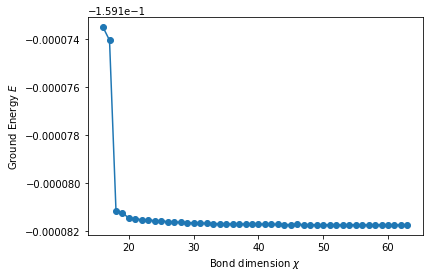

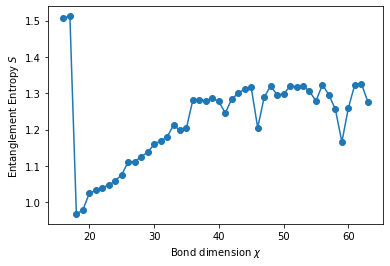

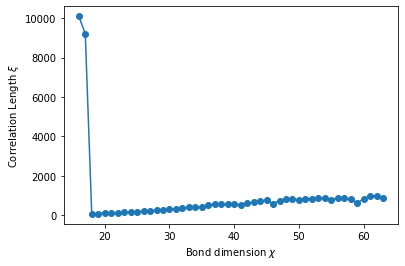

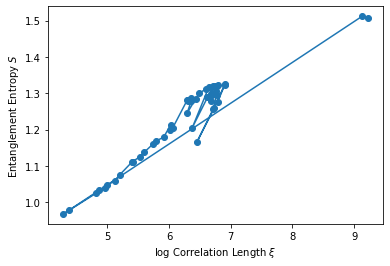

In [8]:
plot_results(data)

In [9]:
chi_list = data['chi_list']
energy_list = data['energy_list']
entropy_list = data['entropy_list']
correlation_list = data['correlation_list']

entropy_list = entropy_list[0:5]
correlation_list = correlation_list[0:5]
log_xi = np.log(correlation_list)

print((entropy_list[-1] - entropy_list[0])/(log_xi[-1] - log_xi[0]) * 6)

0.6582421787116897


## Finite Entanglement Scaling
The below content only works for the gapless cases

In [10]:
# from scipy.optimize import curve_fit

# def func(xi, c, a):
#     return (c / 6) * np.log(xi) + a

In [11]:
# xi = correlation_list
# log_xi = np.log(correlation_list)
# s = entropy_list
# fitParams, fitCovariances = curve_fit(func, xi, s)

In [12]:
# fitCovariances